# Neresbot 0.1

Modelos:
* Convolução
* Long Short-Term Memory
* SARIMA

In [82]:
import pandas as pd
import requests
import json
from pprint import pprint
import yahooquery as yq
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

from tqdm import tqdm

In [83]:
# Função de padronização

def padronização(lista):
    máximo = max(lista)
    mínimo = min(lista)
    return list(map(lambda x: (x-mínimo)/(máximo-mínimo) if (máximo-mínimo) != 0 else 0.5,lista))

# Parâmetros Principais

In [84]:
# Baixar base de dados novamente (True) ou usar a preexistente (False)
download = False
# Usar menos dados e menos processamento
Parâmetros_reduzidos = False
# Criar o índice dos dataframes com base na coluna de datas (não recomendável)
indexing = False

Verif_Date = True

In [85]:
# Parâmetros Principais ##

# Tamanho das séries

Per_List = {0:'1d', 1:'5d', 2:'7d', 3:'60d', 4:'1mo', 5:'3mo', 6:'6mo', 7:'1y', 8:'2y', 9:'5y', 10:'10y', 11:'ytd', 12:'max'}
Interv_List = {0:'1m', 1:'2m', 2:'5m', 3:'15m', 4:'30m', 5:'60m', 6:'90m', 7:'1h', 8:'1d', 9:'5d', 10:'1wk', 11:'1mo', 12:'3mo'}

período = 9
período = Per_List[período]
print('período:',período)

período_res = 6
período_res = Per_List[período_res]
print('período_res:',período_res)

# Tamanho de cada período
intervalo = 8
intervalo = Interv_List[intervalo]
print('intervalo:',intervalo)

# Variação identificada nos períodos seguintes
Variação = 0.1
# Períodos em que o aumento pode ocorrer
Prospecção = 7
# Rótulos negativos, para redução de preço na mesma proporção de aumento
Bidirecional = True
# Rótulos categóricos tentam prever em quantos dias a variação ocorre, do contrário, o resultado será 0 (queda), 1 (manuntenção) ou 2 (aumento).
Categórico = False
# Rótulos positivos sobrepoem rótulos negativos
Otimista = True

# Número deperíodos que compõem um array.
defasagem = 20

# Separação entre teste e validação.
# Não mantenha a soma de ambos maior que 0.5
Teste_porcento = 0.3
Valid_porcento = 0.2

# Número máximo de épocas de treinamento
épocas = 25
# Número de épocas que, consecutivamente iguais em termos de acurácia, encerram o treino
paciência = 70
# Se a acurácia desejada é alcançada, o treino é encerrado
Acurácia_desejada = 0.9

período: 5y
período_res: 6mo
intervalo: 1d


In [86]:
# Metaparâmetros reduzidos


if Parâmetros_reduzidos:
    
    # Períodos em que o aumento pode ocorrer
    Prospecção = 5

    # Número deperíodos que compõem um array.
    defasagem = 7

    # Número máximo de épocas de treinamento
    épocas = 10
    # Número de épocas que, consecutivamente iguais em termos de acurácia, encerram o treino
    paciência = 5
    # Se a acurácia desejada é alcançada, o treino é encerrado
    Acurácia_desejada = 0.8

# Download dos Dados

## Testes

In [87]:
try:
    query = yq.Ticker('PETR4.SA', backoff_factor=0.1, retry=3, status_forcelist=[404, 429, 500, 502, 503, 504], asynchronous=True)
except:
    None
else:
    PETR4 = query.history(period='6mo', interval='1d',adj_timezone=True)
    PETR4 = PETR4.reset_index()
    print(PETR4.columns)
    PETR4['date'] = pd.to_datetime(PETR4['date'])
    PETR4['date'] = PETR4['date'].dt.tz_localize(None)
    PETR4['date'] = PETR4['date'].dt.date
    PETR4 = PETR4.sort_values('date', ascending=True)

try:
    query = yq.Ticker('PETR3.SA', backoff_factor=0.1, retry=3, status_forcelist=[404, 429, 500, 502, 503, 504], asynchronous=True)
except:
    None
else:
    PETR3 = query.history(period='3mo', interval='1d',adj_timezone=True)
    PETR3 = PETR3.reset_index()
    PETR3['date'] = pd.to_datetime(PETR4['date'])
    PETR3['date'] = PETR3['date'].dt.tz_localize(None)
    PETR3['date'] = PETR3['date'].dt.date
    PETR3 = PETR3.sort_values('date', ascending=True)


try:
    query = yq.Ticker('ELET5.SA', backoff_factor=0.1, retry=3, status_forcelist=[404, 429, 500, 502, 503, 504], asynchronous=True)
except:
    None
else:
    ELET5 = query.history(period='3mo', interval='1d',adj_timezone=True)
    ELET5 = ELET5.reset_index()
    ELET5['date'] = pd.to_datetime(PETR4['date'])
    ELET5['date'] = ELET5['date'].dt.tz_localize(None)
    ELET5['date'] = ELET5['date'].dt.date
    ELET5 = ELET5.sort_values('date', ascending=True)

Sim_Set = {'PETR4':PETR4,'ELET5':ELET5}

Index(['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'adjclose',
       'dividends'],
      dtype='object')


In [88]:
query = yq.Ticker('AALR3.SA', backoff_factor=0.1, retry=3, status_forcelist=[404, 429, 500, 502, 503, 504], asynchronous=True)

df_teste = query.history(period='3mo', interval='1d',adj_timezone=True)

df_teste = df_teste.reset_index()

df_teste['date'] = pd.to_datetime(df_teste['date']).dt.date

df_teste

symbol        date       open       high        low      close  \
0   AALR3.SA  2023-03-28  22.590000  22.680000  22.490000  22.680000   
1   AALR3.SA  2023-03-29  22.650000  22.700001  22.510000  22.559999   
2   AALR3.SA  2023-03-30  22.559999  22.600000  22.500000  22.530001   
3   AALR3.SA  2023-04-02  22.500000  22.570000  22.420000  22.520000   
4   AALR3.SA  2023-04-03  22.510000  22.650000  22.490000  22.540001   
..       ...         ...        ...        ...        ...        ...   
57  AALR3.SA  2023-06-21  23.240000  23.600000  23.240000  23.600000   
58  AALR3.SA  2023-06-22  23.620001  23.750000  23.490000  23.510000   
59  AALR3.SA  2023-06-25  23.610001  23.610001  23.340000  23.510000   
60  AALR3.SA  2023-06-26  23.610001  23.610001  23.360001  23.500000   
61  AALR3.SA  2023-06-29   0.000000   0.000000   0.000000  23.650000   

       volume   adjclose  
0    119200.0  22.680000  
1    117100.0  22.559999  
2    132200.0  22.530001  
3    142700.0  22.520000  
4    137600.0  22.540001  
..        ...        ...  
57  1068200.0  23.600000  
58   550300.0  23.510000  
59   176900.0  23.510000  
60   159400.0  23.500000  
61        0.0  23.650000  

[62 rows x 8 columns]

In [89]:
df_teste.to_csv('df teste.csv', index=False)

**Fim dos testes.**

Os símbolos dos tickers são obtidos manualmente do site: https://www.dadosdemercado.com.br/bolsa/acoes

In [90]:
tickers = pd.read_csv("acoes-listadas.csv")

https://yahooquery.dpguthrie.com/

É criado um dicionário que conterá, como chave, o símbolo do ticker e, como valor, o dataframe relacionando medidas e períodos (dias).

Em cada dataframe é adicionado o devido dia da semana, numericamente.

In [91]:
# Os símbolos das empresas brasileiras recebem o sufixo ".SA".

símbolos = tickers['Código'] + '.SA'

In [92]:
# Verificando símbolos inválidos.

print(yq.Ticker(símbolos,
                backoff_factor=1, 
                progress=True, 
                status_forcelist=[404, 429, 500, 502, 503, 504], 
                asynchronous=True
                ).invalid_symbols)

None


Ajuste dos dados:
* Download e armazenamento:
  * Os índices são resetados
  * É verificado se os dados possuem a coluna 'date':
    * É criada a coluna equivalente aos dias semanais
    * Armazenamento no dict dados1
    * Os dados são salvos na pasta 'dados'

In [93]:
from yq_downloader import downloader

In [94]:
#if download:
    #downloader(tickers = símbolos, período = período, report = True, dir = 'dados')
    #downloader(tickers = símbolos, período = período_res, report = True, dir = 'dados_res')

In [95]:
# Função de Download

def hist_download(símbolos,período,intervalo,dir):
    dados1 = {}
    falhas = []
    sem_datas = []
    datas_repetidas = []

    all_dates = []

    for tckr in tqdm(símbolos):
        query = yq.Ticker(tckr, backoff_factor=0.1, retry=3, status_forcelist=[404, 429, 500, 502, 503, 504], asynchronous=True)
        try:
            histórico = query.history(period=período, interval=intervalo,adj_timezone=True)
        except:
            falhas.append(tckr)
            #print(ticker,"falhou.")
        else:
            histórico = histórico.reset_index()
            if 'date' in histórico.columns: # Ajusta os tempos e salva em dados1
                histórico['date'] = pd.to_datetime(histórico['date'])
                histórico['weekday'] = histórico['date'].dt.weekday # Cria dias da semana
                histórico['weekday'] = padronização(histórico['weekday'])
                histórico['yearday'] = histórico['date'].dt.dayofyear # Cria dias da semana
                histórico['yearday'] = padronização(histórico['yearday'])
                histórico['date'] = histórico['date'].dt.tz_localize(None) # Remove timezone
                histórico['date'] = histórico['date'].dt.date # Remove horário
                histórico = histórico.sort_values('date', ascending=True) # Organiza por data
                if histórico['date'].duplicated().any():
                    datas_repetidas.append(tckr)
                
                dados1[tckr] = histórico # Salva tudo em dados1

            else:
                #print(ticker,"não contém datas, mas contém:")
                #print(histórico.columns)
                sem_datas.append(tckr)

    print(len(dados1),"tickers salvos com sucesso.")
    print(len(falhas),"tickers apresentaram falha.")
    print(len(sem_datas),"tickers não contém datas.")
    print(len(datas_repetidas),"tickers contém datas repetidas.")

    # Separa as colunas
    Medidas = []
    print('Medidas:')
    for tckr in dados1:
        for col in dados1[tckr].columns:
            if col not in Medidas:
                Medidas.append(col)
                print(f' {col}')

    # Adiciona colunas às tabelas que não as tinha
    for tckr in dados1.keys():
        for col in Medidas:
            if col not in dados1[tckr].columns:
                dados1[tckr][col] = 0

    # Tornando todos os datasets iguais em termos de datas
    all_dates = set()
    for tckr in dados1.keys():
        all_dates.update(set(dados1[tckr]['date']))
    print(len(all_dates),"datas de negociação encontradas.")

    for tckr in dados1.keys():
        missing_dates = all_dates - set(dados1[tckr]['date'])
        missing_data = pd.DataFrame({'date': list(missing_dates)})
        dados1[tckr] = pd.concat([dados1[tckr], missing_data], ignore_index=True)
        # Classifica o dataframe pela coluna 'date' para garantir a ordem correta
        dados1[tckr] = dados1[tckr].sort_values('date').reset_index(drop=True)
        # Preenche cada valor nulo com o número válido anterior
        dados1[tckr] = dados1[tckr].fillna(method = 'ffill')

    # Cria a pasta se ela não existe
    if not os.path.exists(dir):
        os.makedirs(dir)
        
    # Arquiva cada uma das tabelas em .csv
    for tckr, df in dados1.items():
        caminho_arquivo = os.path.join(dir, f'{tckr}.csv')
        df.to_csv(caminho_arquivo, index=False)

    return (falhas, sem_datas, datas_repetidas, Medidas, all_dates)

In [96]:
if download:
    hist_download(símbolos,
                  período,
                  intervalo,
                  'dados')

In [97]:
if download:
    a,b,c,d,c = hist_download(símbolos,período_res,intervalo,'dados_reduzidos')

# Preparação dos Dados

In [98]:
# Carregando dados .csv

dados1 = {}  # Dicionário vazio para armazenar as tabelas
Shapes = []
Rows = []
Columns = []

if Parâmetros_reduzidos:
    print('Dados reduzidos.')
    pasta = 'dados_reduzidos'
else:
    print('Dados completos.')
    pasta = 'dados'

# Percorre todos os arquivos na pasta
for nome_arquivo in os.listdir(pasta):
    if nome_arquivo.endswith('.csv'):  # Verifica se o arquivo é um arquivo CSV
        caminho_arquivo = os.path.join(pasta, nome_arquivo)  # Caminho completo para o arquivo

        histórico = pd.read_csv(caminho_arquivo)
        if 'date' in histórico.columns: # Ajusta os tempos e salva em dadosRe
            histórico['date'] = pd.to_datetime(histórico['date'])
            histórico['date'] = histórico['date'].dt.tz_localize(None) # Remove timezone
            histórico['date'] = histórico['date'].dt.date # Remove horário
            histórico = histórico.sort_values('date') # Organiza por data
        
        dados1[os.path.splitext(nome_arquivo)[0]] = histórico
        Shapes.append(histórico.shape)
        Rows.append(len(histórico.index))
        Columns.append(len(histórico.columns))

# Imprime o dicionário com as tabelas
print(f'{len(dados1)} históricos salvos.')

Rows = pd.Series(Rows).value_counts()
Columns = pd.Series(Columns).value_counts()


Dados reduzidos.


525 históricos salvos.


In [99]:
Rows

77    465
59     60
dtype: int64

In [100]:
Columns

12    465
11     60
dtype: int64

In [101]:
# Separando as tabelas por grupos de semelhantes
 # Por datas
 # Por formato

sets_by_date = []

for tckr in dados1.keys():
    hist = dados1[tckr]

    if len(sets_by_date) == 0:
        sets_by_date.append({})
    
    set_index = 0
    Verif = True

    # Todo ticker começa olhando para primeiro set

    while Verif:
        # Se o set para o qual está olhando (set_index) está vazio, cria um 'date' para o set e coloca o ticker atual no set.
        if len(sets_by_date[set_index]) == 0:
            sets_by_date[set_index][tckr] = hist
            sets_by_date[set_index]['hist'] = hist['date']
            sets_by_date[set_index]['shape'] = hist.shape
            Verif = False                                              # Próximo ticker, set 0
        else:
            if (sets_by_date[set_index]['hist'].equals(hist['date'])) and (sets_by_date[set_index]['shape'] == hist.shape):
                sets_by_date[set_index][tckr] = hist
                Verif = False                                          # Próximo ticker, set 0
            else:
                set_index += 1                                         # Próximo set, set 0
                if set_index == len(sets_by_date):
                    sets_by_date.append({})

print(f'{type(sets_by_date)}, Número de sets: {len(sets_by_date)}')
print(f'{type(sets_by_date[0])},{len(sets_by_date[0])}')
print(type(sets_by_date[0]['PETR4.SA']),len(sets_by_date[0]['PETR4.SA']))


<class 'list'>, Número de sets: 2
<class 'dict'>,467
<class 'pandas.core.frame.DataFrame'> 77


In [102]:
for Set in sets_by_date:
    print(Set['shape'],len(Set))

(77, 12) 467
(59, 11) 62


Maiores empresas na bolsa:
* Petrobras: PETR4.SA, PETR3.SA
* Vale: VALE.SA
* Itaú Unibanco: ITUB4.SA, ITUB3.SA, ITSA4.SA
* Ambev: ABEV.SA, 
* Bradesco: BBDC3.SA,  BBDC4.SA
* Weg: WEGE3.SA
* Santander: SANB3.SA, SANB4.SA
* Eletrobrás: ELET5.SA, ELET6.SA, ELET5.SA
* BTG: BPAC3.SA, BPAC5.SA
* Banco do Brasil: BBAS3.SA

In [103]:
princ_tckrs = ['PETR4.SA',
               'PETR3.SA',
               'VALE.SA',
               'ITUB4.SA',
               'ITUB3.SA',
               'ITSA4.SA',
               'ABEV.SA',
               'BBDC3.SA',
               'BBDC4.SA',
               'WEGE3.SA',
               'SANB3.SA',
               'SANB4.SA',
               'ELET5.SA',
               'ELET6.SA',
               'ELET5.SA',
               'BPAC3.SA',
               'BPAC5.SA',
               'BBAS3.SA']


for tckr in princ_tckrs:
    for i in range(len(sets_by_date)):
        if tckr in sets_by_date[i].keys():
            Shape = sets_by_date[i]['shape']
            print(f'{tckr} - set id: {i}; tamanho do set: {len(sets_by_date[i])}, shape: {Shape}')
            #print(' ',list(sets_by_date[i][tckr].columns))

PETR4.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
PETR3.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
ITUB4.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
ITUB3.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
ITSA4.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
BBDC3.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
BBDC4.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
WEGE3.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
SANB3.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
SANB4.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
ELET5.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
ELET6.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
ELET5.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
BPAC3.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
BPAC5.SA - set id: 0; tamanho do set: 467, shape: (77, 12)
BBAS3.SA - set id: 0; tamanho do set: 467, shape: (77, 12)


In [104]:
# Verificação dos formatos das tabelas.

for sets in sets_by_date:
    Len = {}
    for tckr in sets.keys():
        if tckr not in ('hist','shape'):
            Shape = str(sets[tckr].shape)
            if Shape not in Len.keys():
                Len[Shape] = 0
            Len[Shape] += 1
    print(Len)

{'(77, 12)': 465}
{'(59, 11)': 60}


Se os ticker existentes em determinados dados não puderemser baixados para o período necessário para a prospecção, não devem ser incluídos no modelo.

In [105]:
dados2 = sets_by_date[0]
if 'hist' in dados2.keys():
    del dados2['hist']
if 'shape' in dados2.keys():
    del dados2['shape']


In [106]:
# Verificando se todas as colunas 'date' são iguais 

if Verif_Date:
    ticker_divergentes = pd.DataFrame(columns=dados2.keys(), index=dados2.keys())

    for column in dados2.keys():
        for index in dados2.keys():
            if dados1[column]['date'].equals(dados2[index]['date']):
                ticker_divergentes.at[index,column] = True
            else:
                ticker_divergentes.at[index,column] = False

    ticker_divergentes.to_csv('ticker_divergentes.csv')
    ticker_divergentes

# Convolução

## Rótulos

Cada linha analisa se há aumento expressivo nos próximos 5 períodos.

Se não houver, o rótulo será 0; Caso contrário, será o número de dias em que o aumento ocorre.  
Há uma variável ajustável para determinar o nível do aumento.

In [107]:
print('Parâmetros_reduzidos:',Parâmetros_reduzidos)
print('Prospecção:',Prospecção)
print('Bidirecional:',Bidirecional)
print('Categórico:',Categórico)

Parâmetros_reduzidos: True
Prospecção: 5
Bidirecional: True
Categórico: False


In [108]:
if Otimista:
    # 2 - Valores dos Rótulos, separando as buscaspositivas e negativas
    Verbose = False
    print(f'') if Verbose else None

    print('SE BIDIRECIONAL: OS VALORES MAIS ALTOS SERÃO O DOBRO DA PROSPECÇÃO.')
    # Coluna para os rótulos

    for i,j in dados2.items():
        j['rótulos'] = 0
        j['compar'] = 0

    # Valores para os rótulos

    for tckr, df in tqdm(dados2.items()):                  # Para cada ticker, tabela:                      # reseta o índice da tabela
        print() if Verbose else None
        print('Ticker:',tckr) if Verbose else None
        
        for i, row in df.iterrows():
            price_now = row['close']
            price_contester_high = row['close']
            price_contester_high_id = i
            price_contester_low = row['close']
            price_contester_low_id = i
            print(' i:',i,'; price_now e contests:',price_now) if Verbose else None


            # Iteração entre os próximos "Prospecção" itens, procurando negativos.
            if Bidirecional:
                print(' Procurando aumentos:') if Verbose else None
                for j in range(i+1, i+1+Prospecção):
                    
                    # Se J ainda é dentro da tabela
                    if j < len(df):
                        print(f'  j:{j}') if Verbose else None
                        j_low = df.loc[j, 'low']
                        print(f'   low de j={j}: {j_low}.') if Verbose else None

                        # se o preço avaliado é menor ou igual à redução esperada e é bidirecional:
                        if (j_low <= (1-Variação)*price_now) and (j_low < price_contester_low) and Bidirecional:
                            print(f'     post_low ({j_low}) supera a variação esperada ({(1 + Variação)*price_now}) e o último maior ({price_contester_low}).') if Verbose else None
                            if Categórico:
                                dados2[tckr].loc[i, 'rótulos'] = i - j
                            else:
                                dados2[tckr].loc[i, 'rótulos'] = -1
                            dados2[tckr].loc[i, 'compar'] = j_low
                            price_contester_low = j_low
                            price_contester_low_id = j
                            temp = dados2[tckr].loc[i, 'rótulos']
                            print(f'     Rótulo atualizado: {temp}') if Verbose else None
                            print(f'     O último menor preço para o id {i} agora é {price_contester_low}, do id {j}.') if Verbose else None
                        else:
                            temp = dados2[tckr].loc[i, 'rótulos']
                            print(f'     Rótulo permanece: {temp}') if Verbose else None
                    else:
                        print('   j ultrapassa o limite da tabela') if Verbose else None
                    
                    

            # Procurando positivos.
            print(' Procurando aumentos:') if Verbose else None
            for j in range(i+1, i+1+Prospecção):
                
                # Se J ainda é dentro da tabela
                if j < len(df):
                    print(f'  j:{j}') if Verbose else None
                    j_high = df.loc[j, 'high']
                    print(f'   high de j={j}: {j_high}.') if Verbose else None
                    
                    # se o preço avaliado é maior ou igual ao aumento esperado:
                    if (j_high >= (1 + Variação)*price_now) and (j_high > price_contester_high):
                        print(f'     j_high ({j_high}) supera a variação esperada ({(1 + Variação)*price_now}) e o último maior ({price_contester_high}).') if Verbose else None
                        if Categórico:
                            dados2[tckr].loc[i, 'rótulos'] = j - i
                        else:
                            dados2[tckr].loc[i, 'rótulos'] = 1
                        dados2[tckr].loc[i, 'compar'] = j_high
                        price_contester_high = j_high
                        price_contester_high_id = j
                        temp = dados2[tckr].loc[i, 'rótulos']
                        print(f'     Rótulo atualizado: {temp}') if Verbose else None
                        print(f'     O último maior preço para o id {i} agora é {price_contester_high}, do id {j}.') if Verbose else None
                    else:
                        temp = dados2[tckr].loc[i, 'rótulos']
                        print(f'     Rótulo permanece: {temp}') if Verbose else None
                else:
                    print('   j ultrapassa o limite da tabela') if Verbose else None


            
            if dados2[tckr].loc[i, 'rótulos'] == 0:
                print(f'  Nenhum id entre {i+1} e {j} apresentou valores consideráveis') if Verbose else None
                print(f'    j_high depois: {j_high}') if Verbose else None
                print(f'    j_low depois: {j_low}') if Verbose else None


            # Remoção de rótulos negativos
            if Bidirecional:
                if Categórico:
                    dados2[tckr].loc[i, 'rótulos'] += Prospecção
                else:
                    dados2[tckr].loc[i, 'rótulos'] += 1
            temp = dados2[tckr].loc[i, 'rótulos']
            print(f'    Para o id ({i}) o rótulo definitivo é {temp}') if Verbose else None

            if Verbose:
                if (((dados2[tckr].loc[i, 'rótulos'] != Prospecção) and (Categórico)) or (dados2[tckr].loc[i, 'rótulos'] != 1)) and (tckr == 'ITSA4.SA'):
                    print(row['symbol'], dados2[tckr].loc[i, 'rótulos'], (((j_high/price_now)-1)*100), (((j_high/price_now)-1)*100)) if Verbose else None
                    print(row['symbol'], dados2[tckr].loc[i, 'rótulos'], (((j_low/price_now)-1)*100), (((j_low/price_now)-1)*100)) if Verbose else None
        
        # print(df.head()) #??

SE BIDIRECIONAL: OS VALORES MAIS ALTOS SERÃO O DOBRO DA PROSPECÇÃO.


100%|██████████| 465/465 [00:18<00:00, 25.38it/s]


In [109]:
if not Otimista:
    # 2 - Valores dos Rótulos, separando as buscaspositivas e negativas
    Verbose = False
    print(f'') if Verbose else None

    print('SE BIDIRECIONAL: OS VALORES MAIS ALTOS SERÃO O DOBRO DA PROSPECÇÃO.')
    # Coluna para os rótulos

    for i,j in dados2.items():
        j['rótulos'] = 0
        j['compar'] = 0

    # Valores para os rótulos

    for tckr, df in tqdm(dados2.items()):                  # Para cada ticker, tabela:                      # reseta o índice da tabela
        print() if Verbose else None
        print('Ticker:',tckr) if Verbose else None
        
        for i, row in df.iterrows():
            price_now = row['close']
            price_contester_high = row['close']
            price_contester_high_id = i
            price_contester_low = row['close']
            price_contester_low_id = i
            print(' i:',i,'; price_now e contests:',price_now) if Verbose else None


            # Procurando positivos.
            print(' Procurando aumentos:') if Verbose else None
            for j in range(i+1, i+1+Prospecção):
                
                # Se J ainda é dentro da tabela
                if j < len(df):
                    print(f'  j:{j}') if Verbose else None
                    j_high = df.loc[j, 'high']
                    print(f'   high de j={j}: {j_high}.') if Verbose else None
                    
                    # se o preço avaliado é maior ou igual ao aumento esperado:
                    if (j_high >= (1 + Variação)*price_now) and (j_high > price_contester_high):
                        print(f'     j_high ({j_high}) supera a variação esperada ({(1 + Variação)*price_now}) e o último maior ({price_contester_high}).') if Verbose else None
                        if Categórico:
                            dados2[tckr].loc[i, 'rótulos'] = j - i
                        else:
                            dados2[tckr].loc[i, 'rótulos'] = 1
                        dados2[tckr].loc[i, 'compar'] = j_high
                        price_contester_high = j_high
                        price_contester_high_id = j
                        temp = dados2[tckr].loc[i, 'rótulos']
                        print(f'     Rótulo atualizado: {temp}') if Verbose else None
                        print(f'     O último maior preço para o id {i} agora é {price_contester_high}, do id {j}.') if Verbose else None
                    else:
                        temp = dados2[tckr].loc[i, 'rótulos']
                        print(f'     Rótulo permanece: {temp}') if Verbose else None
                else:
                    print('   j ultrapassa o limite da tabela') if Verbose else None


            
            # Iteração entre os próximos "Prospecção" itens, procurando negativos.
            if Bidirecional:
                print(' Procurando aumentos:') if Verbose else None
                for j in range(i+1, i+1+Prospecção):
                    
                    # Se J ainda é dentro da tabela
                    if j < len(df):
                        print(f'  j:{j}') if Verbose else None
                        j_low = df.loc[j, 'low']
                        print(f'   low de j={j}: {j_low}.') if Verbose else None

                        # se o preço avaliado é menor ou igual à redução esperada e é bidirecional:
                        if (j_low <= (1-Variação)*price_now) and (j_low < price_contester_low) and Bidirecional:
                            print(f'     post_low ({j_low}) supera a variação esperada ({(1 + Variação)*price_now}) e o último maior ({price_contester_low}).') if Verbose else None
                            if Categórico:
                                dados2[tckr].loc[i, 'rótulos'] = i - j
                            else:
                                dados2[tckr].loc[i, 'rótulos'] = -1
                            dados2[tckr].loc[i, 'compar'] = j_low
                            price_contester_low = j_low
                            price_contester_low_id = j
                            temp = dados2[tckr].loc[i, 'rótulos']
                            print(f'     Rótulo atualizado: {temp}') if Verbose else None
                            print(f'     O último menor preço para o id {i} agora é {price_contester_low}, do id {j}.') if Verbose else None
                        else:
                            temp = dados2[tckr].loc[i, 'rótulos']
                            print(f'     Rótulo permanece: {temp}') if Verbose else None
                    else:
                        print('   j ultrapassa o limite da tabela') if Verbose else None
                    
                    

            if dados2[tckr].loc[i, 'rótulos'] == 0:
                print(f'  Nenhum id entre {i+1} e {j} apresentou valores consideráveis') if Verbose else None
                print(f'    j_high depois: {j_high}') if Verbose else None
                print(f'    j_low depois: {j_low}') if Verbose else None


            # Remoção de rótulos negativos
            if Bidirecional:
                if Categórico:
                    dados2[tckr].loc[i, 'rótulos'] += Prospecção
                else:
                    dados2[tckr].loc[i, 'rótulos'] += 1
            temp = dados2[tckr].loc[i, 'rótulos']
            print(f'    Para o id ({i}) o rótulo definitivo é {temp}') if Verbose else None

            if Verbose:
                if (((dados2[tckr].loc[i, 'rótulos'] != Prospecção) and (Categórico)) or (dados2[tckr].loc[i, 'rótulos'] != 1)) and (tckr == 'ITSA4.SA'):
                    print(row['symbol'], dados2[tckr].loc[i, 'rótulos'], (((j_high/price_now)-1)*100), (((j_high/price_now)-1)*100)) if Verbose else None
                    print(row['symbol'], dados2[tckr].loc[i, 'rótulos'], (((j_low/price_now)-1)*100), (((j_low/price_now)-1)*100)) if Verbose else None
        
        # print(df.head()) #??

In [110]:
print('  Rótulos')
for tckr in dados2:
    print(tckr+':', dados2[tckr]['rótulos'].min(), dados2[tckr]['rótulos'].max())

  Rótulos
AALR3.SA: 1 1
ABCB4.SA: 1 1
ABEV3.SA: 1 1
AERI3.SA: 0 2
AESB3.SA: 1 2
AFLT3.SA: 1 1
AGRO3.SA: 1 2
AGXY3.SA: 0 2
AHEB3.SA: 1 2
AHEB5.SA: 0 1
AHEB6.SA: 0 1
ALLD3.SA: 1 2
ALPA3.SA: 0 2
ALPA4.SA: 0 2
ALPK3.SA: 0 2
ALSO3.SA: 1 1
ALUP3.SA: 1 1
ALUP4.SA: 1 1
AMAR3.SA: 0 2
AMBP3.SA: 0 2
AMER3.SA: 0 2
ANIM3.SA: 0 2
APER3.SA: 1 2
ARML3.SA: 0 2
ARZZ3.SA: 0 2
ASAI3.SA: 0 2
ATMP3.SA: 0 2
ATOM3.SA: 0 2
AVLL3.SA: 0 2
AZEV3.SA: 0 2
AZEV4.SA: 0 2
AZUL4.SA: 0 2
B3SA3.SA: 1 2
BAHI3.SA: 0 2
BALM3.SA: 1 2
BALM4.SA: 0 1
BAUH4.SA: 0 1
BAZA3.SA: 0 1
BBAS3.SA: 1 2
BBDC3.SA: 1 2
BBDC4.SA: 1 2
BBSE3.SA: 0 1
BDLL3.SA: 0 2
BDLL4.SA: 1 2
BEEF3.SA: 0 2
BEES3.SA: 0 2
BEES4.SA: 0 2
BGIP3.SA: 0 2
BGIP4.SA: 1 2
BIOM3.SA: 0 2
BLAU3.SA: 0 2
BMEB3.SA: 0 2
BMEB4.SA: 1 1
BMGB4.SA: 1 2
BMIN3.SA: 0 2
BMIN4.SA: 1 2
BMKS3.SA: 0 1
BMOB3.SA: 0 1
BNBR3.SA: 1 1
BOAS3.SA: 1 1
BOBR4.SA: 0 2
BPAC3.SA: 1 2
BPAC5.SA: 1 2
BPAN4.SA: 1 2
BRAP3.SA: 0 1
BRAP4.SA: 0 1
BRFS3.SA: 0 2
BRGE11.SA: 1 1
BRGE12.SA: 1 1
BRGE3.SA: 1 1
BRGE5.SA

In [111]:
for tckr in dados2:
    print(dados2[tckr].tail(4))

      symbol        date       open       high        low  close    volume  \
73  AALR3.SA  2023-06-25  23.610001  23.610001  23.340000  23.51  176900.0   
74  AALR3.SA  2023-06-26  23.610001  23.610001  23.360001  23.50  159400.0   
75  AALR3.SA  2023-06-27  23.610001  23.610001  23.360001  23.50  159400.0   
76  AALR3.SA  2023-06-29  23.680000  23.719999  23.580000  23.65  179000.0   

    adjclose  weekday   yearday  dividends  splits  rótulos  compar  
73     23.51      1.0  0.956989        0.0     0.0        1       0  
74     23.50      0.0  0.967742        0.0     0.0        1       0  
75     23.50      0.0  0.967742        0.0     0.0        1       0  
76     23.65      0.5  1.000000        0.0     0.0        1       0  
      symbol        date       open       high        low      close  \
73  ABCB4.SA  2023-06-25  18.510000  18.530001  18.040001  18.370001   
74  ABCB4.SA  2023-06-26  18.799999  19.000000  18.360001  18.620001   
75  ABCB4.SA  2023-06-27  18.799999  19.000

In [112]:
print('  Dividendos')
for tckr in dados2:
    print(tckr+':',dados2[tckr]['dividends'].max())

  Dividendos
AALR3.SA: 0.0
ABCB4.SA: 0.0
ABEV3.SA: 0.0
AERI3.SA: 0.0
AESB3.SA: 0.0
AFLT3.SA: 0.114065
AGRO3.SA: 0.0
AGXY3.SA: 0.039657
AHEB3.SA: 0.0
AHEB5.SA: 0.0
AHEB6.SA: 0.0
ALLD3.SA: 0.0
ALPA3.SA: 0.0
ALPA4.SA: 0.0
ALPK3.SA: 0.0
ALSO3.SA: 0.519014
ALUP3.SA: 0.48
ALUP4.SA: 0.48
AMAR3.SA: 0.0
AMBP3.SA: 0.134135
AMER3.SA: 0.0
ANIM3.SA: 0.0
APER3.SA: 0.323684
ARML3.SA: 0.034749
ARZZ3.SA: 0.0
ASAI3.SA: 0.050019
ATMP3.SA: 0.0
ATOM3.SA: 0.320385
AVLL3.SA: 0.0
AZEV3.SA: 0.0
AZEV4.SA: 0.0
AZUL4.SA: 0.0
B3SA3.SA: 0.115354
BAHI3.SA: 0.0
BALM3.SA: 0.11
BALM4.SA: 0.11
BAUH4.SA: 1.20933
BAZA3.SA: 5.55926
BBAS3.SA: 0.65442
BBDC3.SA: 0.178997
BBDC4.SA: 0.196897
BBSE3.SA: 0.0
BDLL3.SA: 0.0
BDLL4.SA: 0.0
BEEF3.SA: 0.356628
BEES3.SA: 0.18043
BEES4.SA: 0.18043
BGIP3.SA: 0.0
BGIP4.SA: 0.0
BIOM3.SA: 0.0
BLAU3.SA: 0.186959
BMEB3.SA: 0.0
BMEB4.SA: 0.0
BMGB4.SA: 0.02
BMIN3.SA: 0.0
BMIN4.SA: 0.0
BMKS3.SA: 57.78632
BMOB3.SA: 0.0
BNBR3.SA: 3.666922
BOAS3.SA: 0.0
BOBR4.SA: 0.0
BPAC3.SA: 0.0
BPAC5.SA: 0.0
BPAN4

## Transformação das matrizes: Separando os dias como objetos numpy.

Classes que contenham as matrizes, os rótulos e a identificação do dia.

In [113]:
# Todos os dataframes:

df_concatenado = pd.concat(dados2.values(), axis=1)

In [114]:
df_concatenado.to_csv('df_concatenado.csv',index=True)

O último dia não deve estar incluso no treinamento por não possuir rótulo.

Dimensões:
* Medidas:
  * open
  * high
  * low
  * close
  * volume
  * adjclose
  * weekday
  * yearday
  * dividends
  * splits
* tickers
* Dias (atual e anteriores)

In [115]:
# Adição de colunas "necessárias"
# Remoção das colunas "desnecessárias"

Colunas_Necessárias = ['open',
                    'high',
                    'low', 
                    'close', 
                    'volume', 
                    'adjclose', 
                    'weekday', 
                    'yearday', 
                    'dividends', 
                    'splits', 
                    'rótulos']

dados3 = {}

for tckr in dados2.keys():
    for c in Colunas_Necessárias:
        if c not in dados2[tckr].columns:
            dados2[tckr][c] = 0

for tckr in dados2.keys():
    dados3[tckr] = dados2[tckr][Colunas_Necessárias]

In [116]:
dados3['AALR3.SA'].columns

Index(['open', 'high', 'low', 'close', 'volume', 'adjclose', 'weekday',
       'yearday', 'dividends', 'splits', 'rótulos'],
      dtype='object')

In [117]:
# Tendo certeza de que todas as tabelas têm o mesmo tamanho.

for t in dados3.keys():
    for k in dados3.keys():
        Série = len(dados3[t])
        dif = len(dados3[t])-len(dados3[k])
        if dif != 0:
            print(t,'-',k,'=',dif)

In [118]:
Série

77

Há uma variável ajustável para determinar quantos dias serão olhados para trás.

In [119]:
# Criação lista completa

Tensor = []

Rótulos = {}
for tckr in dados3.keys():
    Rótulos[tckr] = []

for i in range(Série-Prospecção):
    lvl1 = []
    for tckr in dados3.keys():
        lvl2 = []
        for coluna in dados3[tckr].columns:
            if coluna != 'rótulos':
                lvl3 = []
                for j in range(i - defasagem, i):
                    if j >= 0:
                        k = j
                    else:
                        k = 0
                    lvl3.append(dados3[tckr].at[k,coluna])
                    if coluna not in ['weekday','yearday']:
                        lvl3p = padronização(lvl3)
            lvl2.append(lvl3p)
        lvl1.append(lvl2)
        Rótulos[tckr].append(dados3[tckr].at[i,'rótulos'])
    Tensor.append(lvl1)

## Separação entre Treino, Teste e Validação.

É preciso garantir que as matrizes sejam embaralhadas, mas que os rótulos permaneçam atrelados adequadamente.

In [120]:
type(Tensor)

list

In [121]:
Treino_tensor = []
Teste_tensor = []
Valid_tensor = []

Treino_rótulo = {}
for tckr in dados3.keys():
    Treino_rótulo[tckr] = []

Teste_rótulo = {}
for tckr in dados3.keys():
    Teste_rótulo[tckr] = []

Valid_rótulo = {}
for tckr in dados3.keys():
    Valid_rótulo[tckr] = []

id_teste_valid = random.sample(list(range(len(Tensor))), int(round(len(Tensor)*(Teste_porcento+Valid_porcento), 0)))

id_valid = random.sample(id_teste_valid, int(round(len(Tensor)*Valid_porcento, 0)))

for i in range(len(Tensor)):
    if i in id_valid:
        Valid_tensor.append(Tensor[i])
        for tckr in Valid_rótulo.keys():
            Valid_rótulo[tckr].append(Rótulos[tckr][i])
            
    elif i in id_teste_valid:
        Teste_tensor.append(Tensor[i])
        for tckr in Teste_rótulo.keys():
            Teste_rótulo[tckr].append(Rótulos[tckr][i])

    else:
        Treino_tensor.append(Tensor[i])
        for tckr in Treino_rótulo.keys():
            Treino_rótulo[tckr].append(Rótulos[tckr][i])

Treino_tensor = np.array(Treino_tensor)
Teste_tensor = np.array(Teste_tensor)
Valid_tensor = np.array(Valid_tensor)

for tckr in Treino_rótulo.keys():
    Treino_rótulo[tckr] = np.array(Treino_rótulo[tckr])
for tckr in Teste_rótulo.keys():
    Teste_rótulo[tckr] = np.array(Teste_rótulo[tckr])
for tckr in Valid_rótulo.keys():
    Valid_rótulo[tckr] = np.array(Valid_rótulo[tckr])

In [122]:
print(Treino_tensor.shape)
print(Teste_tensor.shape)
print(Valid_tensor.shape)

print()

print(len(Treino_rótulo),len(Treino_rótulo['PETR4.SA']))
print(len(Teste_rótulo),len(Teste_rótulo['PETR4.SA']))
print(len(Valid_rótulo),len(Valid_rótulo['PETR4.SA']))

(36, 465, 11, 7)
(22, 465, 11, 7)
(14, 465, 11, 7)

465 36
465 22
465 14


## Modelo

* Para cada ticker (a partir do dicionário de rótulos):  
    * O modelo é treinado seguindo aquele ticker como rótulo (com uma função)  
    * O modelo é validado  
    * Se o modelo é válido:  
        * A previsão é tentada:  
        * Se o resultado é diferente de zero E a probabilidade é alta:  
                * O deploy é salvo

Exemplo com um ticker: PTR4.SA

In [123]:
Shape = Treino_tensor.shape[1:]
Ativação = 'relu'

print(Shape)

(465, 11, 7)


In [124]:
# Cria o objeto de sequência de camadas
modelo = models.Sequential()

modelo.add(layers.Conv2D(64, (4, 2), activation = 'relu', input_shape = Shape))
modelo.add(layers.MaxPooling2D((2, 2)))

modelo.add(layers.Conv2D(64, (4, 2), activation = 'relu'))
modelo.add(layers.MaxPooling2D((2, 2)))

modelo.add(layers.Conv2D(64, (1, 1), activation = 'relu'))
modelo.add(layers.MaxPooling2D((2, 2)))

modelo.add(layers.Flatten())

modelo.add(layers.Dense(64, activation = 'relu'))

modelo.add(layers.Dense(32, activation = 'relu'))

modelo.add(layers.Dense((Prospecção+1), activation = 'softmax'))

modelo.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 462, 10, 64)       3648      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 231, 5, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 228, 4, 64)        32832     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 114, 2, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 114, 2, 64)        4160      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 57, 1, 64)       

In [125]:
modelo.compile(optimizer = 'adam', 
                   loss = 'sparse_categorical_crossentropy', 
                   metrics = ['accuracy'])

In [126]:
class AccuracyThresholdCallback(Callback):
    def __init__(self, accuracy_threshold):
        super(AccuracyThresholdCallback, self).__init__()
        self.accuracy_threshold = accuracy_threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] >= self.accuracy_threshold:
            self.model.stop_training = True
            print(f"\nAtingiu a acurácia desejada ({self.accuracy_threshold}). Treinamento interrompido.")

In [127]:
# Criando um parâmetro de parada com o objeto EarlyStopping
early_stopping = EarlyStopping(monitor='accuracy', mode='max', patience=paciência, verbose=1)

# Salvando a melhor época.
checkpoint = ModelCheckpoint('Modelos\\melhor_CNN.h5', monitor='val_accuracy', mode='max', save_best_only=True)

# Criar o objeto do callback personalizado
accuracy_callback = AccuracyThresholdCallback(Acurácia_desejada)

In [128]:
# Treinamento e teste

history = modelo.fit(Treino_tensor, 
                         Treino_rótulo['PETR4.SA'], 
                         epochs = 5, 
                         validation_data = (Teste_tensor, Teste_rótulo['PETR4.SA']),
                         callbacks=[early_stopping, checkpoint])

Epoch 1/5


2/2 [==============================] - 1s 314ms/step - loss: 1.7330 - accuracy: 0.7222 - val_loss: 1.7637 - val_accuracy: 0.9091
Epoch 2/5
2/2 [==============================] - 0s 52ms/step - loss: 1.7646 - accuracy: 0.8333 - val_loss: 1.7094 - val_accuracy: 0.9091
Epoch 3/5
2/2 [==============================] - 0s 85ms/step - loss: 1.7131 - accuracy: 0.8333 - val_loss: 1.6241 - val_accuracy: 0.9091
Epoch 4/5
2/2 [==============================] - 0s 126ms/step - loss: 1.6339 - accuracy: 0.8333 - val_loss: 1.5004 - val_accuracy: 0.9091
Epoch 5/5
2/2 [==============================] - 0s 49ms/step - loss: 1.5202 - accuracy: 0.8333 - val_loss: 1.3344 - val_accuracy: 0.9091


In [129]:
modelo.evaluate(Valid_tensor, Valid_rótulo['PETR4.SA'], verbose = 2)

1/1 - 0s - loss: 1.3611 - accuracy: 0.8571 - 73ms/epoch - 73ms/step


[1.3611459732055664, 0.8571428656578064]

1/1 - 0s - loss: 1.3611 - accuracy: 0.8571 - 37ms/epoch - 37ms/step


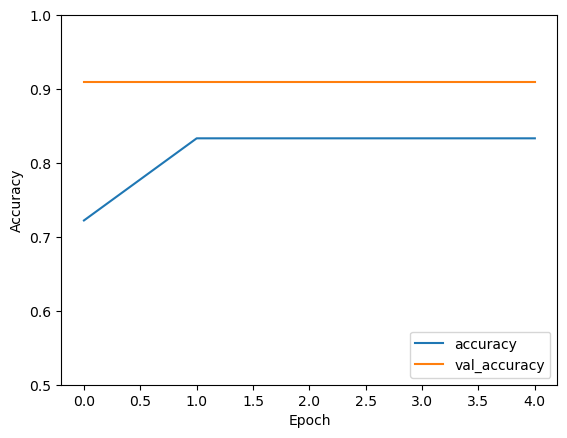

In [130]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelo.evaluate(Valid_tensor, Valid_rótulo['PETR4.SA'], verbose=2)

1/1 [==============================] - 0s 95ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 2 2 1 1]


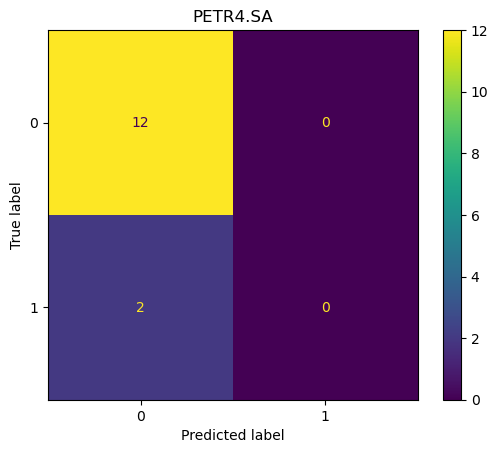

In [131]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_predictions = modelo.predict(Valid_tensor)

test_predicted_labels = np.argmax(test_predictions, axis=1)
print(test_predicted_labels)

test_true_labels = np.array(Valid_rótulo['PETR4.SA'])
print(test_true_labels)

cm = confusion_matrix(test_true_labels, test_predicted_labels)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.title('PETR4.SA')
plt.show()

  0%|          | 0/465 [00:00<?, ?it/s]

Epoch 6: early stopping
1/1 [==============================] - 0s 95ms/step


  0%|          | 1/465 [00:02<15:53,  2.06s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 123ms/step


  0%|          | 2/465 [00:04<16:03,  2.08s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 99ms/step


  1%|          | 3/465 [00:06<16:39,  2.16s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 92ms/step


  1%|          | 4/465 [00:08<16:44,  2.18s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 137ms/step


  1%|          | 5/465 [00:10<16:42,  2.18s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 151ms/step


  1%|▏         | 6/465 [00:13<17:45,  2.32s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 126ms/step


  2%|▏         | 7/465 [00:15<17:22,  2.28s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 116ms/step


  2%|▏         | 8/465 [00:18<18:09,  2.38s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 116ms/step


  2%|▏         | 9/465 [00:21<19:14,  2.53s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 111ms/step


  2%|▏         | 10/465 [00:23<19:21,  2.55s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 153ms/step


  2%|▏         | 11/465 [00:25<18:45,  2.48s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 125ms/step


  3%|▎         | 12/465 [00:28<18:33,  2.46s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


  3%|▎         | 13/465 [00:30<18:02,  2.40s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 126ms/step


  3%|▎         | 14/465 [00:33<18:04,  2.40s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 122ms/step


  3%|▎         | 15/465 [00:35<17:39,  2.35s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 130ms/step


  3%|▎         | 16/465 [00:37<17:19,  2.32s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 124ms/step


  4%|▎         | 17/465 [00:39<16:43,  2.24s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 114ms/step


  4%|▍         | 18/465 [00:42<17:22,  2.33s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 115ms/step


  4%|▍         | 19/465 [00:44<18:03,  2.43s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 151ms/step


  4%|▍         | 20/465 [00:46<17:13,  2.32s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 115ms/step


c:\Users\fnsb\anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
  5%|▍         | 21/465 [00:49<17:10,  2.32s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 165ms/step


  5%|▍         | 22/465 [00:51<17:01,  2.31s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 152ms/step


  5%|▍         | 23/465 [00:53<17:26,  2.37s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


  5%|▌         | 24/465 [00:56<17:13,  2.34s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 114ms/step


  5%|▌         | 25/465 [00:58<17:42,  2.41s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 127ms/step


  6%|▌         | 26/465 [01:01<17:29,  2.39s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 122ms/step


  6%|▌         | 27/465 [01:03<17:09,  2.35s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 127ms/step


  6%|▌         | 28/465 [01:05<17:32,  2.41s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 135ms/step


  6%|▌         | 29/465 [01:08<18:47,  2.59s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


  6%|▋         | 30/465 [01:11<18:47,  2.59s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 124ms/step


  7%|▋         | 31/465 [01:13<17:58,  2.48s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 134ms/step


  7%|▋         | 32/465 [01:16<17:30,  2.43s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 125ms/step


  7%|▋         | 33/465 [01:18<17:08,  2.38s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 153ms/step


  7%|▋         | 34/465 [01:21<18:11,  2.53s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 120ms/step


  8%|▊         | 35/465 [01:23<17:48,  2.49s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


  8%|▊         | 36/465 [01:25<17:27,  2.44s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 122ms/step


  8%|▊         | 37/465 [01:28<18:13,  2.56s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


  8%|▊         | 38/465 [01:30<17:16,  2.43s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 130ms/step


  8%|▊         | 39/465 [01:33<17:50,  2.51s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 116ms/step


  9%|▊         | 40/465 [01:35<17:13,  2.43s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 150ms/step


  9%|▉         | 41/465 [01:38<18:10,  2.57s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 118ms/step


  9%|▉         | 42/465 [01:40<16:58,  2.41s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


  9%|▉         | 43/465 [01:44<18:38,  2.65s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 154ms/step


  9%|▉         | 44/465 [01:46<18:02,  2.57s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 130ms/step


 10%|▉         | 45/465 [01:49<18:12,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 10%|▉         | 46/465 [01:51<17:47,  2.55s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 128ms/step


 10%|█         | 47/465 [01:54<17:52,  2.56s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 151ms/step


 10%|█         | 48/465 [01:56<16:50,  2.42s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 11%|█         | 49/465 [01:58<17:14,  2.49s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 122ms/step


 11%|█         | 50/465 [02:01<17:00,  2.46s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 133ms/step


 11%|█         | 51/465 [02:04<18:00,  2.61s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 155ms/step


 11%|█         | 52/465 [02:06<17:31,  2.55s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 155ms/step


 11%|█▏        | 53/465 [02:09<17:25,  2.54s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 157ms/step


 12%|█▏        | 54/465 [02:11<17:16,  2.52s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 126ms/step


 12%|█▏        | 55/465 [02:14<17:21,  2.54s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 12%|█▏        | 56/465 [02:16<16:58,  2.49s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 157ms/step


 12%|█▏        | 57/465 [02:19<17:26,  2.57s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 154ms/step


 12%|█▏        | 58/465 [02:21<17:19,  2.55s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 126ms/step


 13%|█▎        | 59/465 [02:24<17:16,  2.55s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 13%|█▎        | 60/465 [02:26<16:56,  2.51s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 116ms/step


 13%|█▎        | 61/465 [02:29<16:55,  2.51s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 13%|█▎        | 62/465 [02:31<16:53,  2.51s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 170ms/step


 14%|█▎        | 63/465 [02:34<17:25,  2.60s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 64/465 [02:37<17:22,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 128ms/step


 14%|█▍        | 65/465 [02:39<16:58,  2.55s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 125ms/step


 14%|█▍        | 66/465 [02:42<16:50,  2.53s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 150ms/step


 14%|█▍        | 67/465 [02:44<17:25,  2.63s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 15%|█▍        | 68/465 [02:47<18:02,  2.73s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 145ms/step


 15%|█▍        | 69/465 [02:50<17:50,  2.70s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 141ms/step


 15%|█▌        | 70/465 [02:53<17:56,  2.73s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 156ms/step


 15%|█▌        | 71/465 [02:56<18:38,  2.84s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 161ms/step


 15%|█▌        | 72/465 [02:58<17:11,  2.63s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 16%|█▌        | 73/465 [03:01<17:13,  2.64s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 16%|█▌        | 74/465 [03:03<17:02,  2.61s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 122ms/step


 16%|█▌        | 75/465 [03:06<16:55,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 16%|█▋        | 76/465 [03:08<16:53,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 17%|█▋        | 77/465 [03:11<16:08,  2.50s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 133ms/step


 17%|█▋        | 78/465 [03:14<16:37,  2.58s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 127ms/step


 17%|█▋        | 79/465 [03:16<16:43,  2.60s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 153ms/step


 17%|█▋        | 80/465 [03:18<15:52,  2.48s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 115ms/step


 17%|█▋        | 81/465 [03:21<15:50,  2.47s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 82/465 [03:23<15:47,  2.47s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 153ms/step


 18%|█▊        | 83/465 [03:26<15:41,  2.47s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 167ms/step


 18%|█▊        | 84/465 [03:28<15:22,  2.42s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 126ms/step


 18%|█▊        | 85/465 [03:31<15:45,  2.49s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 120ms/step


 18%|█▊        | 86/465 [03:33<15:29,  2.45s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 117ms/step


 19%|█▊        | 87/465 [03:35<14:52,  2.36s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 119ms/step


 19%|█▉        | 88/465 [03:38<14:48,  2.36s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 154ms/step


 19%|█▉        | 89/465 [03:40<14:07,  2.25s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 116ms/step


 19%|█▉        | 90/465 [03:42<14:32,  2.33s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 20%|█▉        | 91/465 [03:44<13:53,  2.23s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 20%|█▉        | 92/465 [03:46<14:08,  2.28s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 20%|██        | 93/465 [03:49<14:13,  2.29s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 20%|██        | 94/465 [03:51<14:50,  2.40s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 134ms/step


 20%|██        | 95/465 [03:54<14:24,  2.34s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 21%|██        | 96/465 [03:56<14:54,  2.42s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 129ms/step


 21%|██        | 97/465 [03:59<14:54,  2.43s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 165ms/step


 21%|██        | 98/465 [04:01<14:49,  2.42s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 21%|██▏       | 99/465 [04:04<15:11,  2.49s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 22%|██▏       | 100/465 [04:06<15:03,  2.48s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 116ms/step


 22%|██▏       | 101/465 [04:09<15:33,  2.56s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 120ms/step


 22%|██▏       | 102/465 [04:11<15:13,  2.52s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 153ms/step


 22%|██▏       | 103/465 [04:14<15:17,  2.53s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 22%|██▏       | 104/465 [04:16<15:01,  2.50s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 105/465 [04:19<15:02,  2.51s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 162ms/step


 23%|██▎       | 106/465 [04:22<16:25,  2.75s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 23%|██▎       | 107/465 [04:25<16:18,  2.73s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 125ms/step


 23%|██▎       | 108/465 [04:27<15:41,  2.64s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 109/465 [04:30<15:58,  2.69s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 121ms/step


 24%|██▎       | 110/465 [04:32<14:47,  2.50s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 24%|██▍       | 111/465 [04:35<14:55,  2.53s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 128ms/step


 24%|██▍       | 112/465 [04:37<14:27,  2.46s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 131ms/step


 24%|██▍       | 113/465 [04:40<14:38,  2.50s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 143ms/step


 25%|██▍       | 114/465 [04:42<15:00,  2.56s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 135ms/step


 25%|██▍       | 115/465 [04:45<15:18,  2.62s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 151ms/step


 25%|██▍       | 116/465 [04:48<15:04,  2.59s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 136ms/step


 25%|██▌       | 117/465 [04:51<15:34,  2.68s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 25%|██▌       | 118/465 [04:53<15:33,  2.69s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 131ms/step


 26%|██▌       | 119/465 [04:56<15:28,  2.68s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 159ms/step


 26%|██▌       | 120/465 [04:59<15:41,  2.73s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 245ms/step


 26%|██▌       | 121/465 [05:02<16:17,  2.84s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 154ms/step


 26%|██▌       | 122/465 [05:05<16:07,  2.82s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 157ms/step


 26%|██▋       | 123/465 [05:07<15:20,  2.69s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 116ms/step


 27%|██▋       | 124/465 [05:09<14:44,  2.59s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 136ms/step


 27%|██▋       | 125/465 [05:12<14:16,  2.52s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 130ms/step


 27%|██▋       | 126/465 [05:14<13:58,  2.47s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 127/465 [05:17<14:14,  2.53s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 158ms/step


 28%|██▊       | 128/465 [05:19<13:58,  2.49s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 142ms/step


 28%|██▊       | 129/465 [05:23<16:07,  2.88s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 146ms/step


 28%|██▊       | 130/465 [05:26<16:27,  2.95s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 166ms/step


 28%|██▊       | 131/465 [05:28<15:31,  2.79s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 144ms/step


 28%|██▊       | 132/465 [05:31<14:56,  2.69s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 29%|██▊       | 133/465 [05:33<14:39,  2.65s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 136ms/step


 29%|██▉       | 134/465 [05:36<14:43,  2.67s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 130ms/step


 29%|██▉       | 135/465 [05:39<14:31,  2.64s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 127ms/step


 29%|██▉       | 136/465 [05:41<14:33,  2.66s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 126ms/step


 29%|██▉       | 137/465 [05:44<14:35,  2.67s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 115ms/step


 30%|██▉       | 138/465 [05:47<14:40,  2.69s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 30%|██▉       | 139/465 [05:49<14:10,  2.61s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 30%|███       | 140/465 [05:52<13:52,  2.56s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 119ms/step


 30%|███       | 141/465 [05:54<13:18,  2.46s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 125ms/step


 31%|███       | 142/465 [05:56<13:04,  2.43s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 31%|███       | 143/465 [05:59<13:10,  2.45s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 155ms/step


 31%|███       | 144/465 [06:01<13:18,  2.49s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 31%|███       | 145/465 [06:04<13:30,  2.53s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 131ms/step


 31%|███▏      | 146/465 [06:07<13:20,  2.51s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 118ms/step


 32%|███▏      | 147/465 [06:09<13:02,  2.46s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 69ms/step


 32%|███▏      | 148/465 [06:12<14:30,  2.75s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 149/465 [06:15<13:41,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 150/465 [06:17<13:49,  2.63s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 156ms/step


 32%|███▏      | 151/465 [06:20<13:11,  2.52s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 33%|███▎      | 152/465 [06:22<12:56,  2.48s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 33%|███▎      | 153/465 [06:25<13:05,  2.52s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 33%|███▎      | 154/465 [06:27<13:00,  2.51s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 33%|███▎      | 155/465 [06:29<12:37,  2.44s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 131ms/step


 34%|███▎      | 156/465 [06:32<13:24,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 129ms/step


 34%|███▍      | 157/465 [06:35<12:59,  2.53s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 158/465 [06:37<12:30,  2.44s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 127ms/step


 34%|███▍      | 159/465 [06:40<13:16,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 160/465 [06:43<13:21,  2.63s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 120ms/step


 35%|███▍      | 161/465 [06:45<13:00,  2.57s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 122ms/step


 35%|███▍      | 162/465 [06:47<12:32,  2.48s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 134ms/step


 35%|███▌      | 163/465 [06:50<12:18,  2.45s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 35%|███▌      | 164/465 [06:52<12:16,  2.45s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 137ms/step


 35%|███▌      | 165/465 [06:55<12:48,  2.56s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 36%|███▌      | 166/465 [06:58<12:53,  2.59s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 138ms/step


 36%|███▌      | 167/465 [07:00<12:55,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 36%|███▌      | 168/465 [07:03<12:45,  2.58s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 139ms/step


 36%|███▋      | 169/465 [07:05<12:08,  2.46s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 161ms/step


 37%|███▋      | 170/465 [07:08<12:30,  2.55s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 116ms/step


 37%|███▋      | 171/465 [07:10<12:18,  2.51s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 161ms/step


 37%|███▋      | 172/465 [07:13<12:16,  2.51s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 37%|███▋      | 173/465 [07:15<12:09,  2.50s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 37%|███▋      | 174/465 [07:18<12:08,  2.50s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 162ms/step


 38%|███▊      | 175/465 [07:20<12:13,  2.53s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 142ms/step


 38%|███▊      | 176/465 [07:23<12:29,  2.59s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 127ms/step


 38%|███▊      | 177/465 [07:25<12:06,  2.52s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 127ms/step


 38%|███▊      | 178/465 [07:28<11:49,  2.47s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 159ms/step


 38%|███▊      | 179/465 [07:30<12:18,  2.58s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 39%|███▊      | 180/465 [07:33<12:28,  2.63s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 39%|███▉      | 181/465 [07:36<12:21,  2.61s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 39%|███▉      | 182/465 [07:39<12:30,  2.65s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 39%|███▉      | 183/465 [07:41<12:15,  2.61s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 136ms/step


 40%|███▉      | 184/465 [07:43<12:01,  2.57s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 40%|███▉      | 185/465 [07:46<11:56,  2.56s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 126ms/step


 40%|████      | 186/465 [07:48<11:46,  2.53s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 151ms/step


 40%|████      | 187/465 [07:51<11:29,  2.48s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 143ms/step


 40%|████      | 188/465 [07:53<11:31,  2.49s/it]

Epoch 8: early stopping
1/1 [==============================] - 0s 131ms/step


 41%|████      | 189/465 [07:57<12:35,  2.74s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 41%|████      | 190/465 [07:59<11:58,  2.61s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 129ms/step


 41%|████      | 191/465 [08:01<11:44,  2.57s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 41%|████▏     | 192/465 [08:04<11:33,  2.54s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 168ms/step


 42%|████▏     | 193/465 [08:07<11:58,  2.64s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 157ms/step


 42%|████▏     | 194/465 [08:09<11:54,  2.64s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 153ms/step


 42%|████▏     | 195/465 [08:12<11:36,  2.58s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 120ms/step


 42%|████▏     | 196/465 [08:14<11:25,  2.55s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 153ms/step


 42%|████▏     | 197/465 [08:17<10:50,  2.43s/it]

Epoch 8: early stopping
1/1 [==============================] - 0s 145ms/step


 43%|████▎     | 198/465 [08:19<11:03,  2.48s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 145ms/step


 43%|████▎     | 199/465 [08:23<12:57,  2.92s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 157ms/step


 43%|████▎     | 200/465 [08:26<12:38,  2.86s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 43%|████▎     | 201/465 [08:29<12:42,  2.89s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 125ms/step


 43%|████▎     | 202/465 [08:31<12:05,  2.76s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 135ms/step


 44%|████▎     | 203/465 [08:34<11:42,  2.68s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 126ms/step


 44%|████▍     | 204/465 [08:36<11:33,  2.66s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 122ms/step


 44%|████▍     | 205/465 [08:39<11:04,  2.55s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 175ms/step


 44%|████▍     | 206/465 [08:42<11:55,  2.76s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 160ms/step


 45%|████▍     | 207/465 [08:44<11:27,  2.66s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 166ms/step


 45%|████▍     | 208/465 [08:47<11:29,  2.68s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 154ms/step


 45%|████▍     | 209/465 [08:49<11:08,  2.61s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 45%|████▌     | 210/465 [08:52<10:44,  2.53s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 148ms/step


 45%|████▌     | 211/465 [08:55<10:55,  2.58s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 46%|████▌     | 212/465 [08:57<11:09,  2.65s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 46%|████▌     | 213/465 [09:00<10:54,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 46%|████▌     | 214/465 [09:02<10:42,  2.56s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 155ms/step


 46%|████▌     | 215/465 [09:05<10:20,  2.48s/it]

1/1 [==============================] - 0s 136ms/step


 46%|████▋     | 216/465 [09:08<11:51,  2.86s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 127ms/step


 47%|████▋     | 217/465 [09:11<11:41,  2.83s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 135ms/step


 47%|████▋     | 218/465 [09:14<11:32,  2.80s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 115ms/step


 47%|████▋     | 219/465 [09:16<11:11,  2.73s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 47%|████▋     | 220/465 [09:19<10:37,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 166ms/step


 48%|████▊     | 221/465 [09:21<10:45,  2.64s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 133ms/step


 48%|████▊     | 222/465 [09:24<10:19,  2.55s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 128ms/step


 48%|████▊     | 223/465 [09:26<10:17,  2.55s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 116ms/step


 48%|████▊     | 224/465 [09:29<09:57,  2.48s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 48%|████▊     | 225/465 [09:31<10:06,  2.53s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 154ms/step


 49%|████▊     | 226/465 [09:34<10:04,  2.53s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 128ms/step


 49%|████▉     | 227/465 [09:37<10:24,  2.62s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 114ms/step


 49%|████▉     | 228/465 [09:39<09:36,  2.43s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 49%|████▉     | 229/465 [09:41<09:31,  2.42s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 157ms/step


 49%|████▉     | 230/465 [09:44<09:36,  2.45s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 151ms/step


 50%|████▉     | 231/465 [09:46<09:38,  2.47s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 129ms/step


 50%|████▉     | 232/465 [09:48<09:23,  2.42s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 122ms/step


 50%|█████     | 233/465 [09:51<09:24,  2.43s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 125ms/step


 50%|█████     | 234/465 [09:53<09:24,  2.44s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 128ms/step


 51%|█████     | 235/465 [09:57<10:36,  2.77s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 156ms/step


 51%|█████     | 236/465 [09:59<10:10,  2.67s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 118ms/step


 51%|█████     | 237/465 [10:02<10:02,  2.64s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 122ms/step


 51%|█████     | 238/465 [10:04<09:42,  2.57s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 151ms/step


 51%|█████▏    | 239/465 [10:07<09:34,  2.54s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 52%|█████▏    | 240/465 [10:09<09:36,  2.56s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 135ms/step


 52%|█████▏    | 241/465 [10:12<09:31,  2.55s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 127ms/step


 52%|█████▏    | 242/465 [10:14<09:05,  2.45s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 114ms/step


 52%|█████▏    | 243/465 [10:17<09:23,  2.54s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 52%|█████▏    | 244/465 [10:19<09:27,  2.57s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 130ms/step


 53%|█████▎    | 245/465 [10:22<09:45,  2.66s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 198ms/step


 53%|█████▎    | 246/465 [10:25<10:02,  2.75s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 159ms/step


 53%|█████▎    | 247/465 [10:28<09:59,  2.75s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 53%|█████▎    | 248/465 [10:31<09:51,  2.72s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 132ms/step


 54%|█████▎    | 249/465 [10:34<10:00,  2.78s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 138ms/step


 54%|█████▍    | 250/465 [10:37<10:09,  2.83s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 158ms/step


 54%|█████▍    | 251/465 [10:39<09:50,  2.76s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 54%|█████▍    | 252/465 [10:42<10:08,  2.86s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 126ms/step


 54%|█████▍    | 253/465 [10:45<09:35,  2.72s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 174ms/step


 55%|█████▍    | 254/465 [10:48<09:46,  2.78s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 55%|█████▍    | 255/465 [10:50<09:24,  2.69s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 170ms/step


 55%|█████▌    | 256/465 [10:53<09:33,  2.74s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 55%|█████▌    | 257/465 [10:55<09:18,  2.69s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 55%|█████▌    | 258/465 [10:58<08:58,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 56%|█████▌    | 259/465 [11:00<08:48,  2.57s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 161ms/step


 56%|█████▌    | 260/465 [11:03<08:33,  2.51s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 146ms/step


 56%|█████▌    | 261/465 [11:05<08:40,  2.55s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 136ms/step


 56%|█████▋    | 262/465 [11:09<09:58,  2.95s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 127ms/step


 57%|█████▋    | 263/465 [11:12<09:26,  2.80s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 142ms/step


 57%|█████▋    | 264/465 [11:14<08:53,  2.65s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 153ms/step


 57%|█████▋    | 265/465 [11:16<08:40,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 57%|█████▋    | 266/465 [11:19<08:25,  2.54s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 57%|█████▋    | 267/465 [11:21<08:23,  2.54s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 153ms/step


 58%|█████▊    | 268/465 [11:24<08:20,  2.54s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 153ms/step


 58%|█████▊    | 269/465 [11:27<08:22,  2.56s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 58%|█████▊    | 270/465 [11:29<08:30,  2.62s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 138ms/step


 58%|█████▊    | 271/465 [11:32<08:49,  2.73s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 116ms/step


 58%|█████▊    | 272/465 [11:35<08:42,  2.71s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 154ms/step


 59%|█████▊    | 273/465 [11:38<08:41,  2.72s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 59%|█████▉    | 274/465 [11:40<08:37,  2.71s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 163ms/step


 59%|█████▉    | 275/465 [11:43<08:34,  2.71s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 125ms/step


 59%|█████▉    | 276/465 [11:46<08:56,  2.84s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 60%|█████▉    | 277/465 [11:49<08:44,  2.79s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 60%|█████▉    | 278/465 [11:52<08:37,  2.77s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 103ms/step


 60%|██████    | 279/465 [11:55<09:16,  2.99s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 60%|██████    | 280/465 [11:58<08:57,  2.91s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 130ms/step


 60%|██████    | 281/465 [12:00<08:35,  2.80s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 61%|██████    | 282/465 [12:03<08:15,  2.71s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 61%|██████    | 283/465 [12:05<07:52,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 61%|██████    | 284/465 [12:08<08:13,  2.73s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 159ms/step


 61%|██████▏   | 285/465 [12:11<07:52,  2.63s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 131ms/step


 62%|██████▏   | 286/465 [12:13<07:53,  2.64s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 62%|██████▏   | 287/465 [12:16<07:41,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 62%|██████▏   | 288/465 [12:18<07:39,  2.60s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 155ms/step


 62%|██████▏   | 289/465 [12:21<07:26,  2.54s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 116ms/step


 62%|██████▏   | 290/465 [12:24<07:44,  2.66s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 164ms/step


 63%|██████▎   | 291/465 [12:26<07:40,  2.65s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 160ms/step


 63%|██████▎   | 292/465 [12:29<07:43,  2.68s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 160ms/step


 63%|██████▎   | 293/465 [12:32<07:48,  2.72s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 163ms/step


 63%|██████▎   | 294/465 [12:34<07:19,  2.57s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 63%|██████▎   | 295/465 [12:37<07:07,  2.52s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 130ms/step


 64%|██████▎   | 296/465 [12:39<06:46,  2.41s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 118ms/step


 64%|██████▍   | 297/465 [12:41<06:59,  2.50s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 64%|██████▍   | 298/465 [12:44<06:52,  2.47s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 170ms/step


 64%|██████▍   | 299/465 [12:46<06:45,  2.45s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 125ms/step


 65%|██████▍   | 300/465 [12:49<06:49,  2.48s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 131ms/step


 65%|██████▍   | 301/465 [12:51<06:57,  2.55s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 121ms/step


 65%|██████▍   | 302/465 [12:54<06:52,  2.53s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 117ms/step


 65%|██████▌   | 303/465 [12:56<06:34,  2.44s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 65%|██████▌   | 304/465 [12:59<06:49,  2.55s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 66%|██████▌   | 305/465 [13:01<06:42,  2.52s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 66%|██████▌   | 306/465 [13:04<06:41,  2.53s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 140ms/step


 66%|██████▌   | 307/465 [13:07<06:40,  2.54s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 162ms/step


 66%|██████▌   | 308/465 [13:09<06:36,  2.52s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 153ms/step


 66%|██████▋   | 309/465 [13:12<06:35,  2.53s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 310/465 [13:14<06:29,  2.52s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 118ms/step


 67%|██████▋   | 311/465 [13:16<06:05,  2.37s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 67%|██████▋   | 312/465 [13:19<06:08,  2.41s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 161ms/step


 67%|██████▋   | 313/465 [13:21<06:09,  2.43s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 68%|██████▊   | 314/465 [13:24<06:17,  2.50s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 153ms/step


 68%|██████▊   | 315/465 [13:26<06:11,  2.48s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 68%|██████▊   | 316/465 [13:29<06:06,  2.46s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 122ms/step


 68%|██████▊   | 317/465 [13:32<06:25,  2.60s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 159ms/step


 68%|██████▊   | 318/465 [13:34<06:34,  2.68s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 69%|██████▊   | 319/465 [13:37<06:21,  2.61s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 154ms/step


 69%|██████▉   | 320/465 [13:39<06:02,  2.50s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 162ms/step


 69%|██████▉   | 321/465 [13:42<06:07,  2.55s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 69%|██████▉   | 322/465 [13:44<06:10,  2.59s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 173ms/step


 69%|██████▉   | 323/465 [13:47<06:19,  2.67s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 70%|██████▉   | 324/465 [13:50<06:12,  2.64s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 152ms/step


 70%|██████▉   | 325/465 [13:52<06:00,  2.57s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 126ms/step


 70%|███████   | 326/465 [13:55<06:06,  2.64s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 119ms/step


 70%|███████   | 327/465 [13:57<05:50,  2.54s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 164ms/step


 71%|███████   | 328/465 [14:00<05:51,  2.56s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 71%|███████   | 329/465 [14:03<05:51,  2.58s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 129ms/step


 71%|███████   | 330/465 [14:05<05:46,  2.57s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 71%|███████   | 331/465 [14:08<05:46,  2.59s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 154ms/step


 71%|███████▏  | 332/465 [14:10<05:41,  2.57s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 131ms/step


 72%|███████▏  | 333/465 [14:13<05:29,  2.50s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 121ms/step


 72%|███████▏  | 334/465 [14:15<05:32,  2.54s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 157ms/step


 72%|███████▏  | 335/465 [14:18<05:34,  2.58s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 72%|███████▏  | 336/465 [14:21<05:35,  2.60s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 155ms/step


 72%|███████▏  | 337/465 [14:23<05:27,  2.56s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 73%|███████▎  | 338/465 [14:27<06:29,  3.06s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 339/465 [14:30<06:06,  2.91s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 136ms/step


 73%|███████▎  | 340/465 [14:33<06:02,  2.90s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 158ms/step


 73%|███████▎  | 341/465 [14:35<05:49,  2.82s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 125ms/step


 74%|███████▎  | 342/465 [14:38<05:25,  2.65s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 74%|███████▍  | 343/465 [14:40<05:14,  2.58s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 163ms/step


 74%|███████▍  | 344/465 [14:43<05:13,  2.59s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 148ms/step


 74%|███████▍  | 345/465 [14:45<05:11,  2.60s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 125ms/step


 74%|███████▍  | 346/465 [14:48<05:14,  2.64s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 75%|███████▍  | 347/465 [14:51<05:18,  2.70s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 122ms/step


 75%|███████▍  | 348/465 [14:54<05:22,  2.75s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 127ms/step


 75%|███████▌  | 349/465 [14:56<05:00,  2.59s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 158ms/step


 75%|███████▌  | 350/465 [14:59<05:01,  2.62s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 156ms/step


 75%|███████▌  | 351/465 [15:01<04:51,  2.56s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 76%|███████▌  | 352/465 [15:03<04:44,  2.52s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 159ms/step


 76%|███████▌  | 353/465 [15:06<04:41,  2.51s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 151ms/step


 76%|███████▌  | 354/465 [15:08<04:26,  2.40s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 122ms/step


 76%|███████▋  | 355/465 [15:10<04:22,  2.39s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 168ms/step


 77%|███████▋  | 356/465 [15:13<04:18,  2.37s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 77%|███████▋  | 357/465 [15:15<04:12,  2.34s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 114ms/step


 77%|███████▋  | 358/465 [15:18<04:28,  2.51s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 77%|███████▋  | 359/465 [15:20<04:17,  2.43s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 178ms/step


 77%|███████▋  | 360/465 [15:23<04:18,  2.47s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 78%|███████▊  | 361/465 [15:25<04:19,  2.50s/it]

Epoch 8: early stopping
1/1 [==============================] - 0s 157ms/step


 78%|███████▊  | 362/465 [15:28<04:32,  2.65s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 78%|███████▊  | 363/465 [15:31<04:20,  2.55s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 161ms/step


 78%|███████▊  | 364/465 [15:34<04:29,  2.67s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 78%|███████▊  | 365/465 [15:36<04:13,  2.54s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 140ms/step


 79%|███████▊  | 366/465 [15:39<04:15,  2.58s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 79%|███████▉  | 367/465 [15:41<04:19,  2.65s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 116ms/step


 79%|███████▉  | 368/465 [15:44<04:14,  2.62s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 129ms/step


 79%|███████▉  | 369/465 [15:47<04:13,  2.64s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 80%|███████▉  | 370/465 [15:49<04:13,  2.66s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 136ms/step


 80%|███████▉  | 371/465 [15:52<04:08,  2.64s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 156ms/step


 80%|████████  | 372/465 [15:55<04:10,  2.69s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 173ms/step


 80%|████████  | 373/465 [15:58<04:13,  2.76s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 126ms/step


 80%|████████  | 374/465 [16:00<04:10,  2.75s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 167ms/step


 81%|████████  | 375/465 [16:03<04:04,  2.72s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 117ms/step


 81%|████████  | 376/465 [16:06<04:06,  2.77s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 81%|████████  | 377/465 [16:08<03:58,  2.71s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 122ms/step


 81%|████████▏ | 378/465 [16:11<03:57,  2.73s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 122ms/step


 82%|████████▏ | 379/465 [16:14<03:51,  2.69s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 163ms/step


 82%|████████▏ | 380/465 [16:17<03:52,  2.73s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 82%|████████▏ | 381/465 [16:19<03:46,  2.70s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 160ms/step


 82%|████████▏ | 382/465 [16:23<03:58,  2.87s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 132ms/step


 82%|████████▏ | 383/465 [16:25<03:52,  2.83s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 83%|████████▎ | 384/465 [16:28<03:50,  2.85s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 125ms/step


 83%|████████▎ | 385/465 [16:30<03:32,  2.66s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 183ms/step


 83%|████████▎ | 386/465 [16:33<03:31,  2.68s/it]

Epoch 8: early stopping
1/1 [==============================] - 0s 126ms/step


 83%|████████▎ | 387/465 [16:36<03:36,  2.77s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 128ms/step


 83%|████████▎ | 388/465 [16:39<03:31,  2.74s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 116ms/step


 84%|████████▎ | 389/465 [16:42<03:32,  2.80s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 156ms/step


 84%|████████▍ | 390/465 [16:44<03:21,  2.69s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 84%|████████▍ | 391/465 [16:47<03:16,  2.65s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 84%|████████▍ | 392/465 [16:49<03:13,  2.65s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 125ms/step


 85%|████████▍ | 393/465 [16:52<03:04,  2.56s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 157ms/step


 85%|████████▍ | 394/465 [16:54<03:02,  2.58s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 85%|████████▍ | 395/465 [16:57<02:53,  2.49s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 152ms/step


 85%|████████▌ | 396/465 [16:59<02:51,  2.48s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 85%|████████▌ | 397/465 [17:01<02:46,  2.45s/it]

Epoch 8: early stopping
1/1 [==============================] - 0s 116ms/step


 86%|████████▌ | 398/465 [17:04<02:53,  2.58s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 86%|████████▌ | 399/465 [17:07<02:45,  2.51s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 86%|████████▌ | 400/465 [17:09<02:44,  2.53s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 86%|████████▌ | 401/465 [17:12<02:43,  2.56s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 122ms/step


 86%|████████▋ | 402/465 [17:14<02:37,  2.50s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 125ms/step


 87%|████████▋ | 403/465 [17:17<02:33,  2.48s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 115ms/step


 87%|████████▋ | 404/465 [17:19<02:31,  2.49s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 87%|████████▋ | 405/465 [17:21<02:25,  2.43s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 87%|████████▋ | 406/465 [17:24<02:22,  2.42s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 407/465 [17:26<02:22,  2.45s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 88%|████████▊ | 408/465 [17:29<02:19,  2.45s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 154ms/step


 88%|████████▊ | 409/465 [17:31<02:19,  2.49s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 410/465 [17:34<02:13,  2.42s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 153ms/step


 88%|████████▊ | 411/465 [17:36<02:09,  2.41s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 154ms/step


 89%|████████▊ | 412/465 [17:38<02:07,  2.40s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 122ms/step


 89%|████████▉ | 413/465 [17:41<02:08,  2.47s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 115ms/step


 89%|████████▉ | 414/465 [17:43<02:02,  2.41s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 89%|████████▉ | 415/465 [17:46<02:00,  2.41s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 89%|████████▉ | 416/465 [17:48<02:00,  2.46s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 113ms/step


 90%|████████▉ | 417/465 [17:51<02:00,  2.52s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 90%|████████▉ | 418/465 [17:53<01:57,  2.50s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 117ms/step


 90%|█████████ | 419/465 [17:56<01:54,  2.49s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 115ms/step


 90%|█████████ | 420/465 [17:58<01:47,  2.39s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 91%|█████████ | 421/465 [18:00<01:43,  2.36s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 125ms/step


 91%|█████████ | 422/465 [18:03<01:43,  2.41s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 161ms/step


 91%|█████████ | 423/465 [18:05<01:41,  2.41s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 132ms/step


 91%|█████████ | 424/465 [18:08<01:36,  2.36s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 151ms/step


 91%|█████████▏| 425/465 [18:10<01:38,  2.45s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 153ms/step


 92%|█████████▏| 426/465 [18:13<01:38,  2.52s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 92%|█████████▏| 427/465 [18:15<01:33,  2.45s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 92%|█████████▏| 428/465 [18:18<01:29,  2.43s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 153ms/step


 92%|█████████▏| 429/465 [18:20<01:25,  2.36s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 117ms/step


 92%|█████████▏| 430/465 [18:24<01:44,  2.97s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 148ms/step


 93%|█████████▎| 431/465 [18:26<01:34,  2.78s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 432/465 [18:29<01:27,  2.66s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 129ms/step


 93%|█████████▎| 433/465 [18:32<01:25,  2.67s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 93%|█████████▎| 434/465 [18:34<01:20,  2.61s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 94%|█████████▎| 435/465 [18:36<01:16,  2.54s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 94%|█████████▍| 436/465 [18:39<01:12,  2.51s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 94%|█████████▍| 437/465 [18:41<01:11,  2.54s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 118ms/step


 94%|█████████▍| 438/465 [18:44<01:05,  2.43s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 115ms/step


 94%|█████████▍| 439/465 [18:46<00:59,  2.30s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 95%|█████████▍| 440/465 [18:48<00:58,  2.34s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 95%|█████████▍| 441/465 [18:50<00:55,  2.32s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 123ms/step


 95%|█████████▌| 442/465 [18:53<00:53,  2.32s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 135ms/step


 95%|█████████▌| 443/465 [18:55<00:52,  2.38s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 115ms/step


 95%|█████████▌| 444/465 [18:57<00:49,  2.34s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 154ms/step


 96%|█████████▌| 445/465 [19:00<00:47,  2.38s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 126ms/step


 96%|█████████▌| 446/465 [19:02<00:44,  2.32s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 96%|█████████▌| 447/465 [19:05<00:43,  2.39s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 126ms/step


 96%|█████████▋| 448/465 [19:07<00:40,  2.37s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 121ms/step


 97%|█████████▋| 449/465 [19:09<00:37,  2.37s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 118ms/step


 97%|█████████▋| 450/465 [19:12<00:36,  2.46s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 120ms/step


 97%|█████████▋| 451/465 [19:15<00:35,  2.50s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 116ms/step


 97%|█████████▋| 452/465 [19:17<00:31,  2.40s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 124ms/step


 97%|█████████▋| 453/465 [19:19<00:29,  2.42s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 152ms/step


 98%|█████████▊| 454/465 [19:21<00:25,  2.35s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 119ms/step


 98%|█████████▊| 455/465 [19:24<00:23,  2.36s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 136ms/step


 98%|█████████▊| 456/465 [19:26<00:21,  2.42s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


 98%|█████████▊| 457/465 [19:29<00:18,  2.35s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 152ms/step


 98%|█████████▊| 458/465 [19:31<00:16,  2.37s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 113ms/step


 99%|█████████▊| 459/465 [19:33<00:14,  2.41s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 153ms/step


 99%|█████████▉| 460/465 [19:36<00:11,  2.36s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 113ms/step


 99%|█████████▉| 461/465 [19:38<00:09,  2.38s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 158ms/step


 99%|█████████▉| 462/465 [19:41<00:07,  2.41s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 113ms/step


100%|█████████▉| 463/465 [19:43<00:05,  2.51s/it]

Epoch 6: early stopping
1/1 [==============================] - 0s 119ms/step


100%|█████████▉| 464/465 [19:46<00:02,  2.45s/it]

Epoch 7: early stopping
1/1 [==============================] - 0s 117ms/step


100%|██████████| 465/465 [19:48<00:00,  2.56s/it]


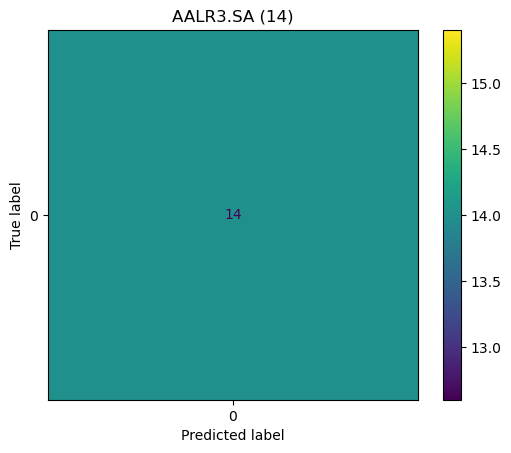

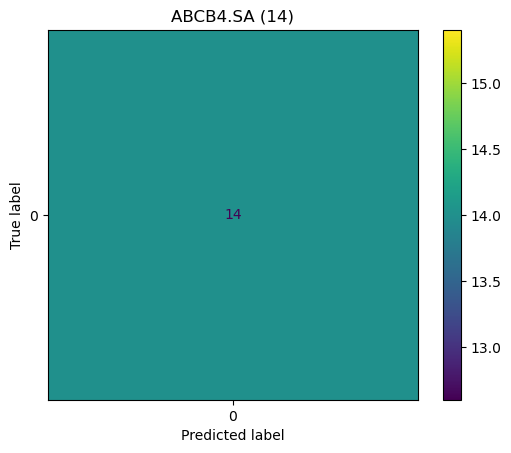

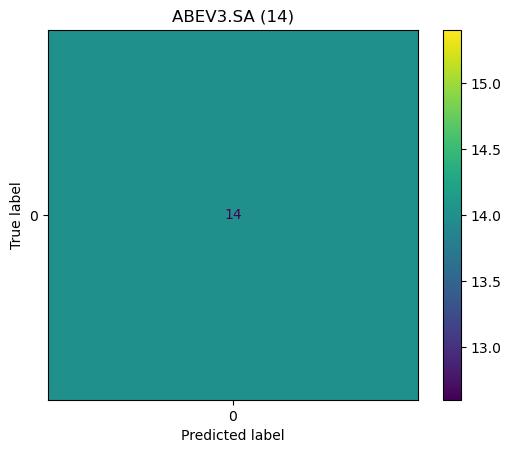

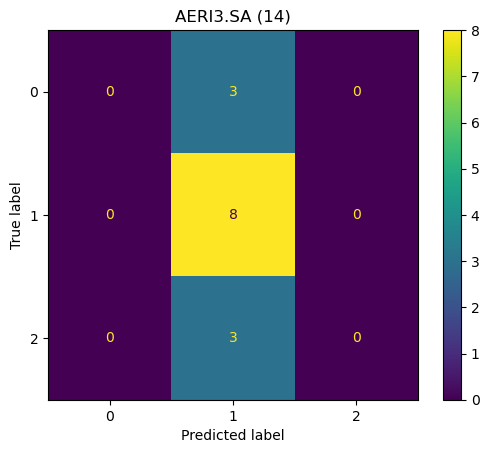

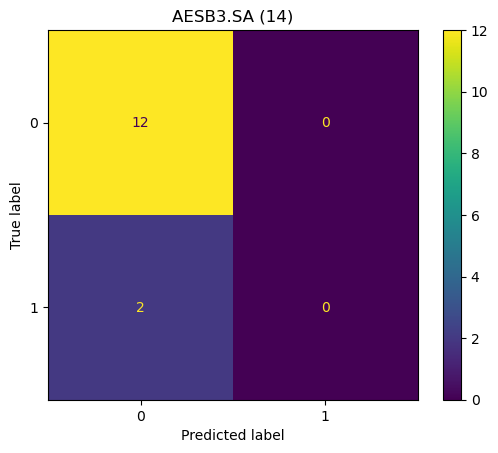

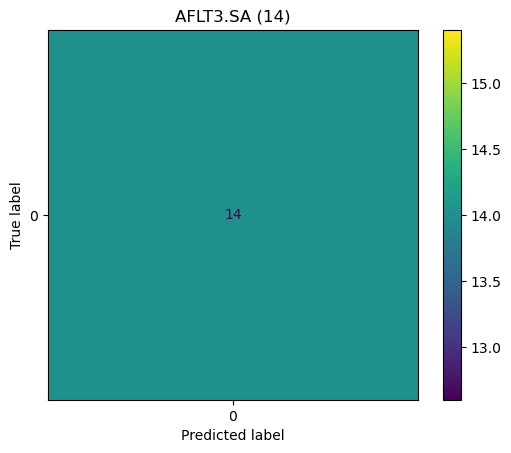

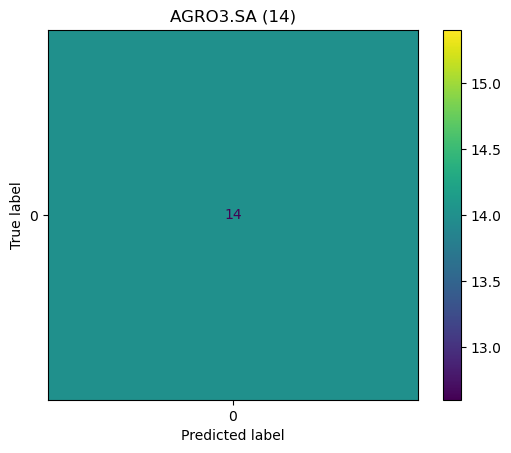

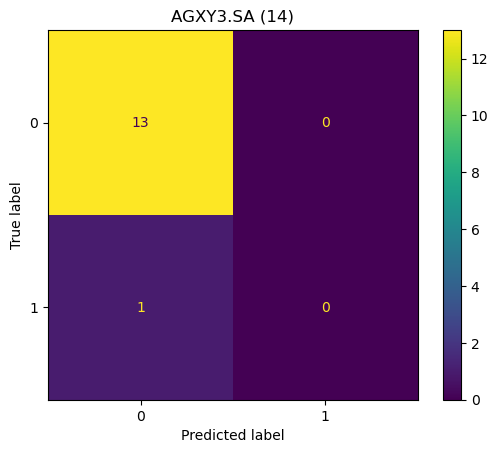

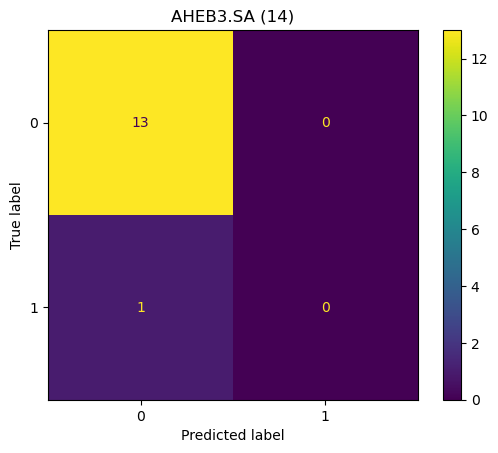

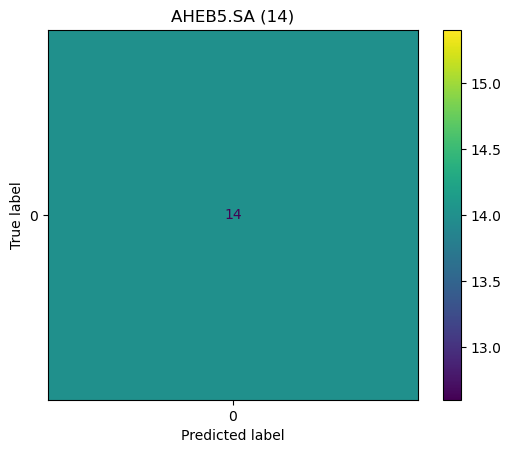

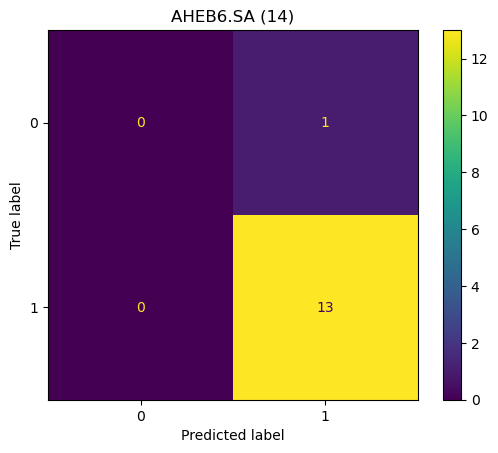

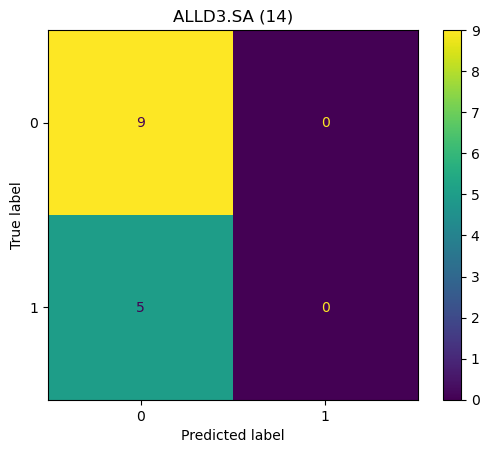

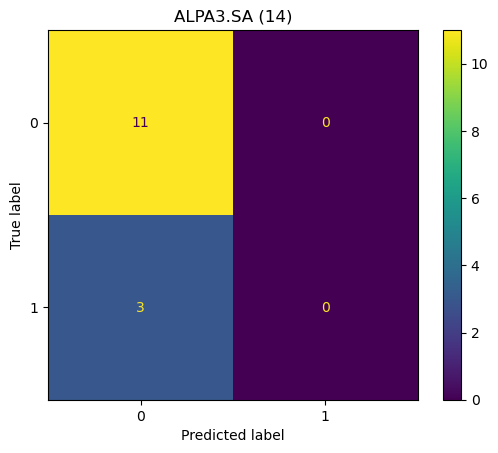

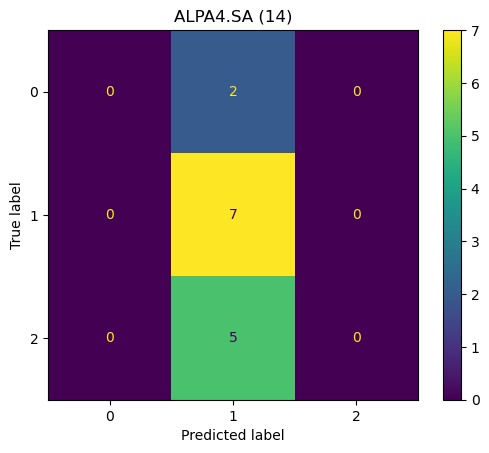

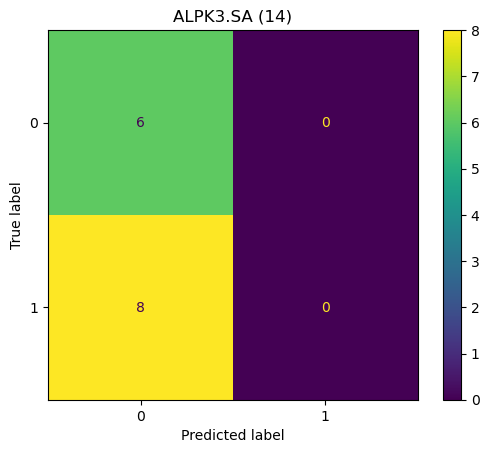

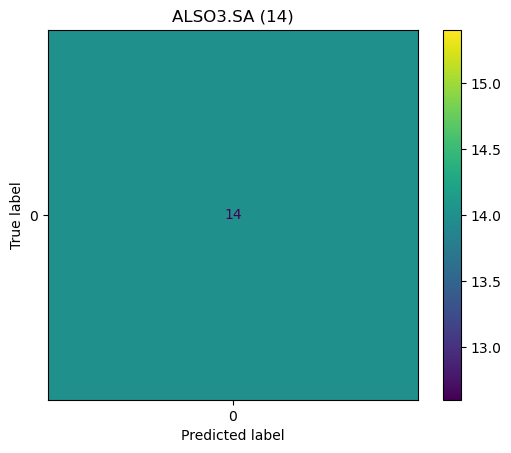

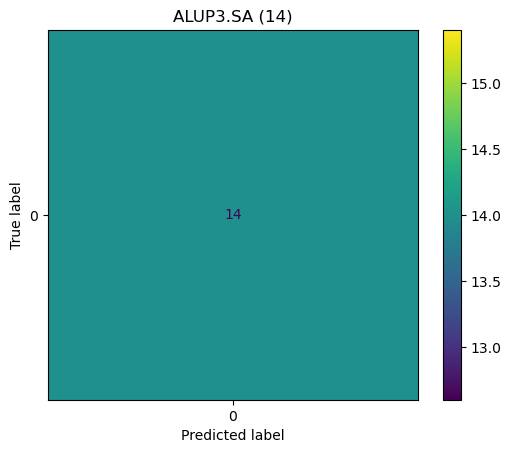

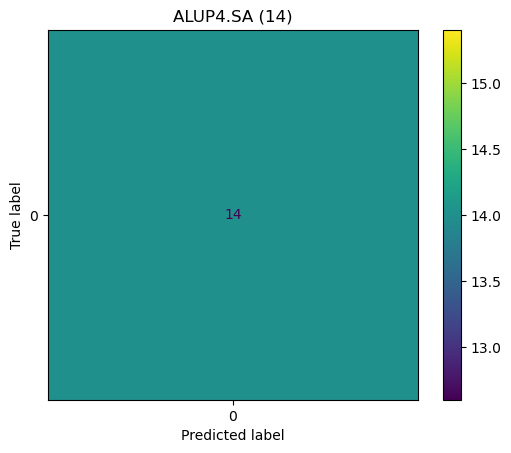

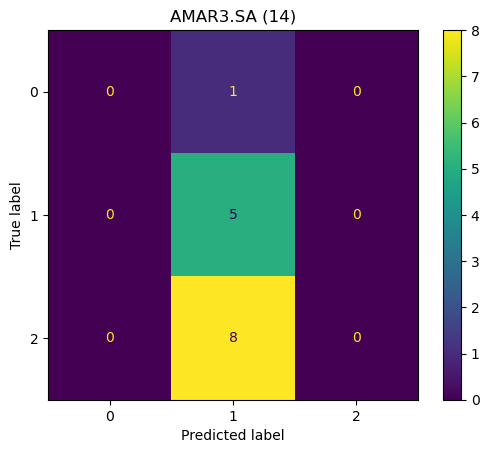

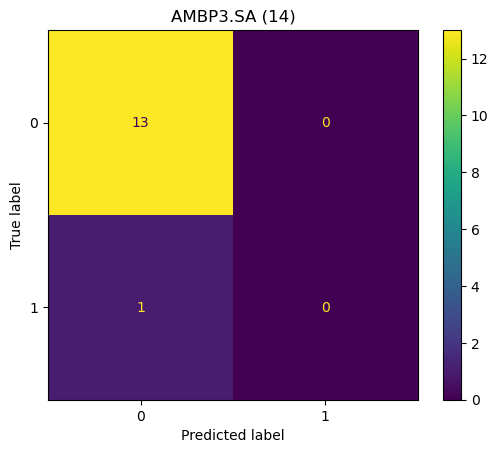

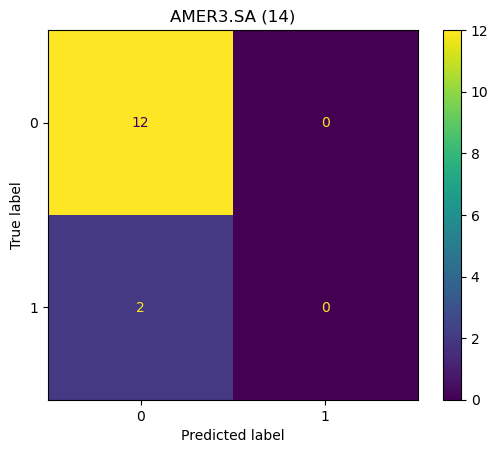

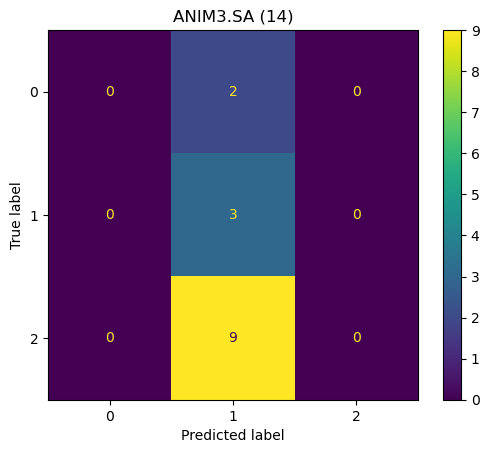

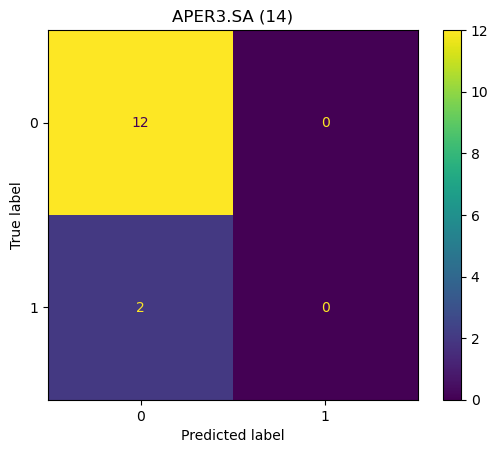

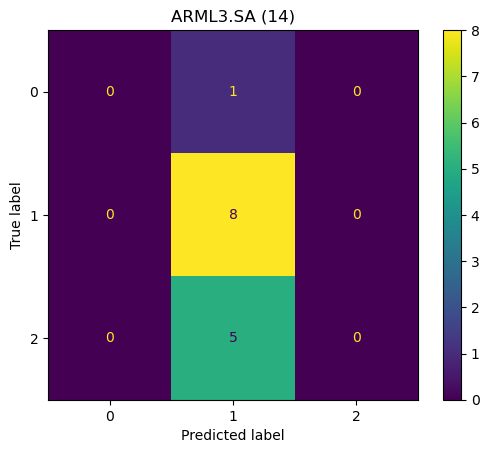

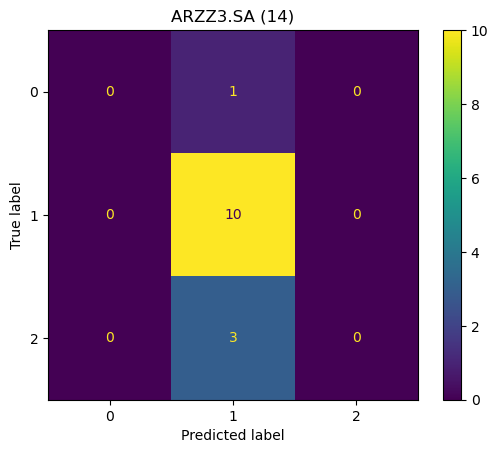

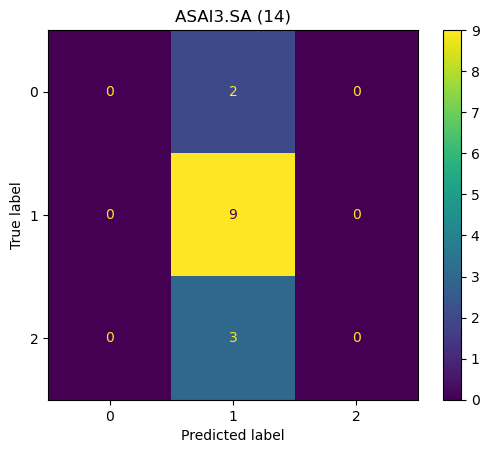

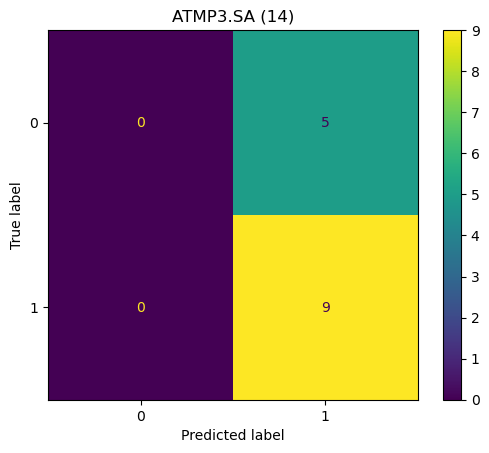

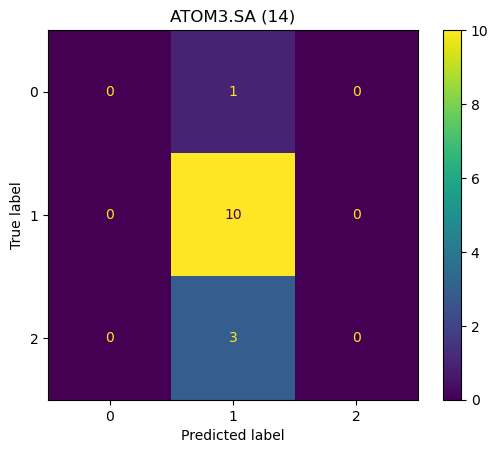

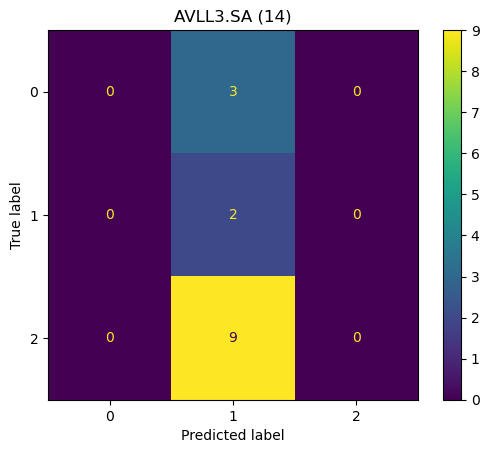

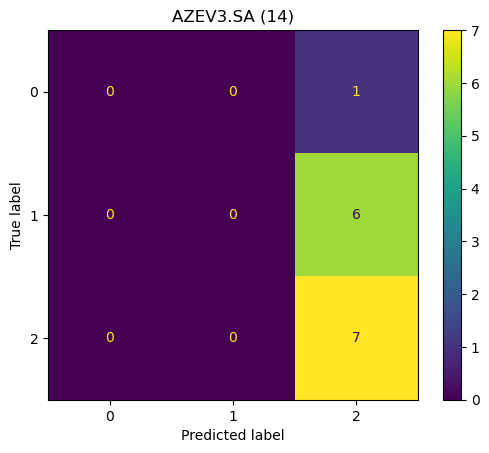

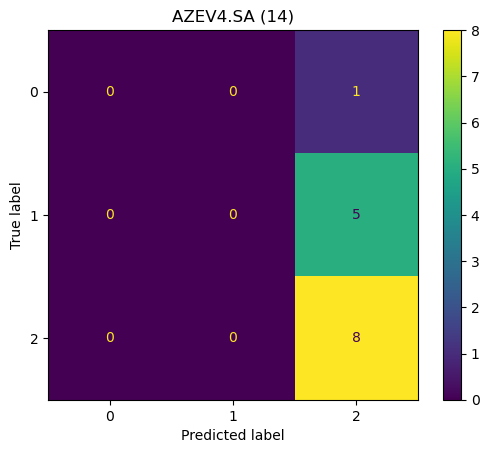

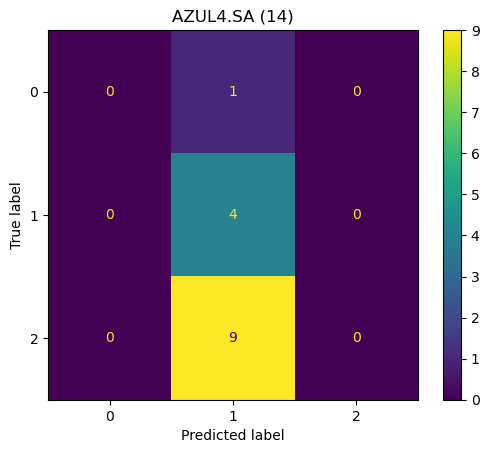

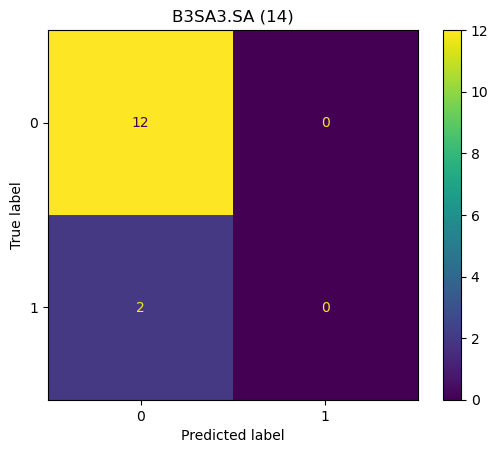

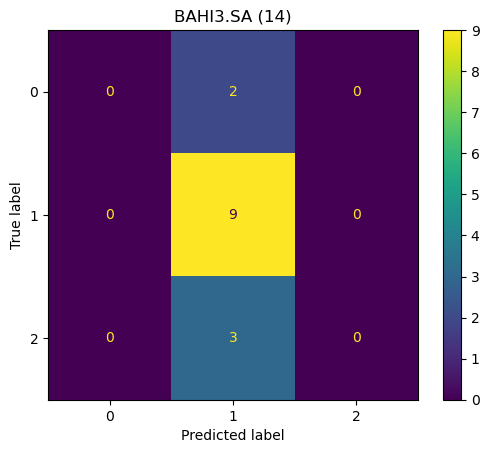

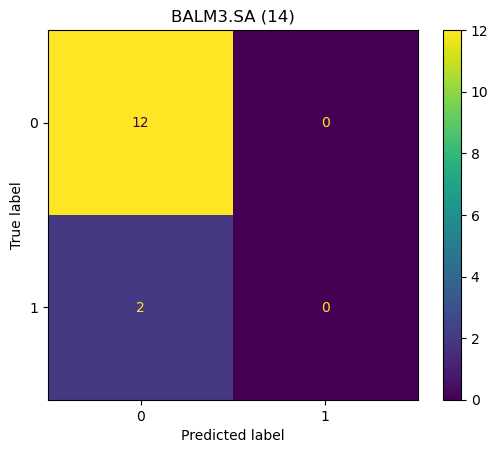

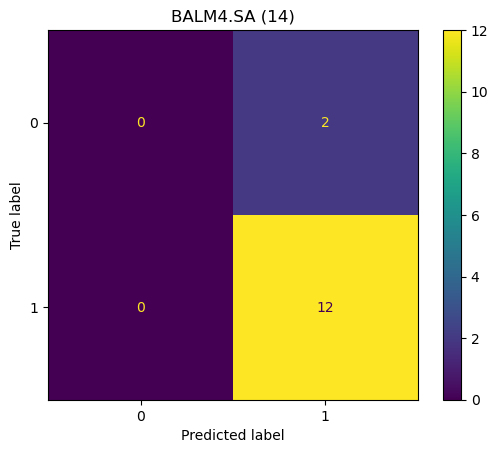

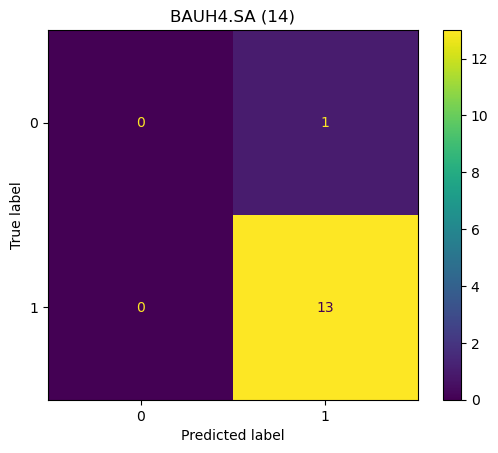

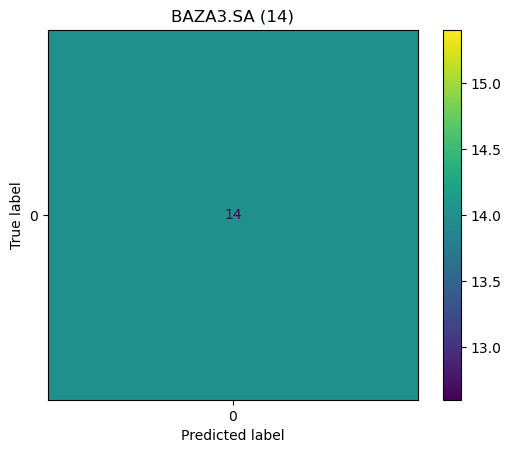

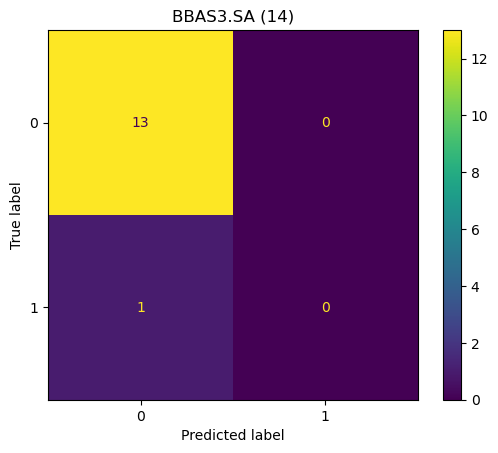

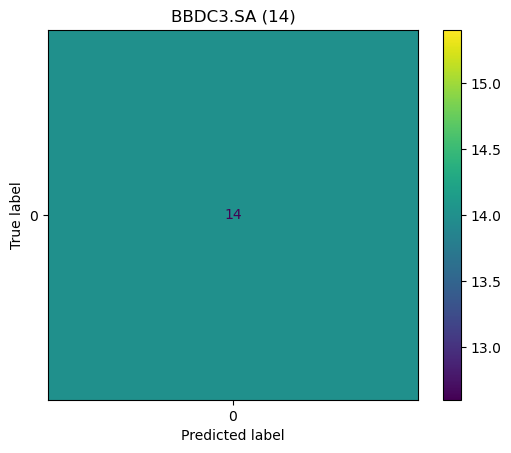

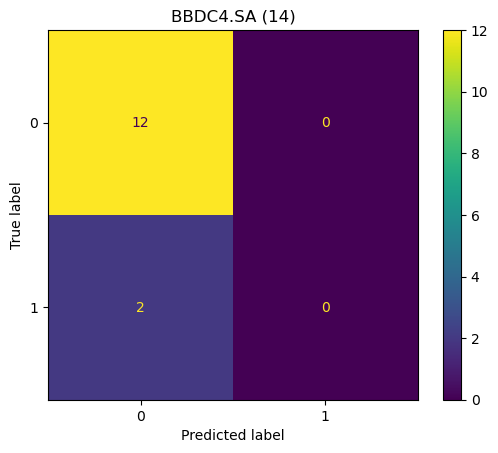

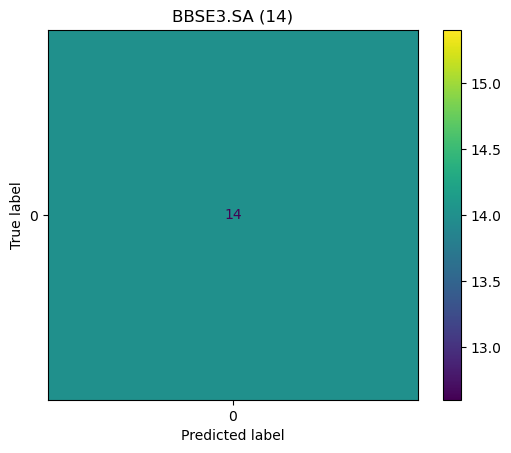

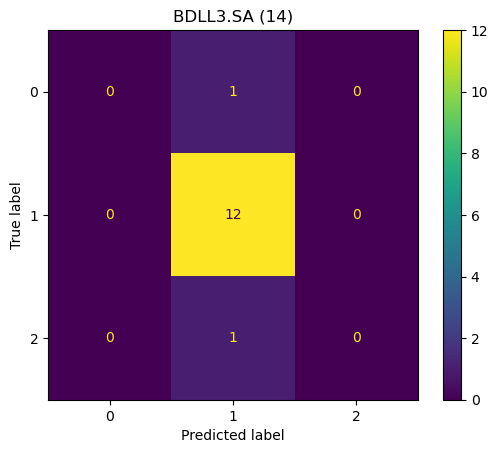

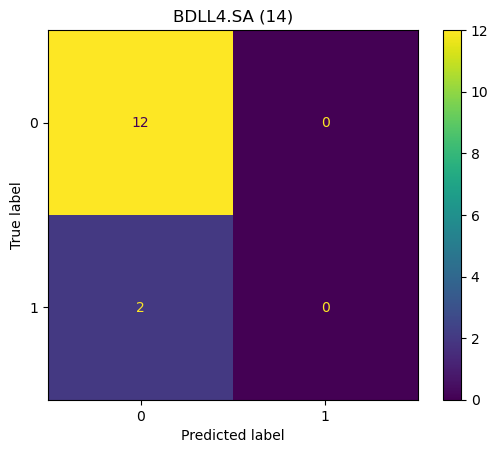

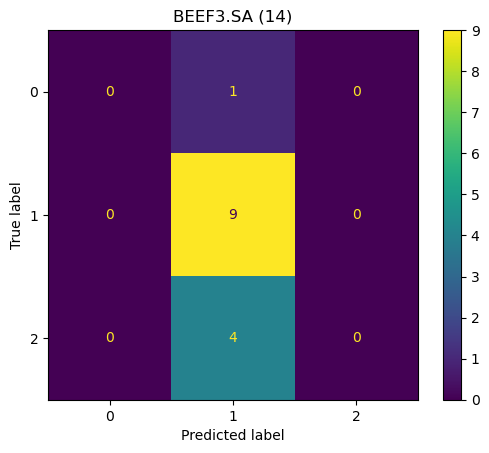

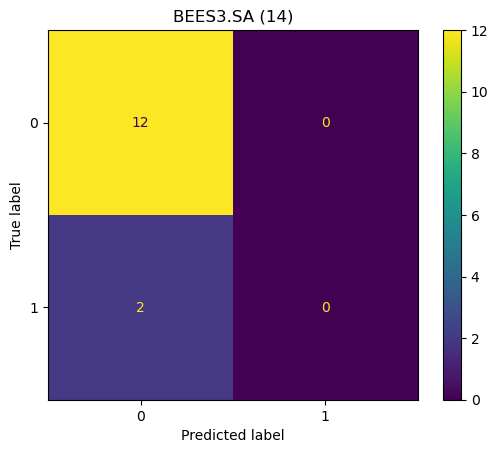

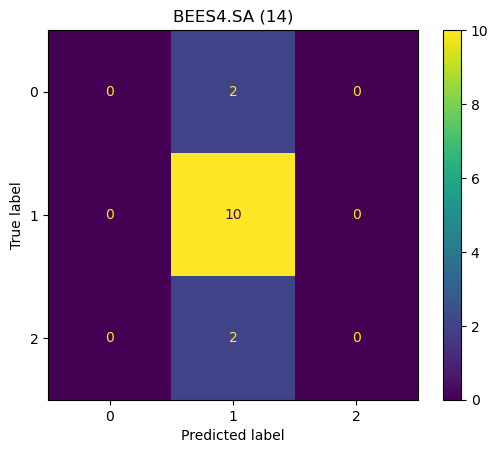

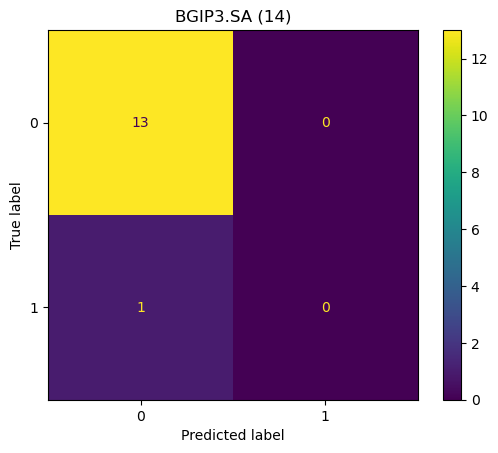

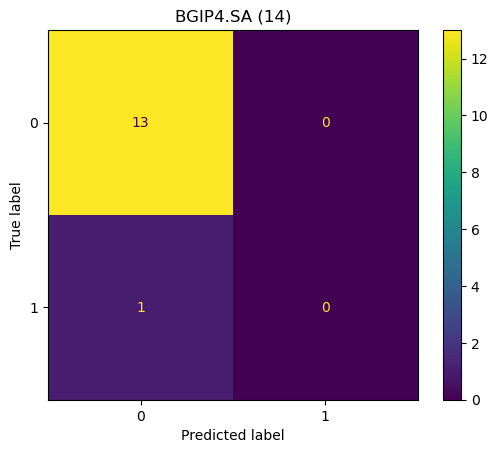

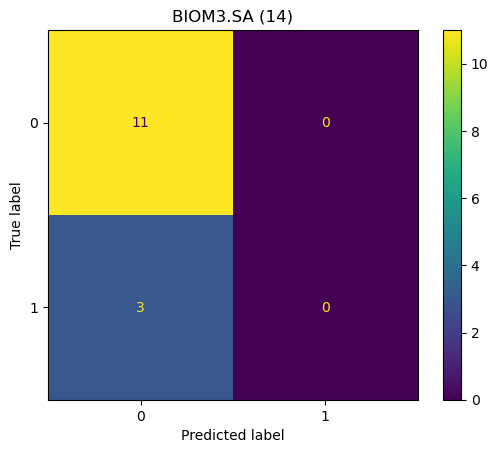

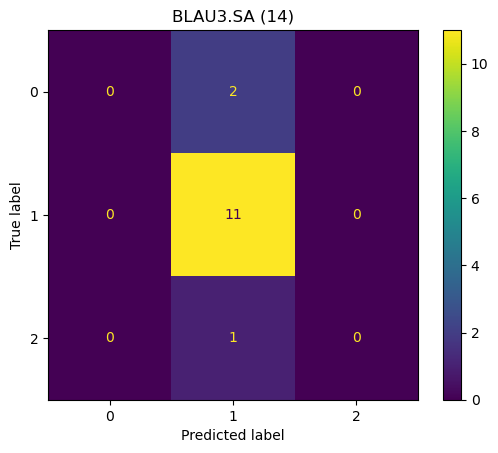

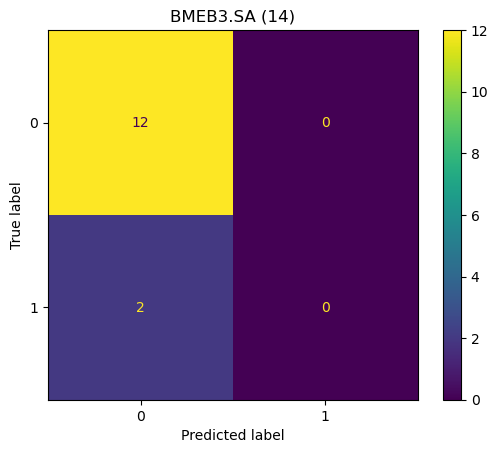

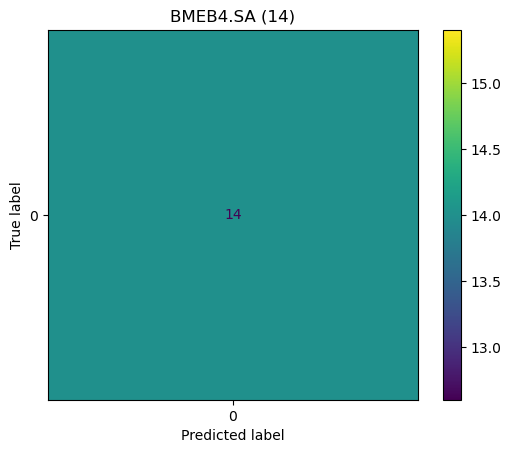

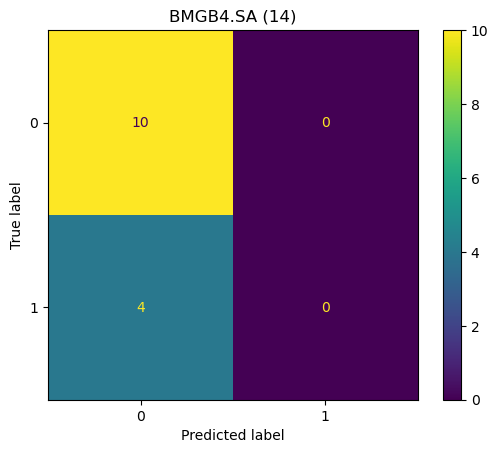

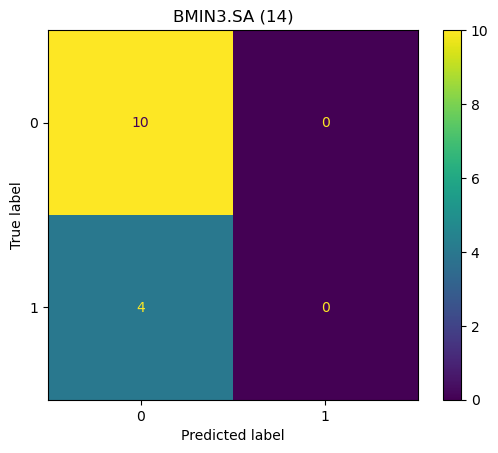

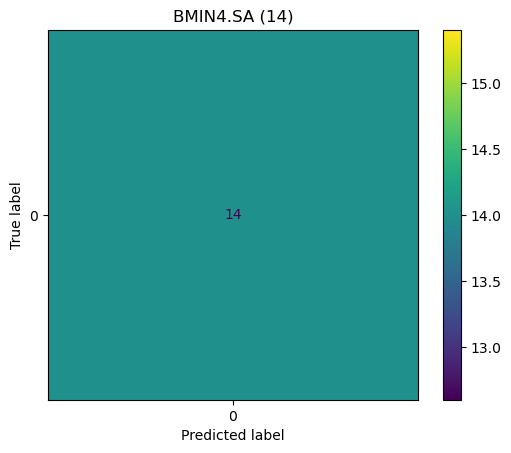

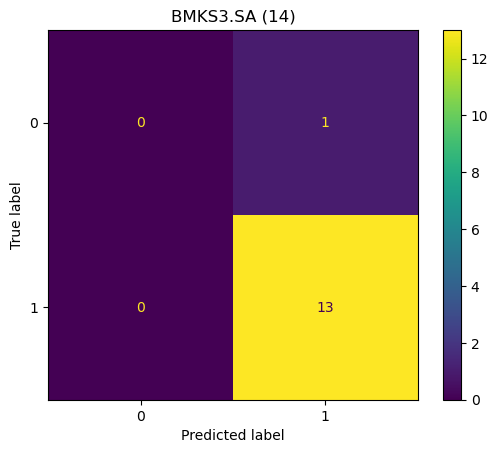

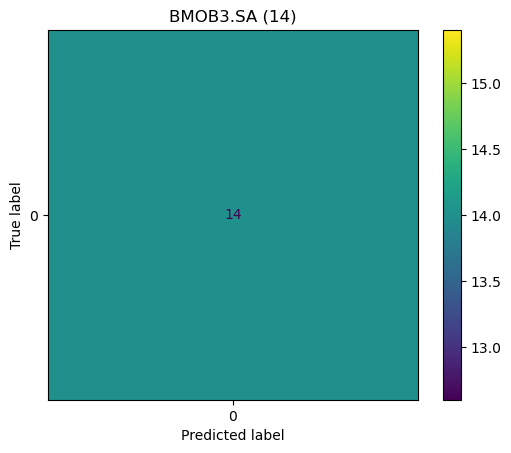

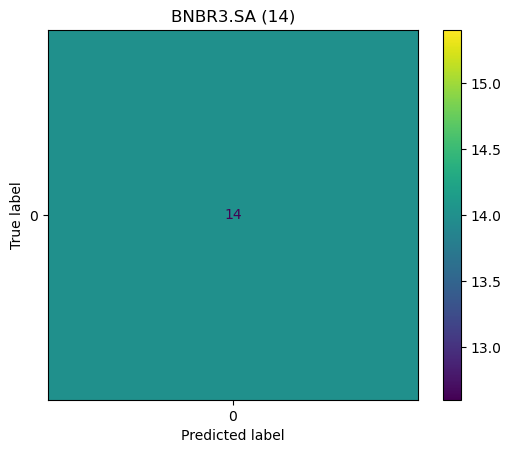

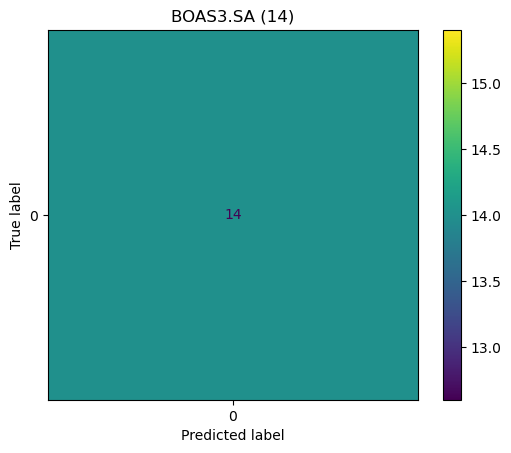

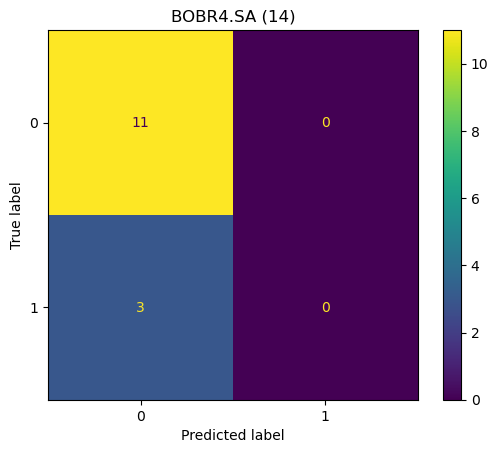

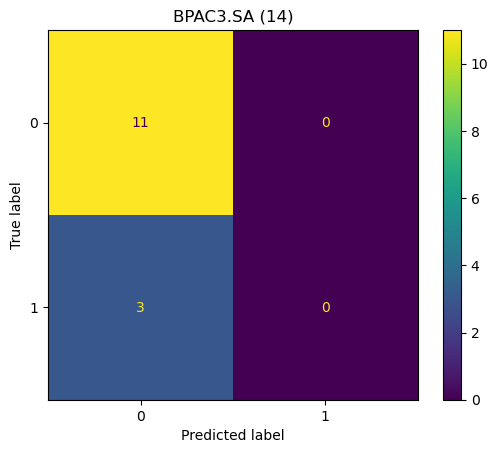

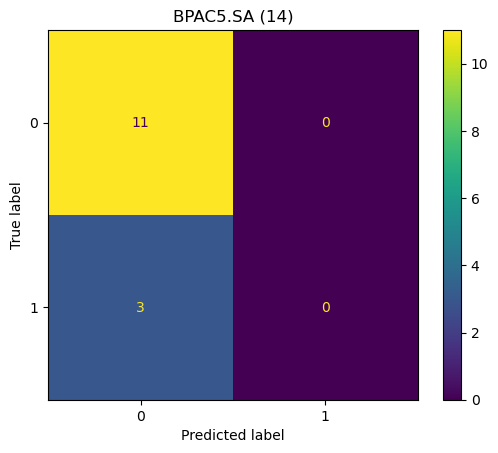

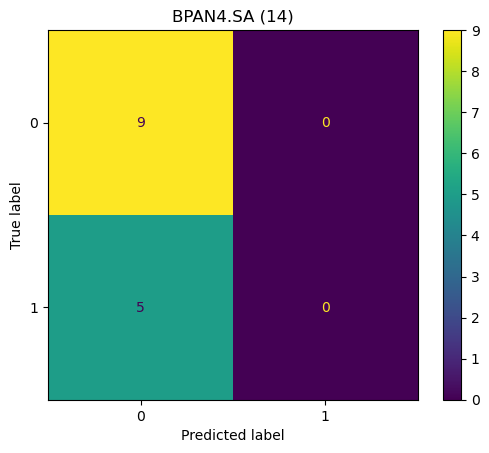

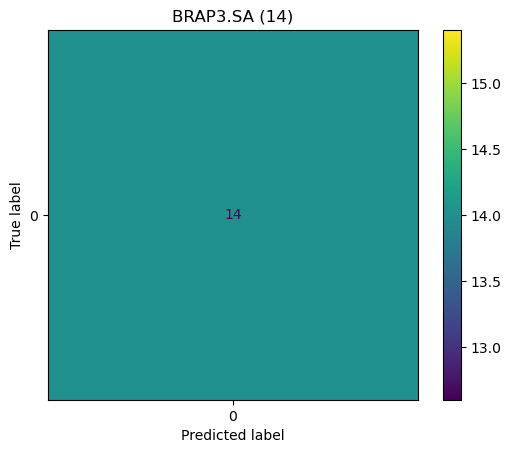

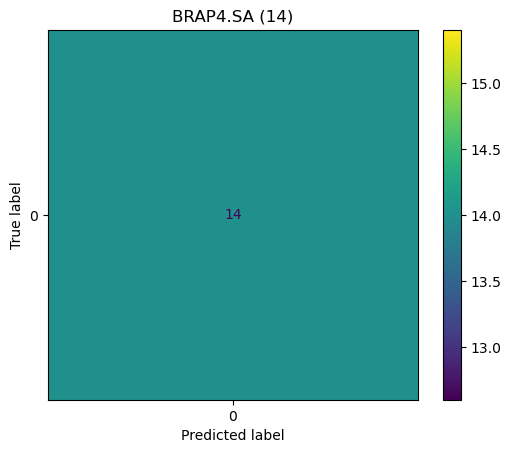

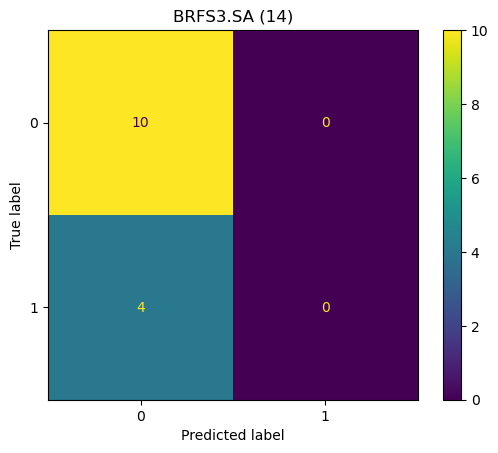

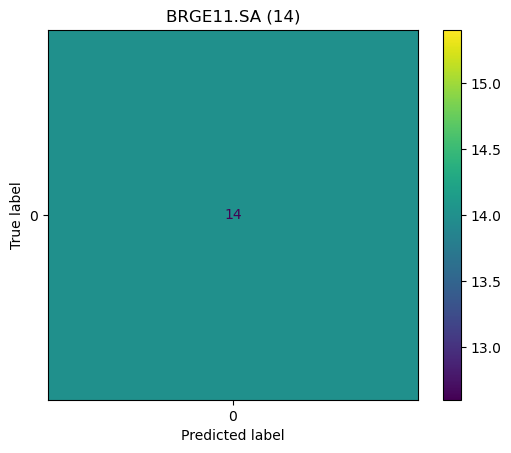

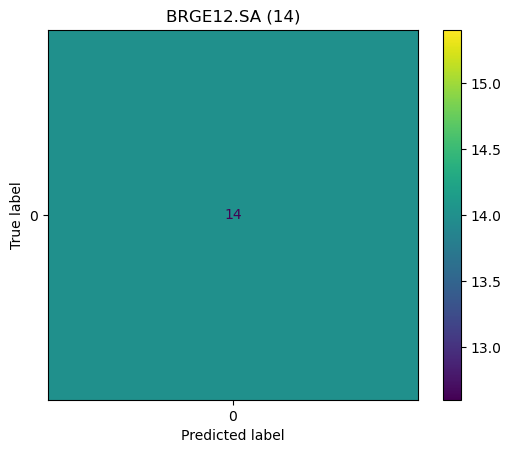

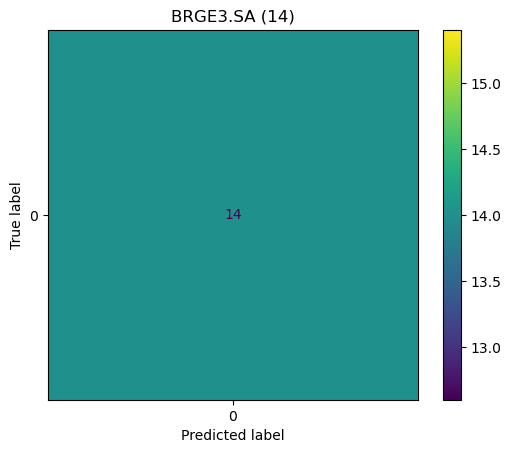

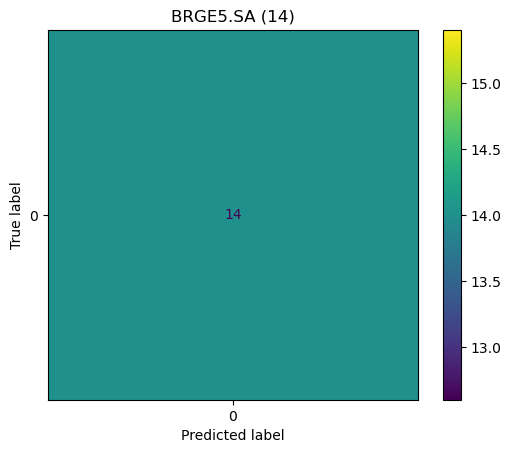

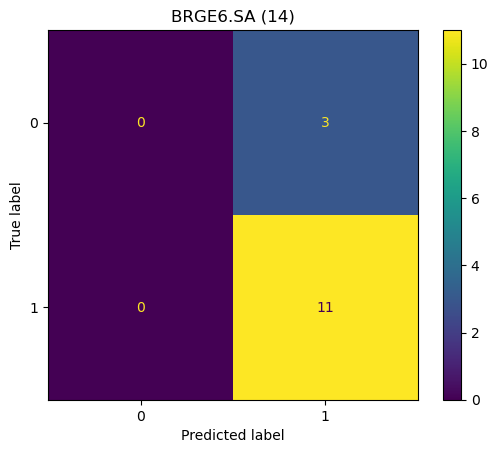

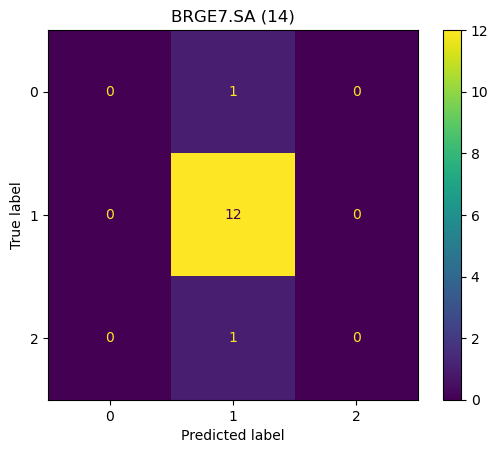

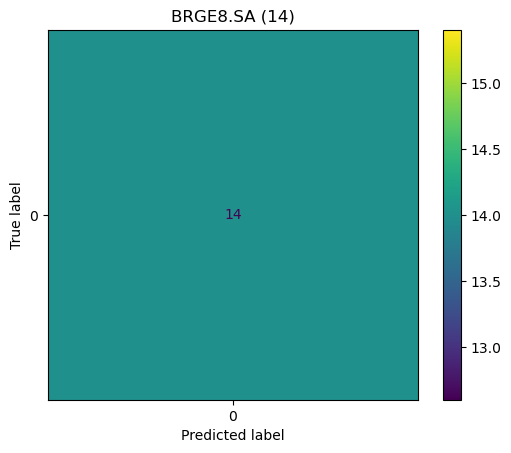

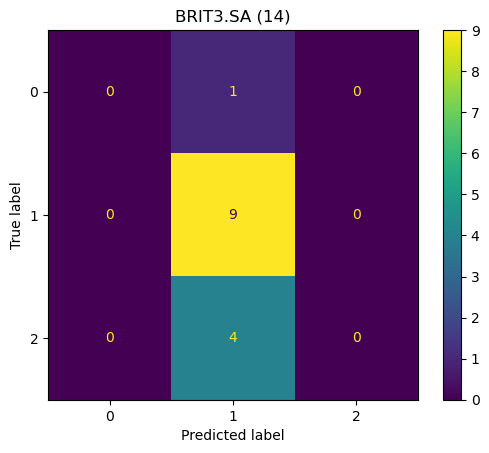

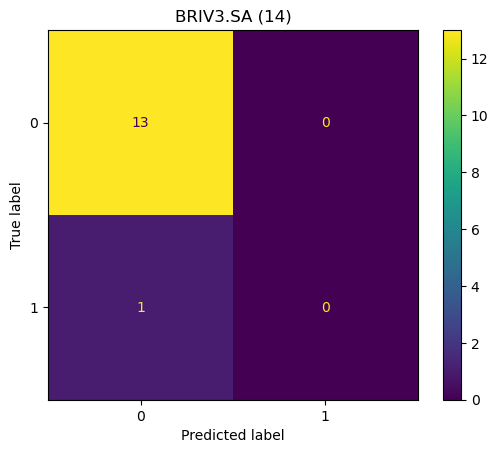

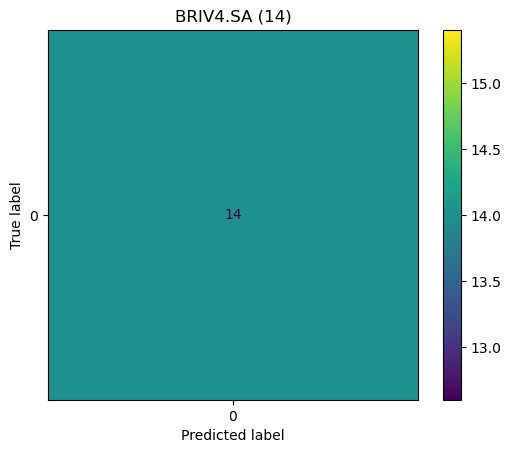

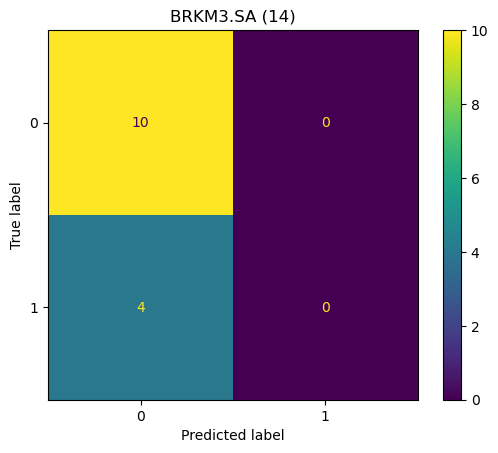

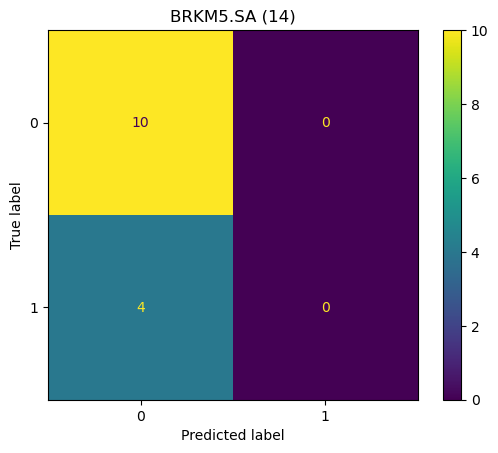

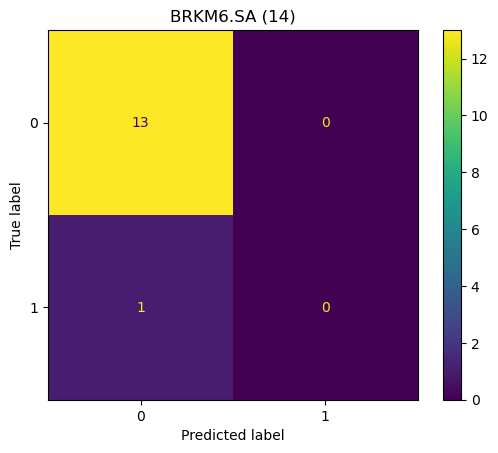

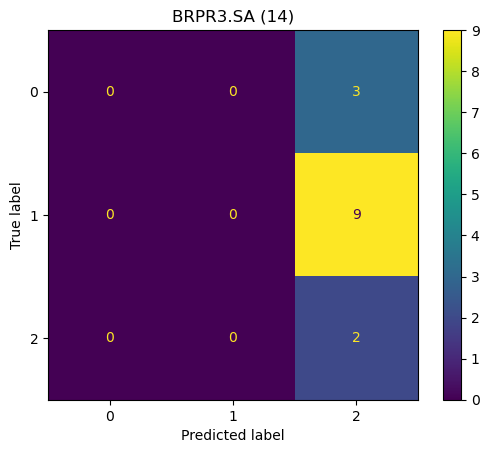

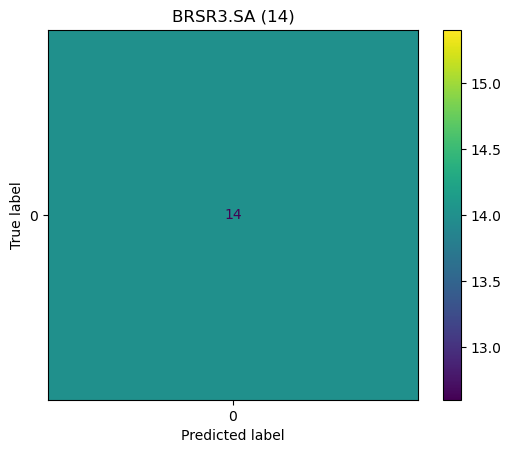

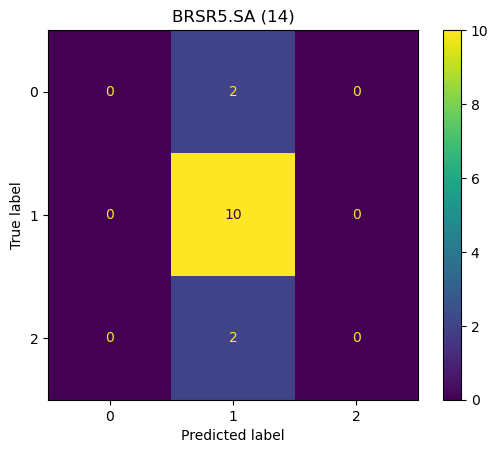

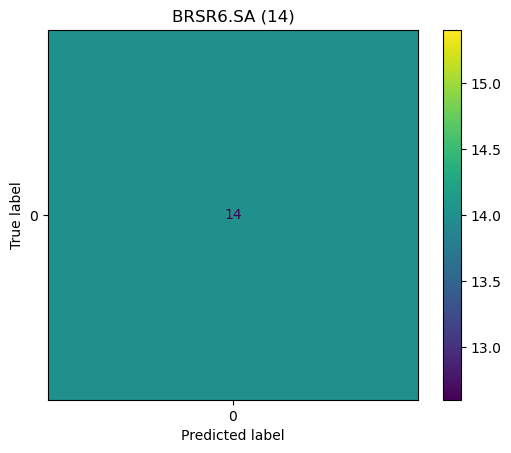

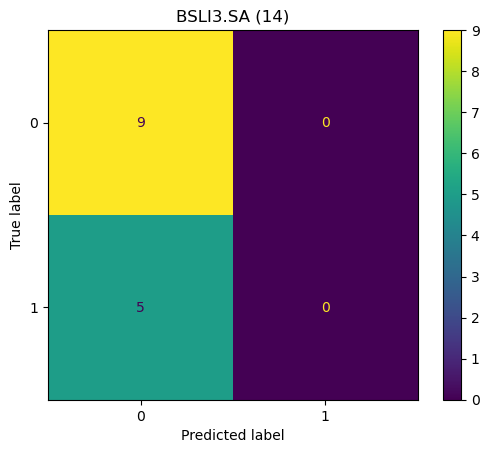

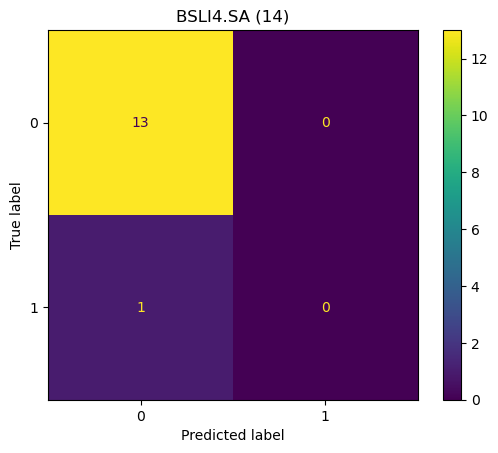

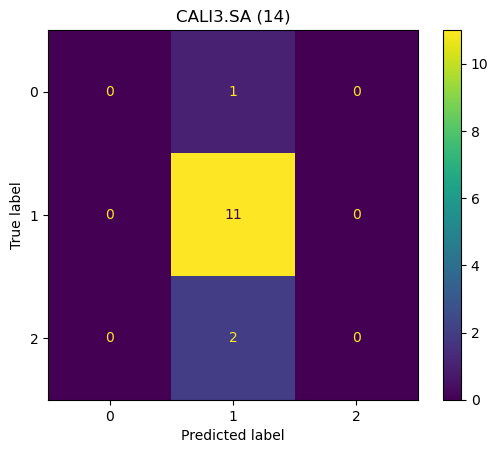

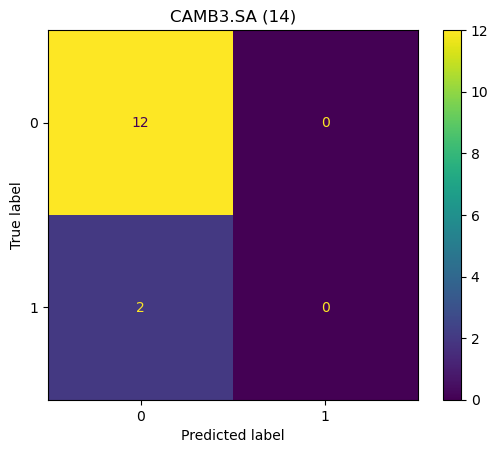

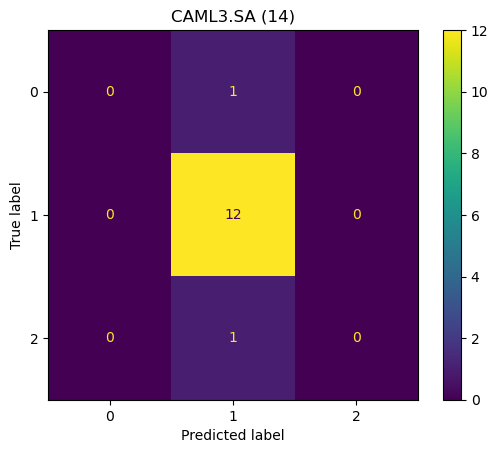

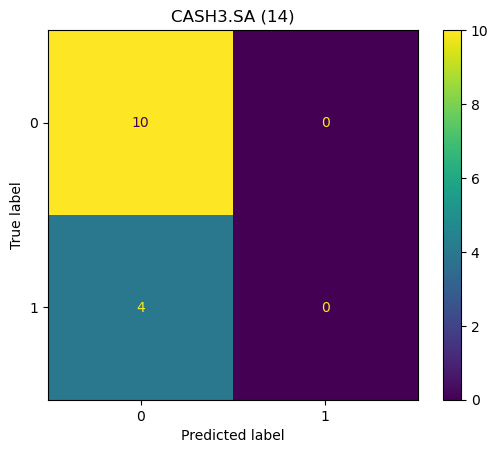

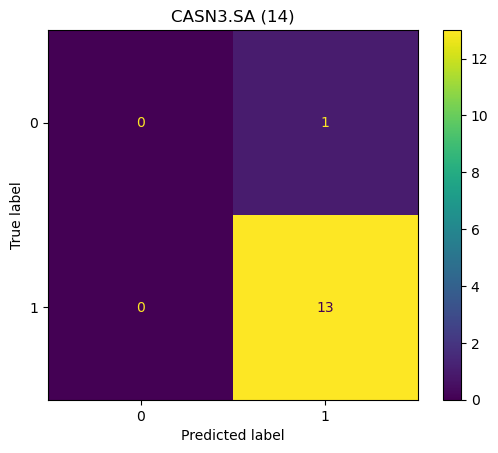

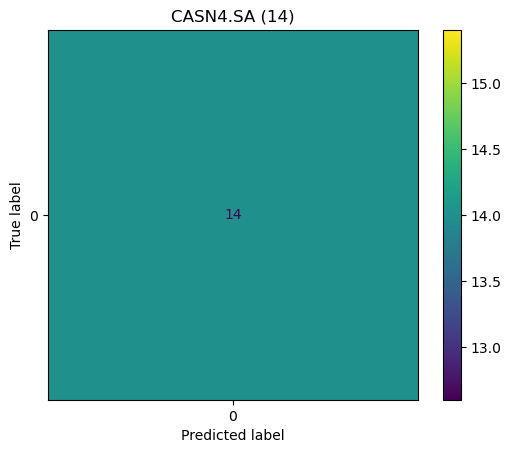

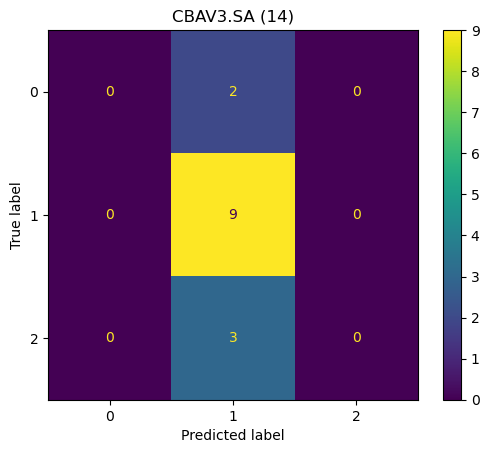

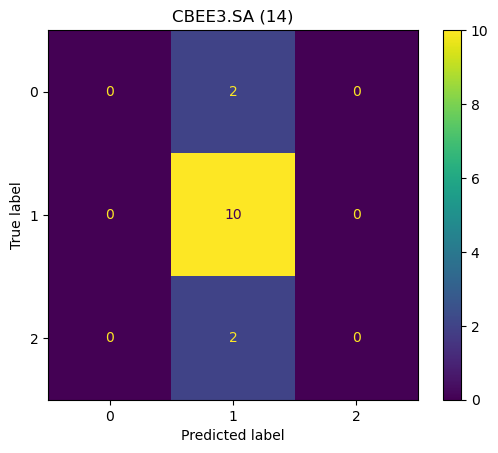

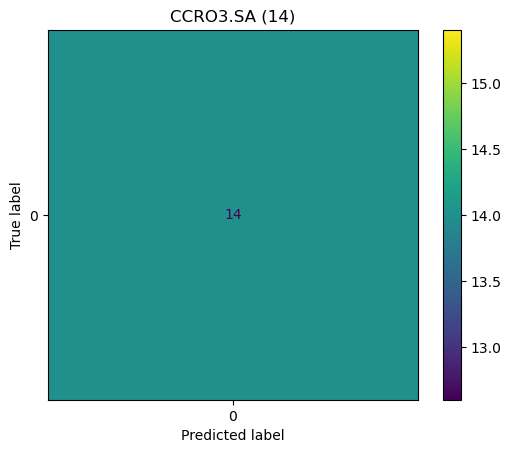

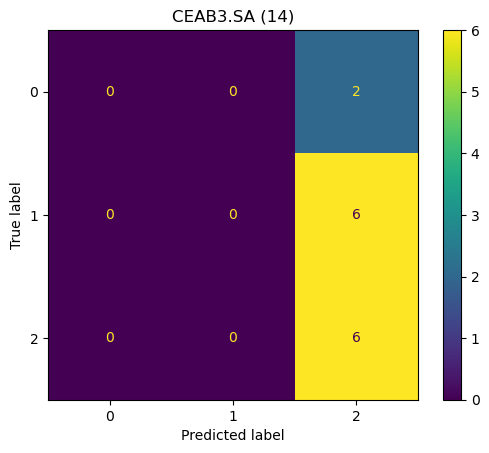

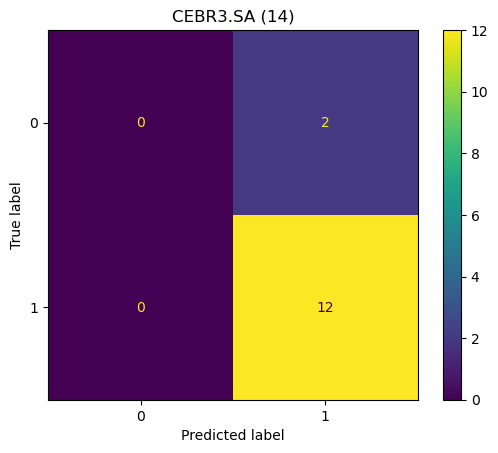

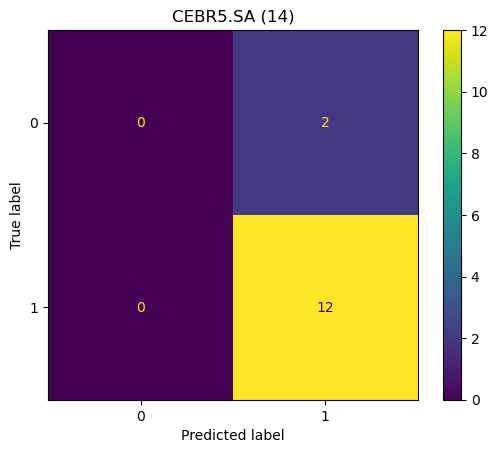

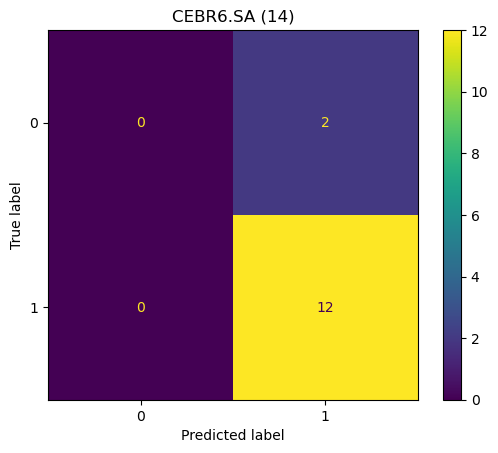

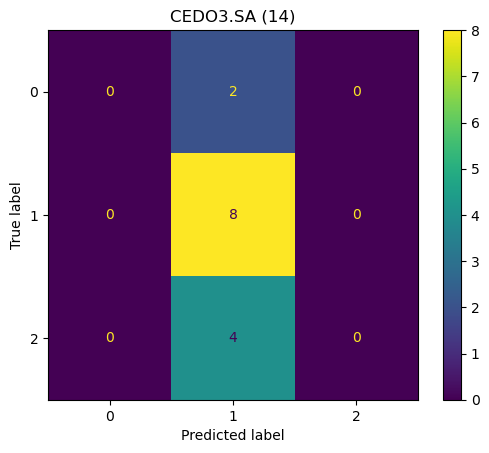

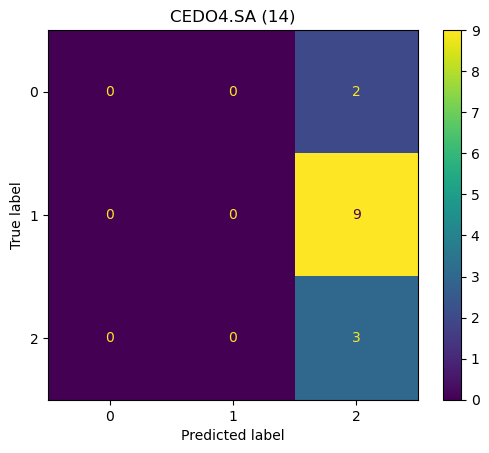

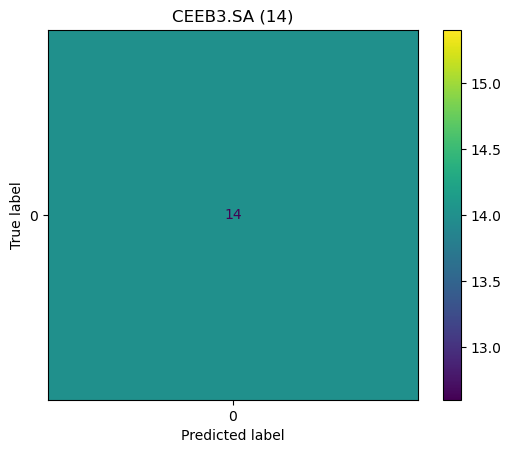

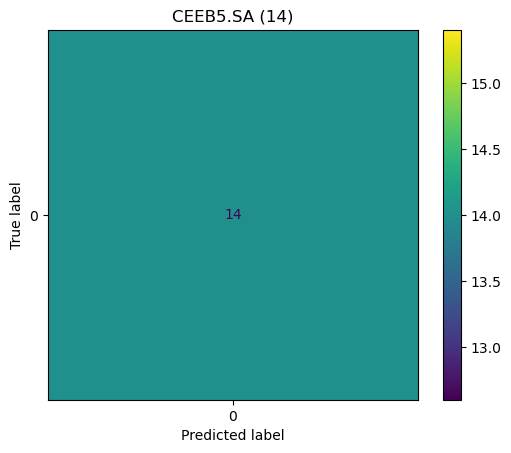

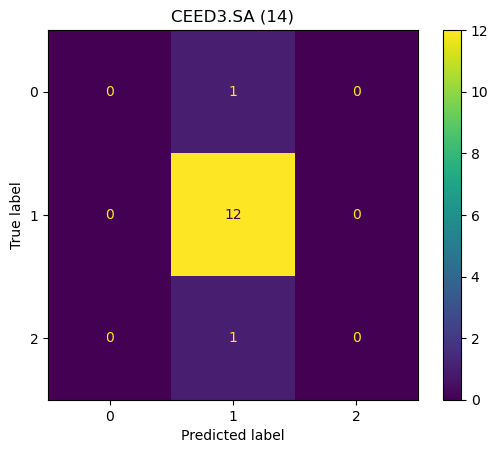

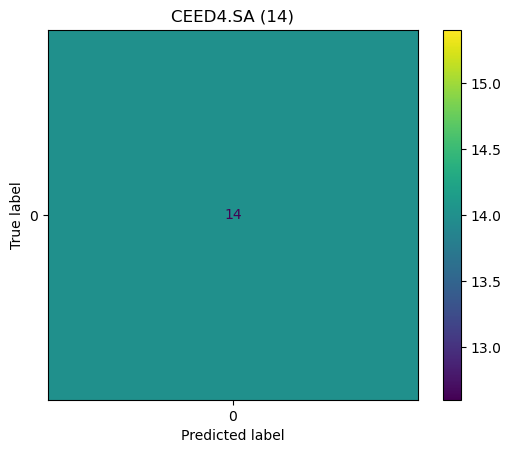

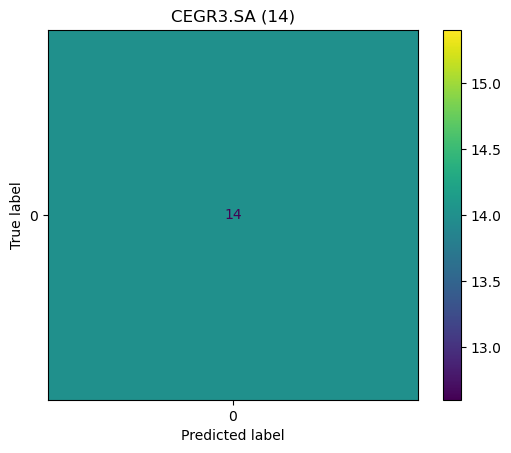

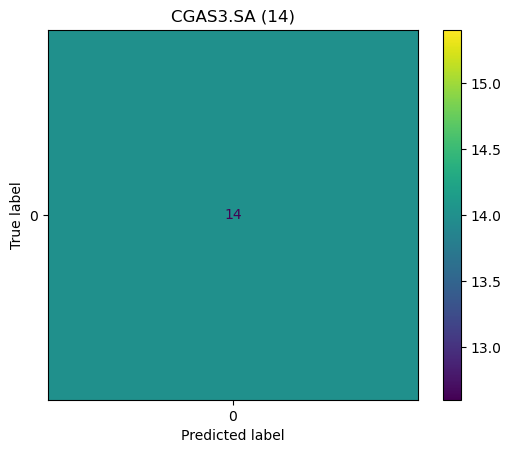

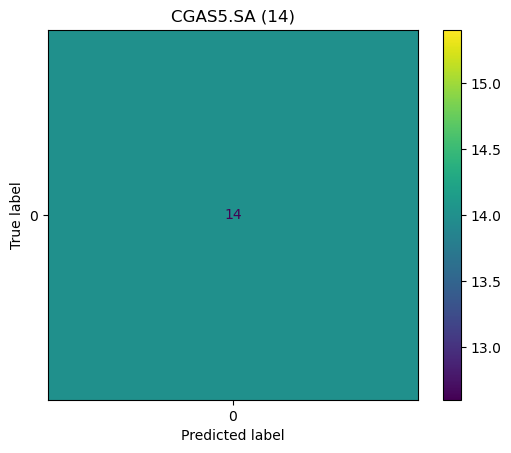

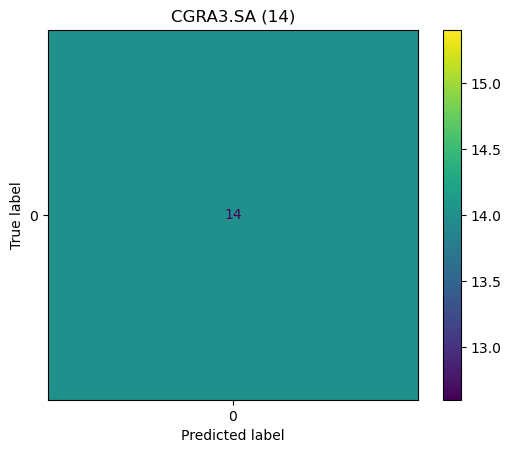

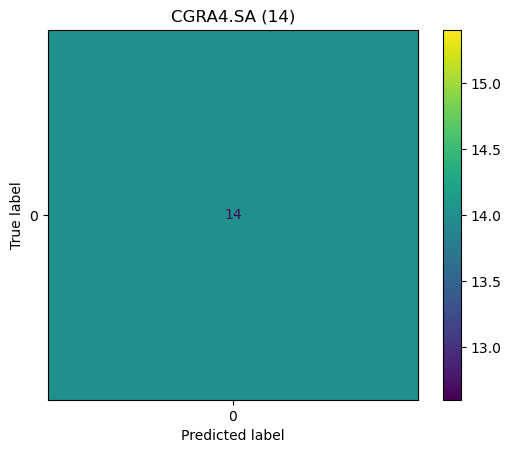

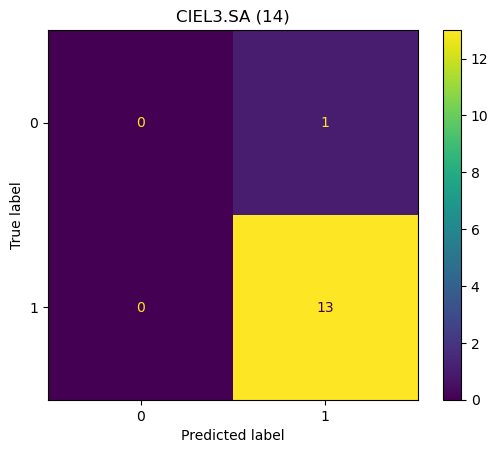

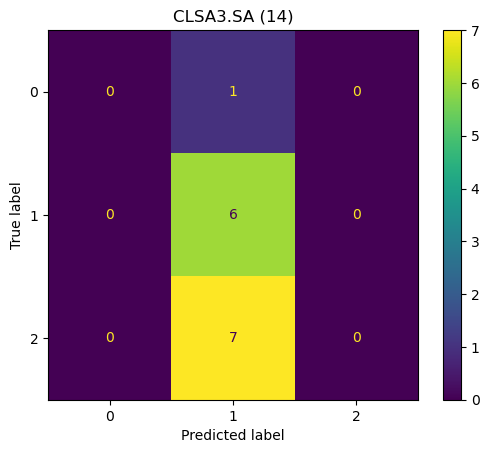

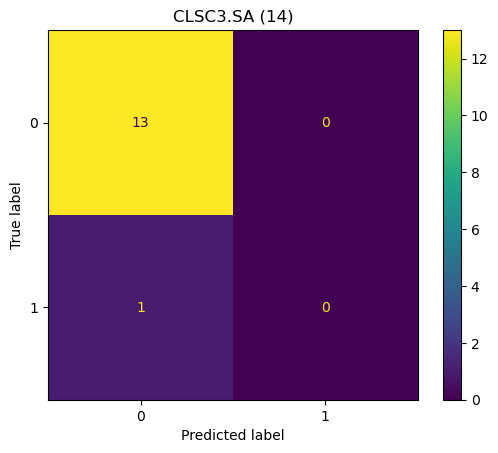

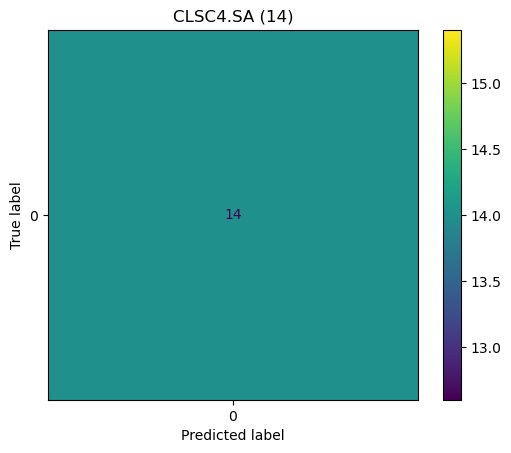

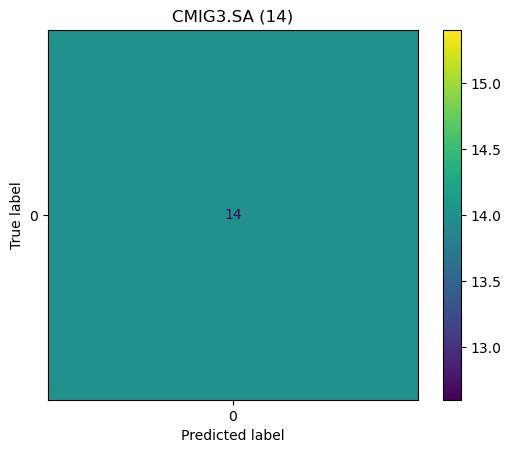

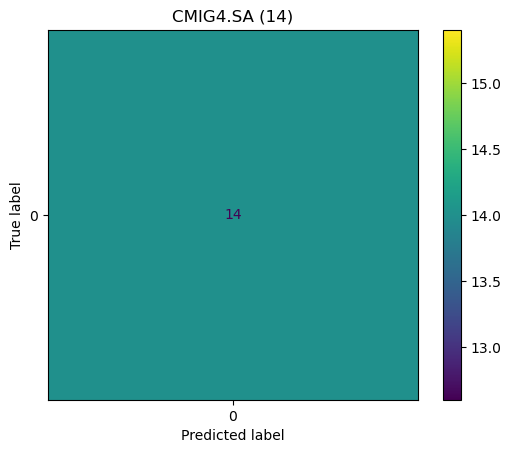

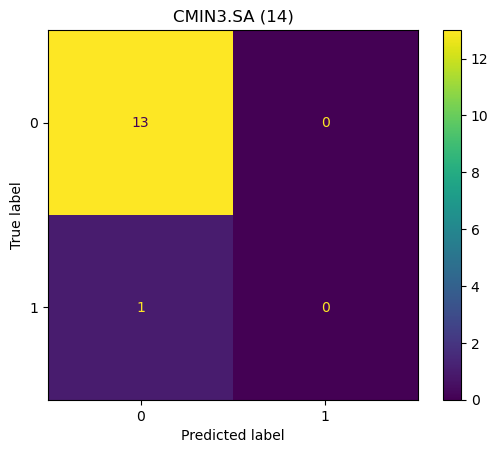

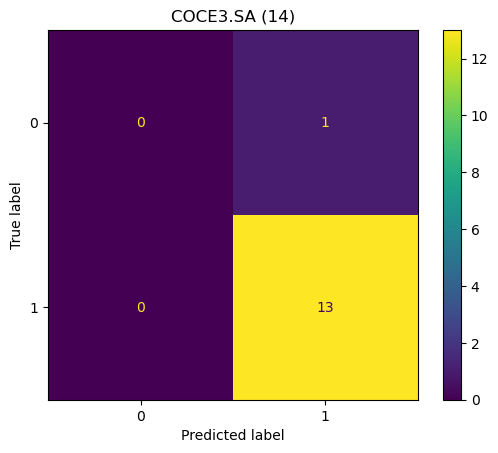

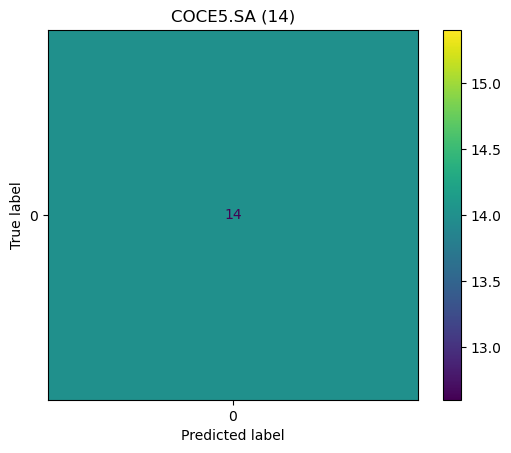

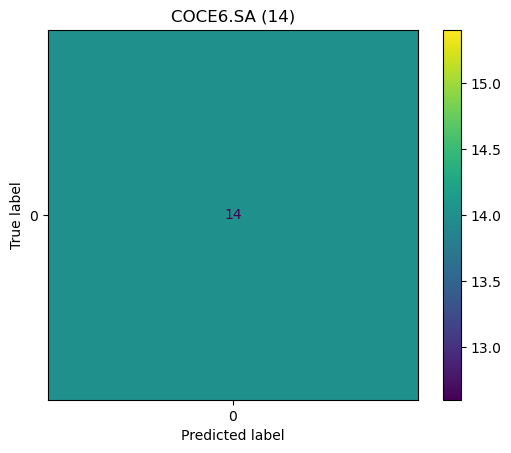

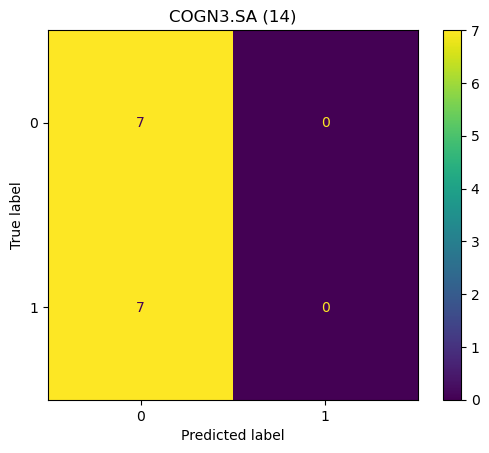

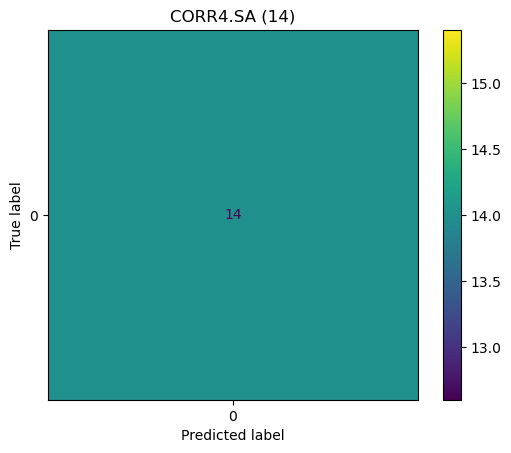

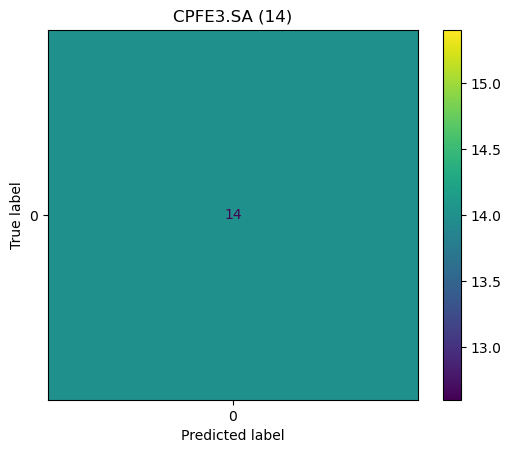

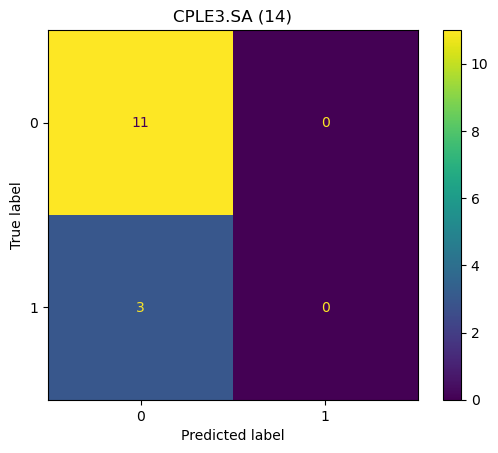

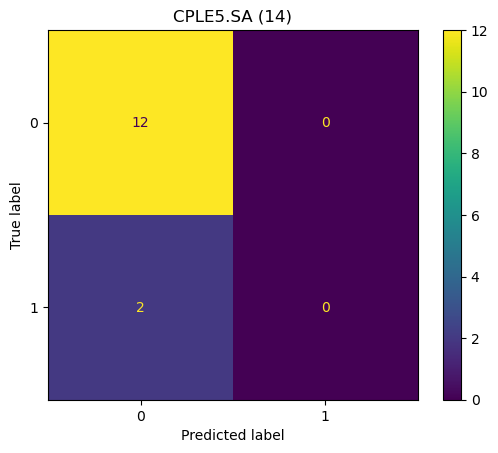

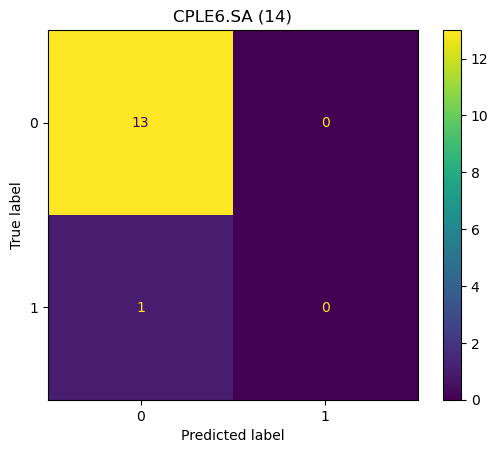

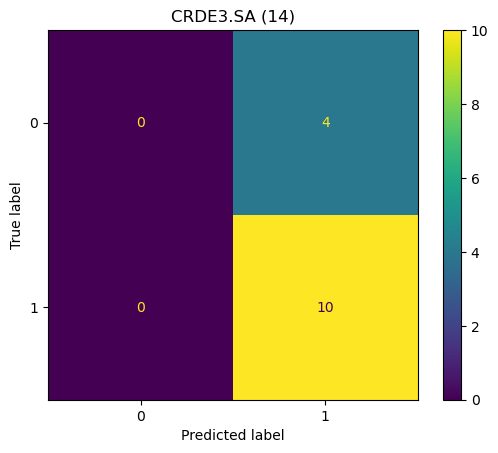

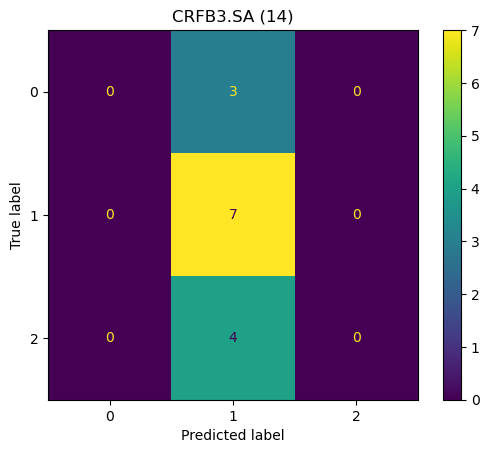

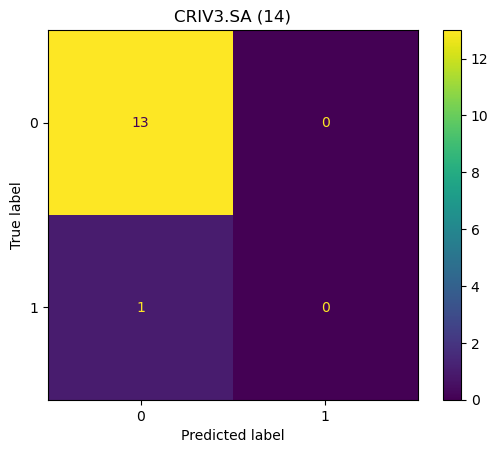

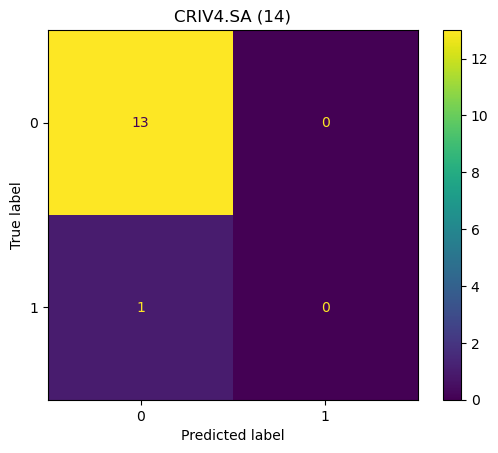

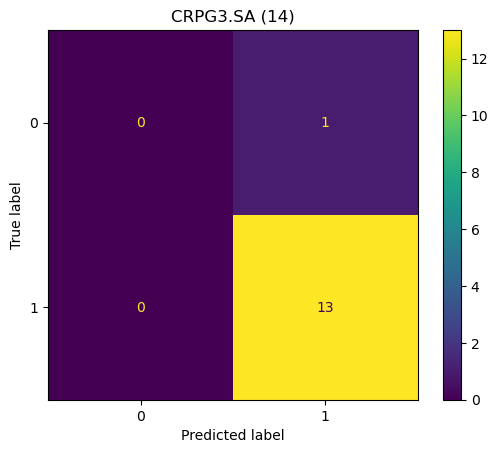

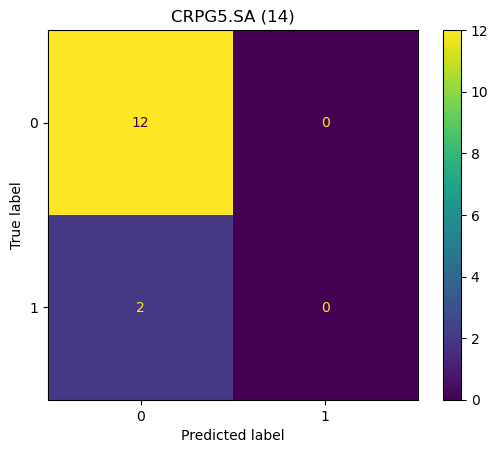

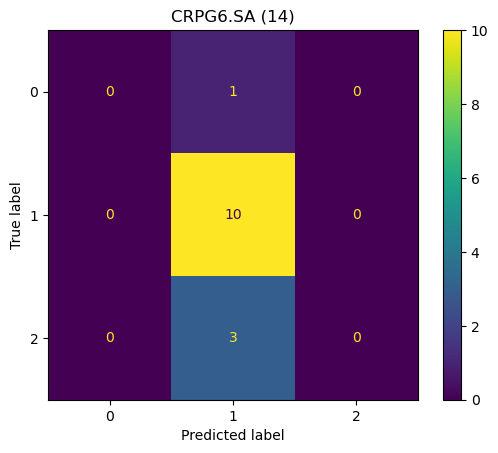

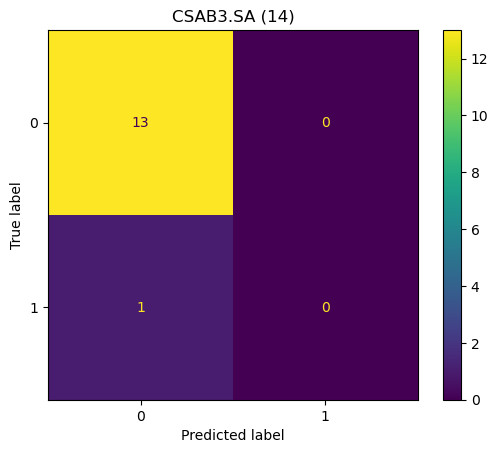

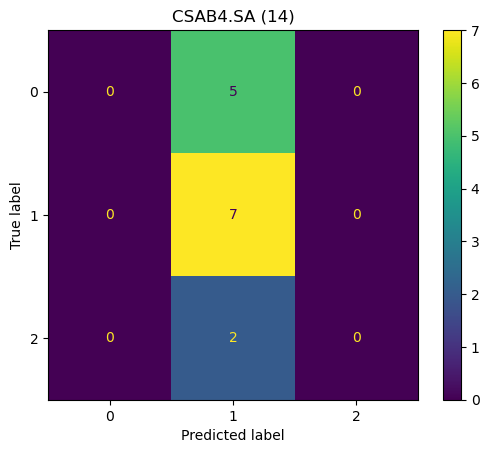

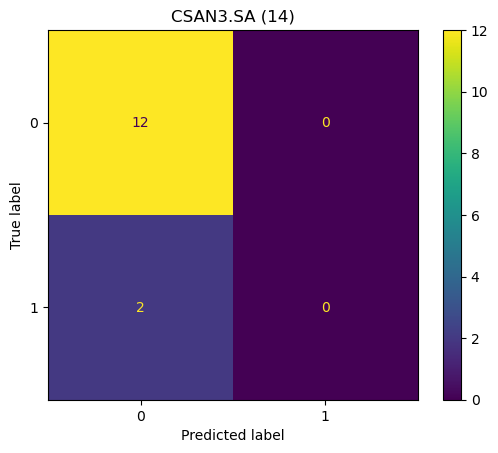

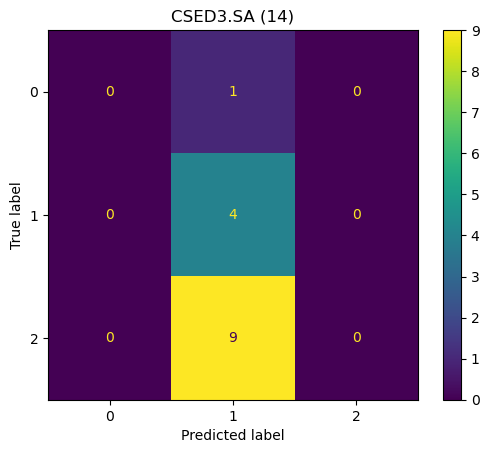

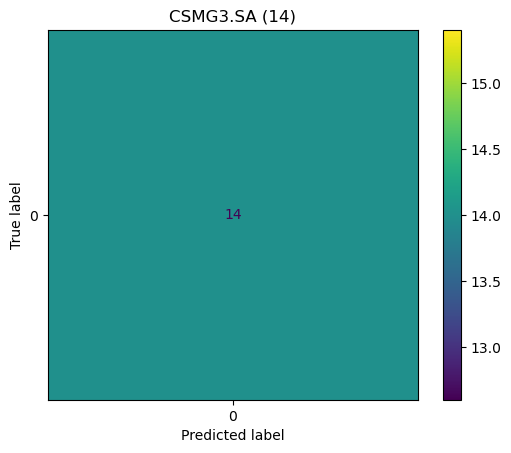

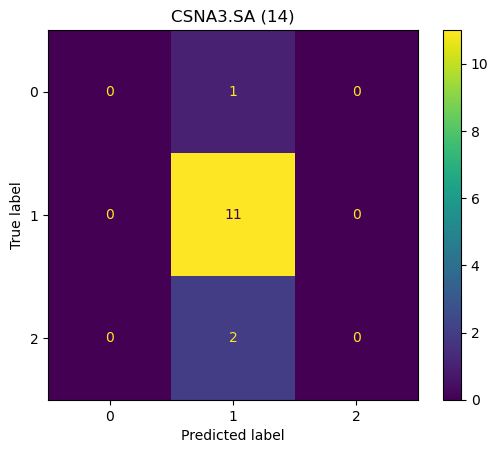

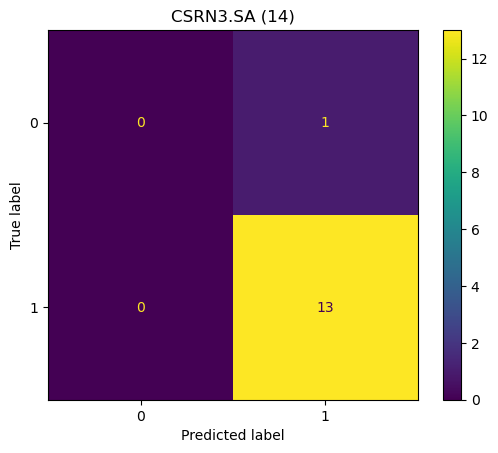

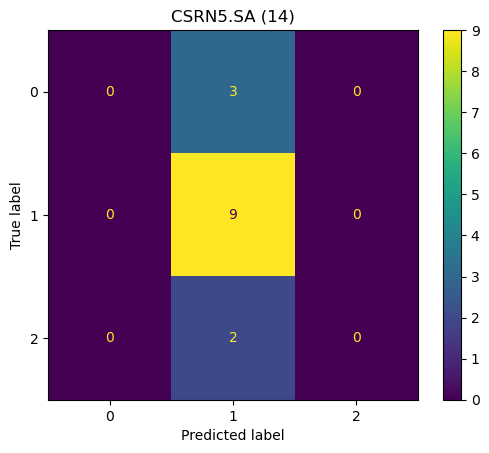

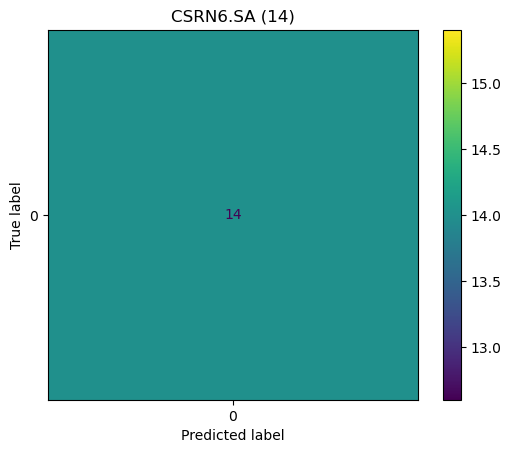

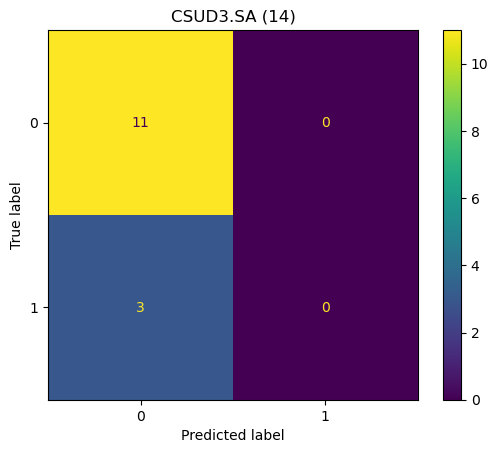

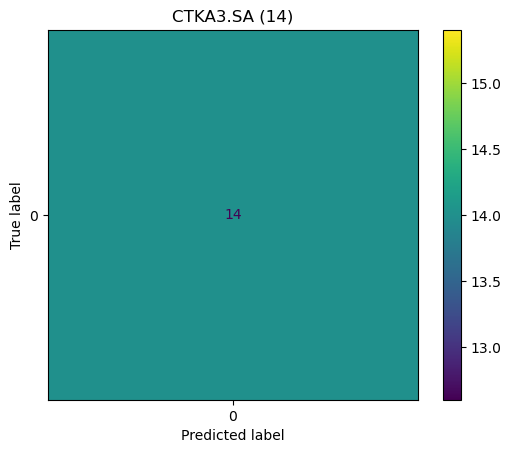

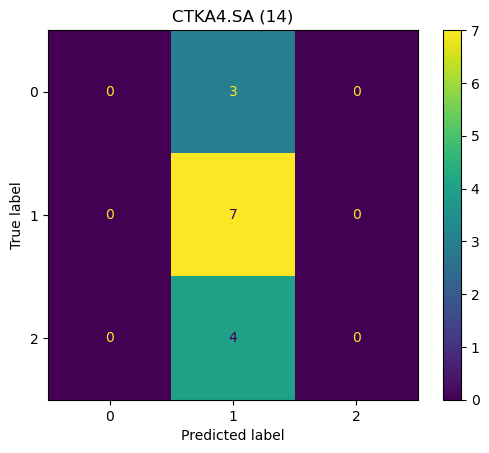

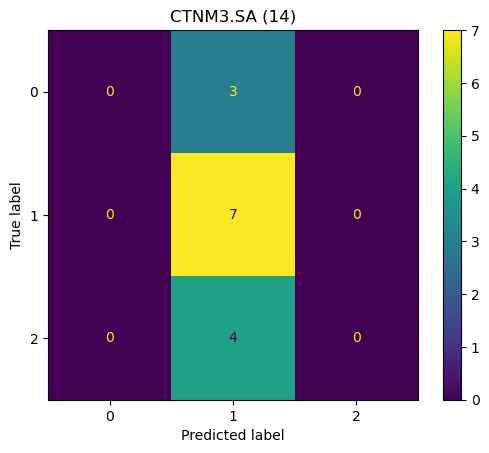

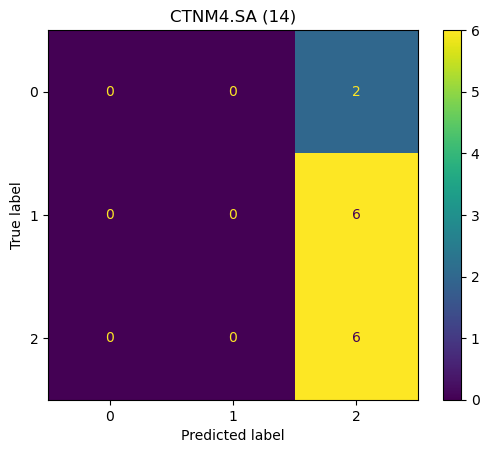

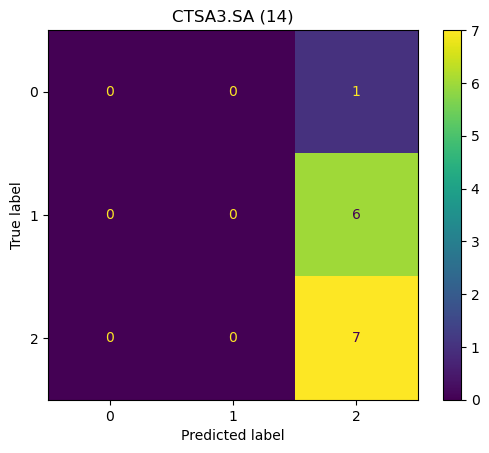

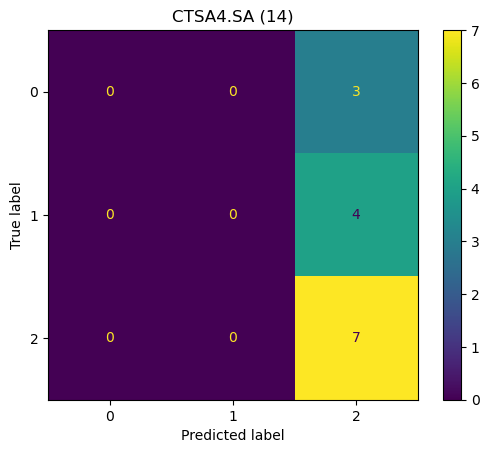

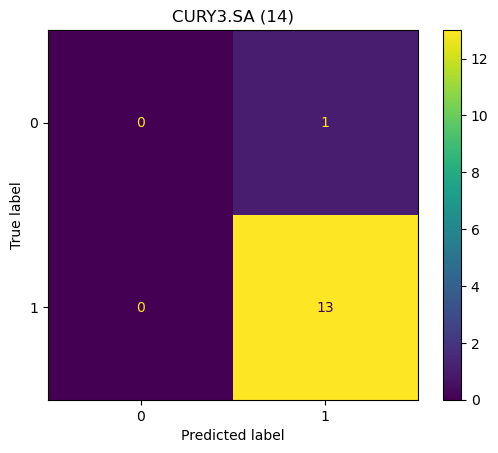

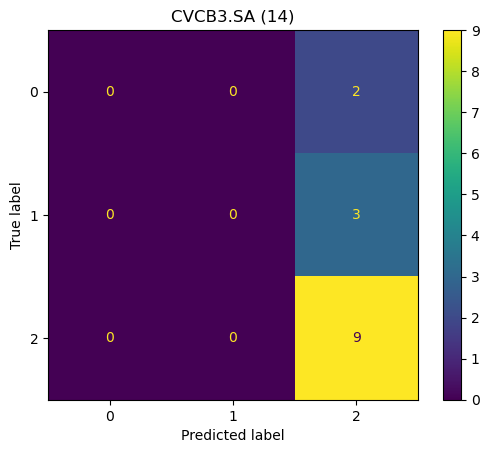

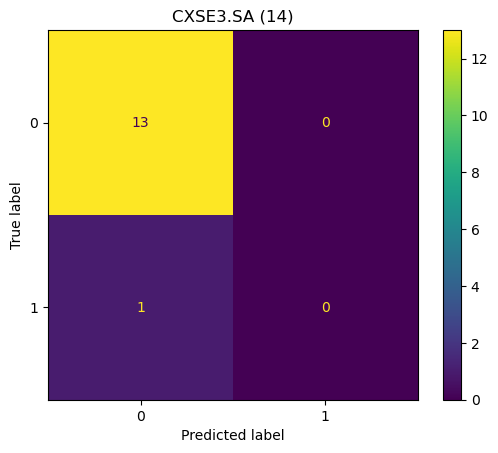

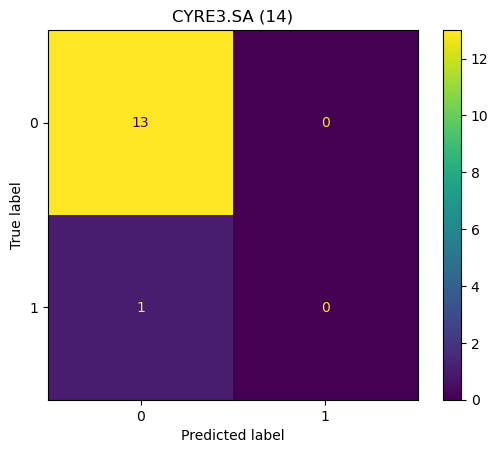

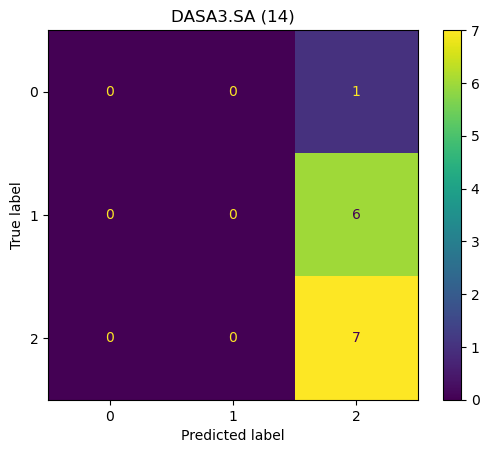

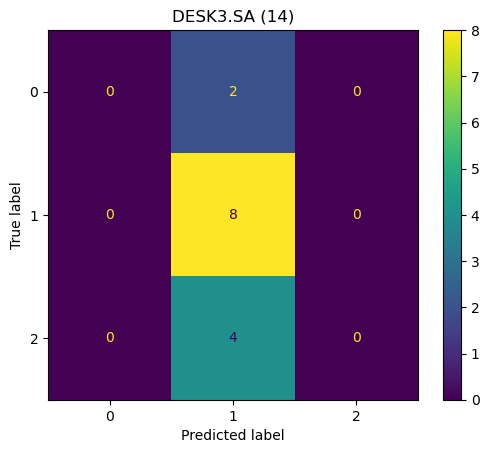

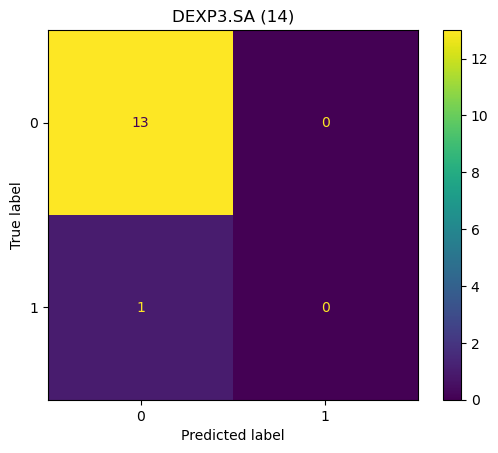

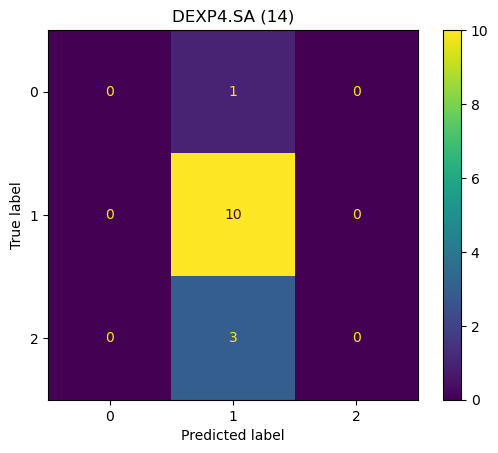

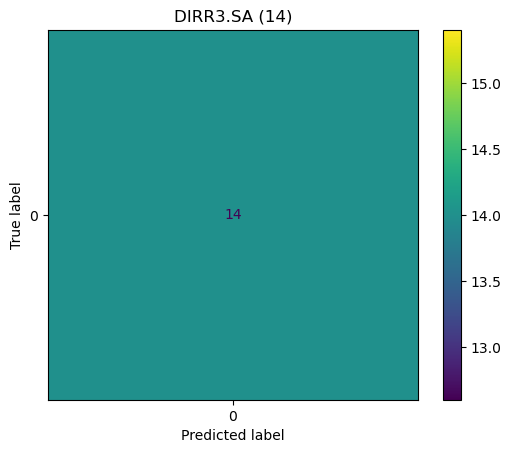

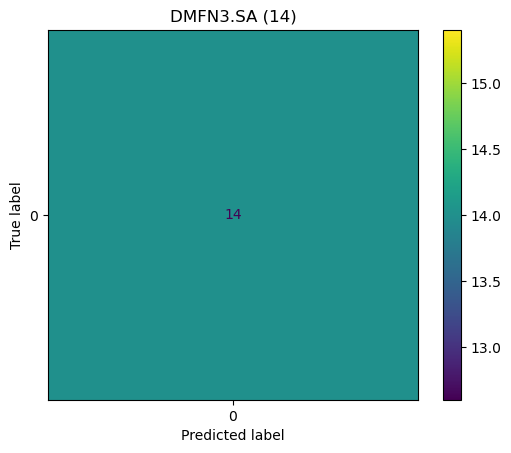

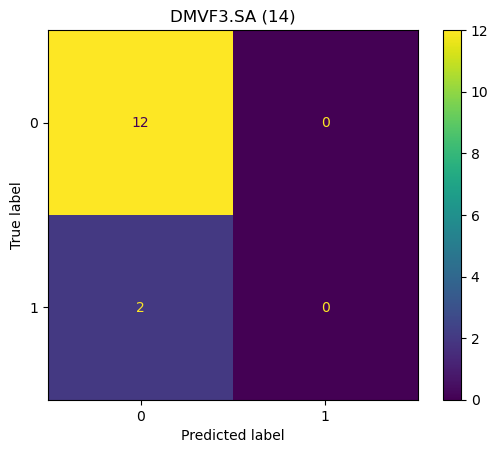

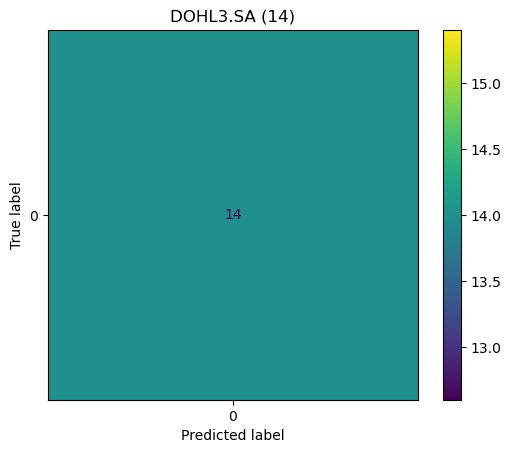

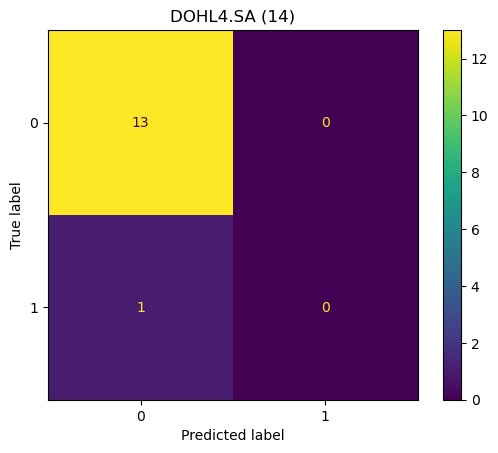

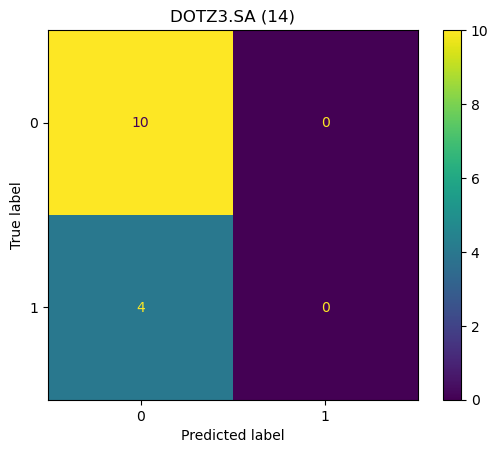

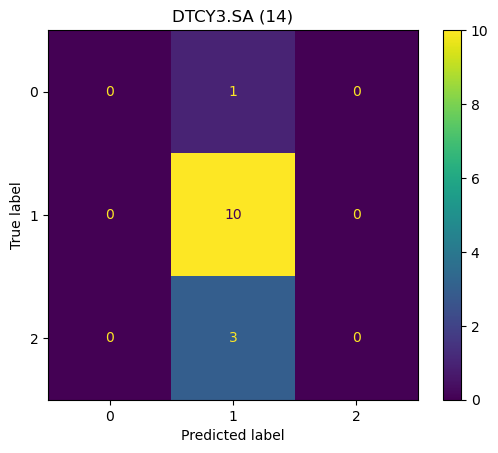

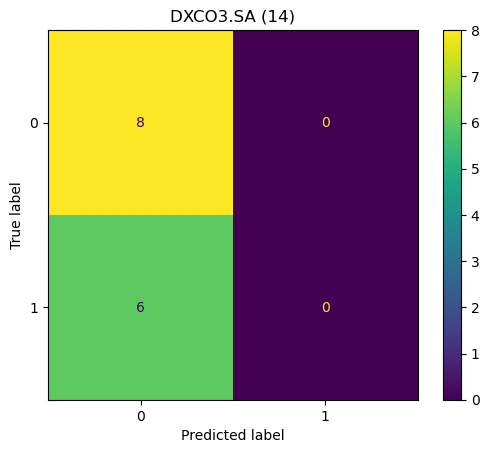

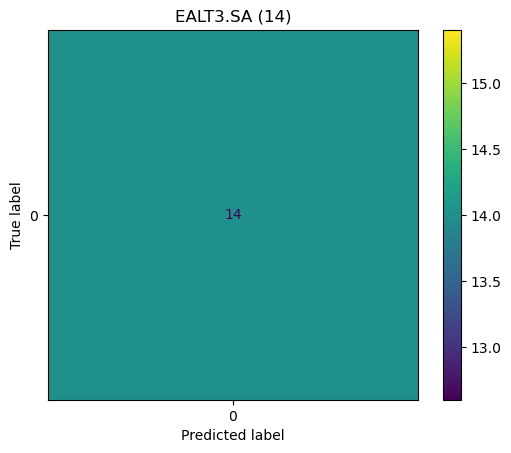

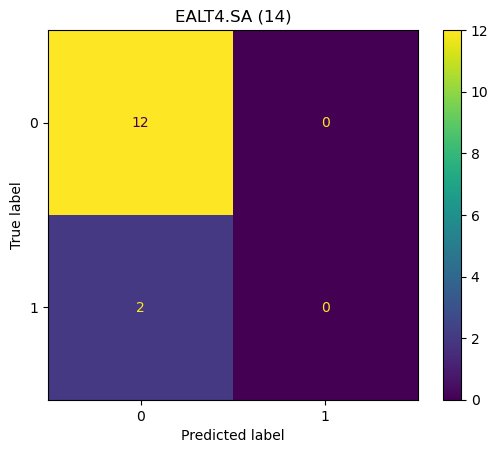

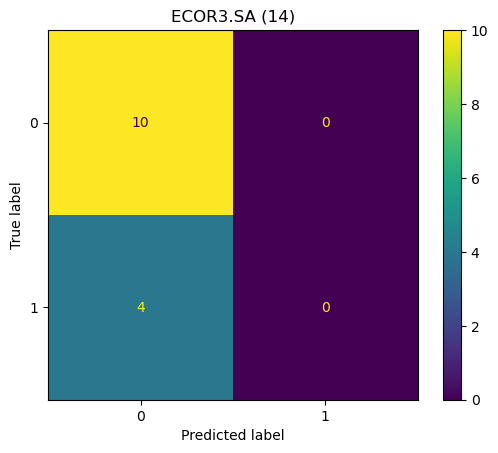

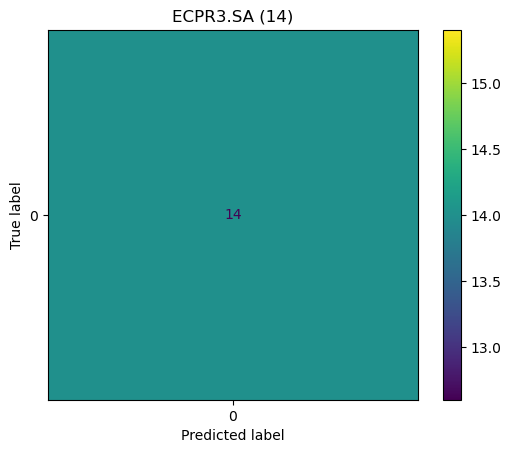

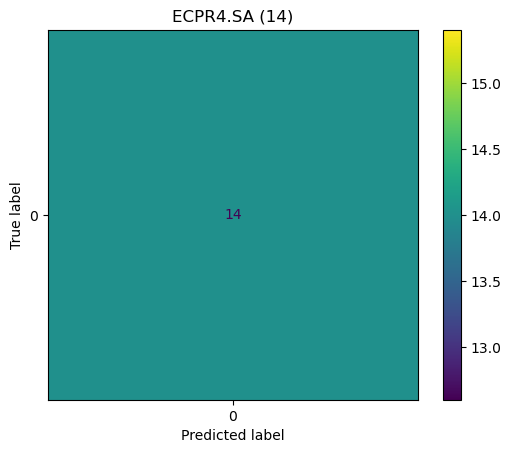

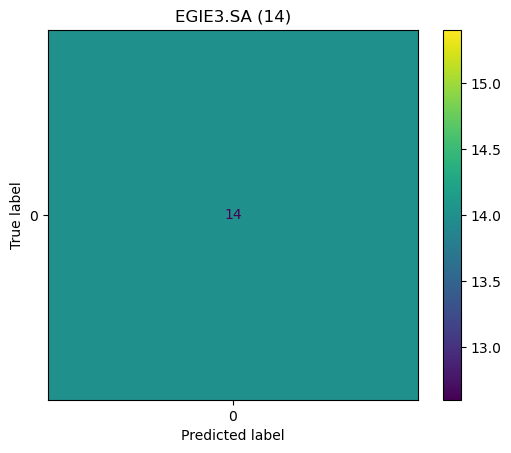

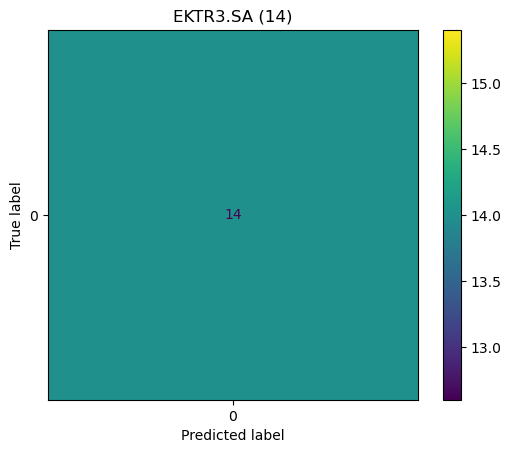

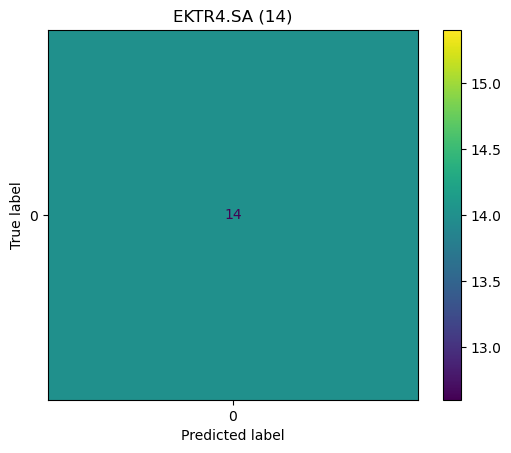

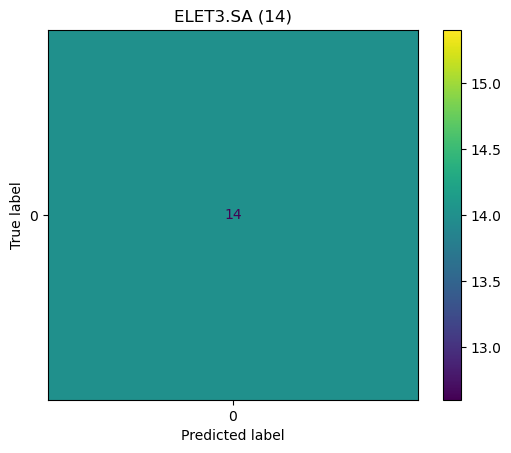

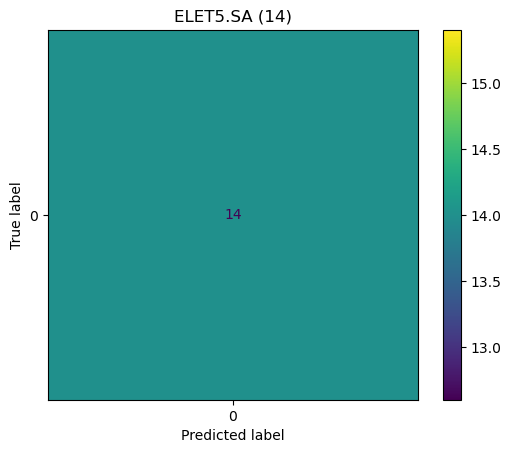

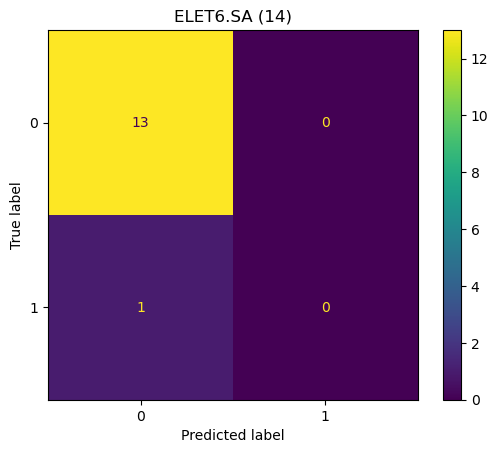

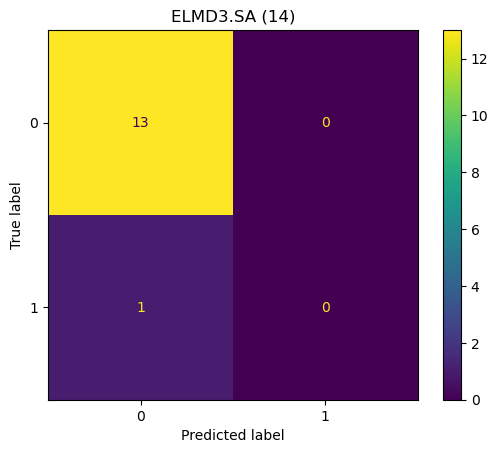

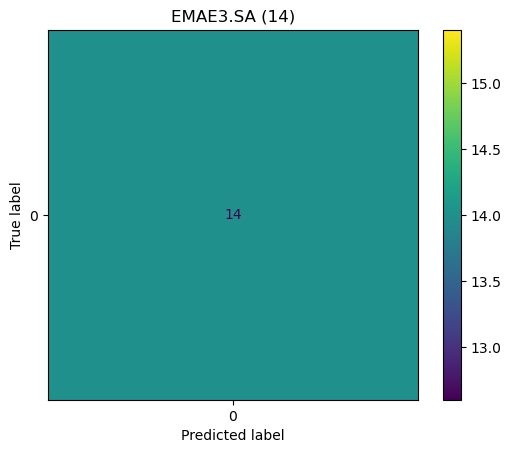

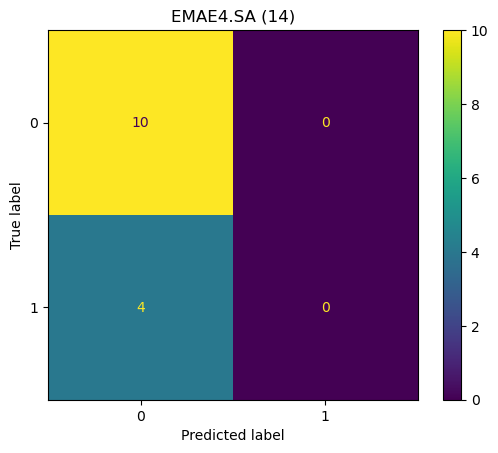

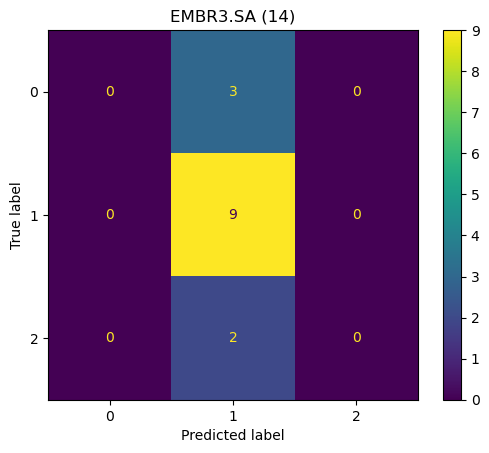

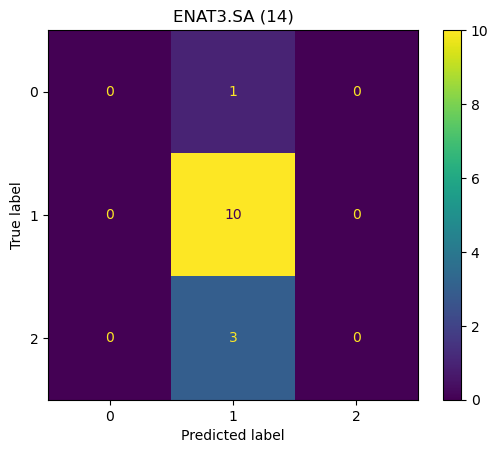

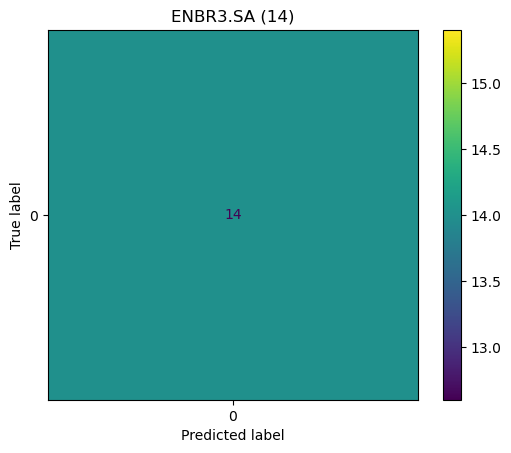

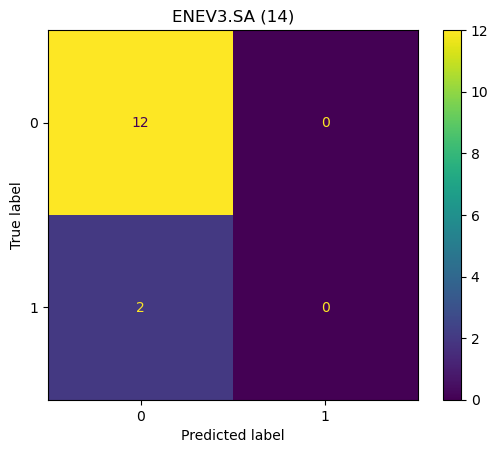

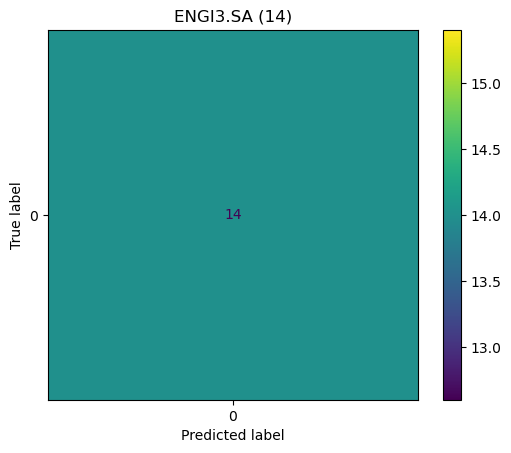

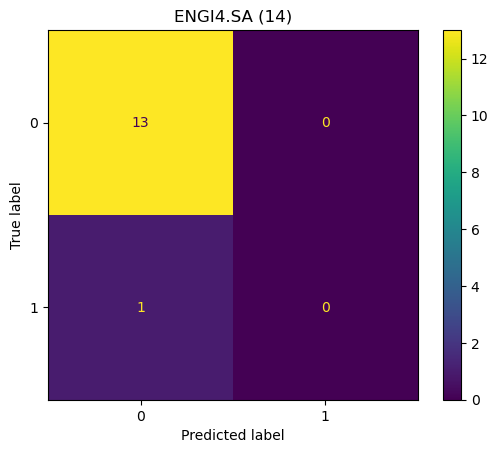

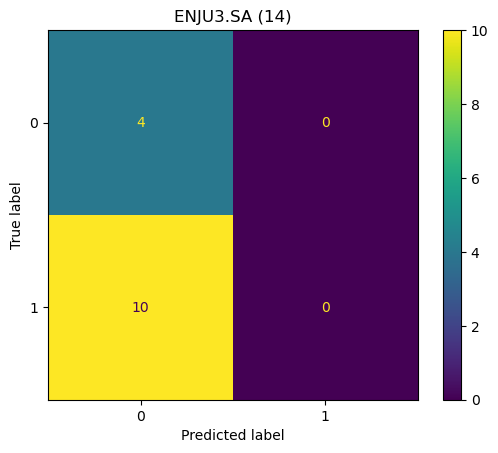

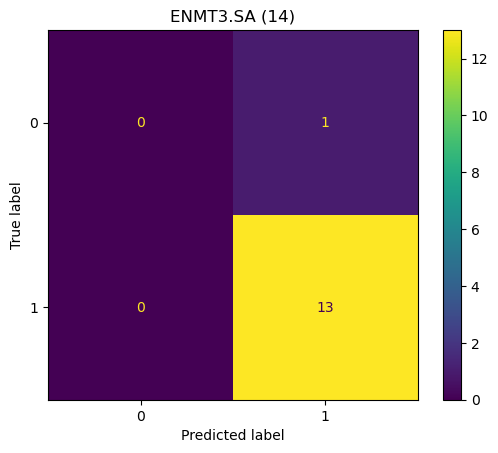

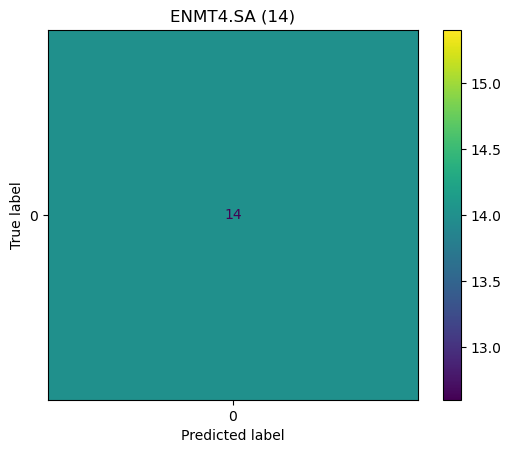

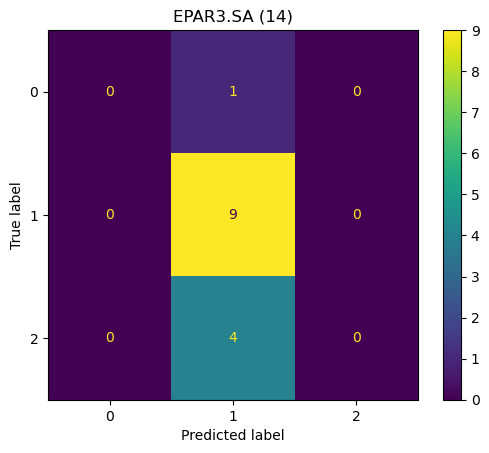

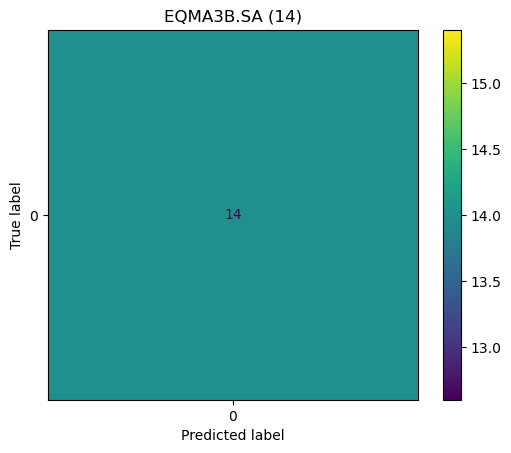

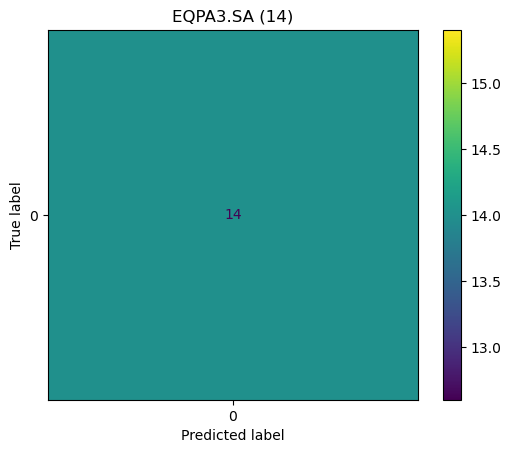

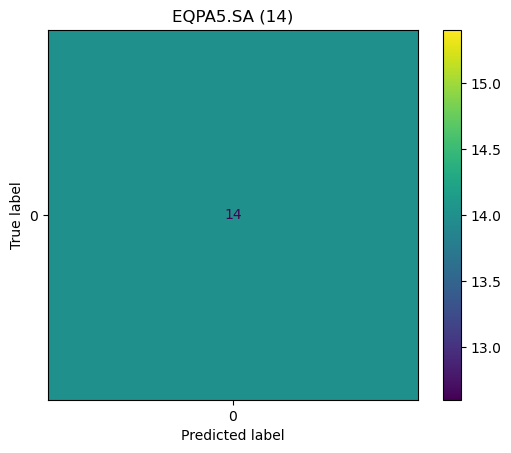

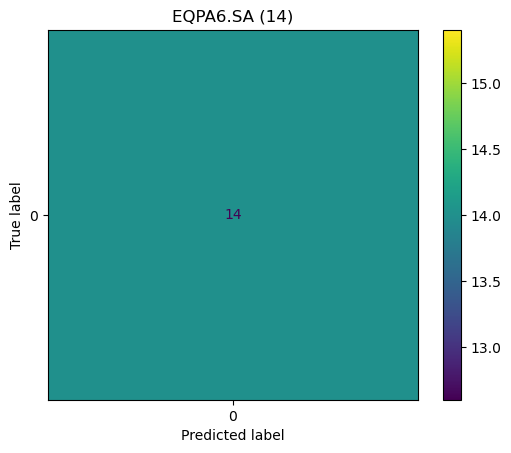

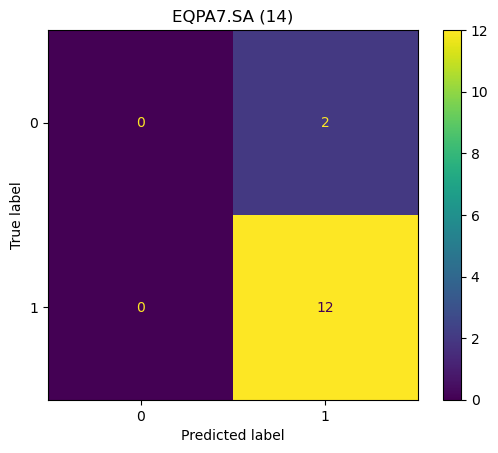

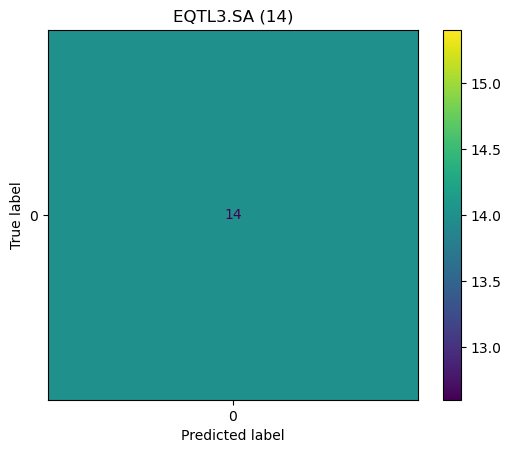

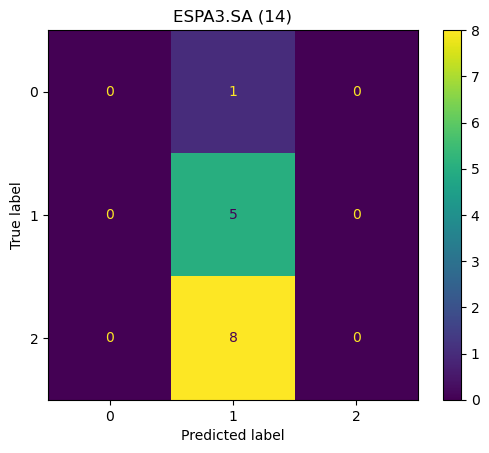

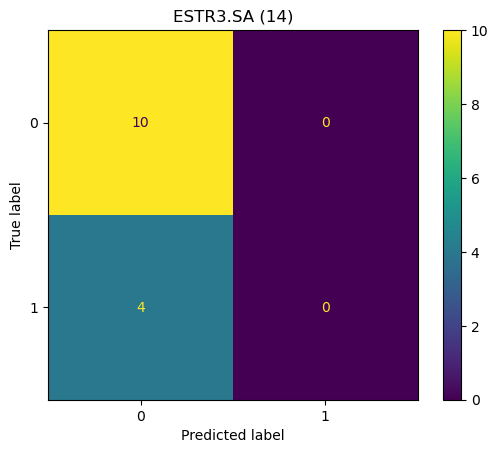

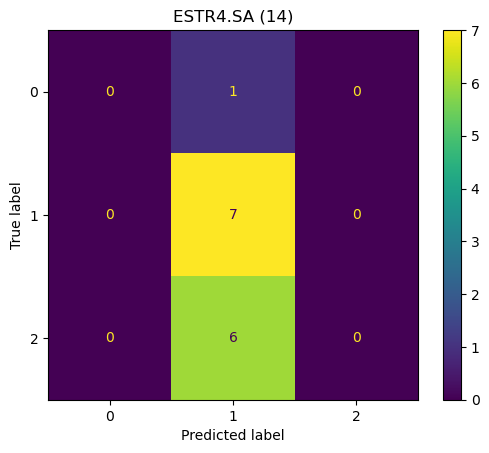

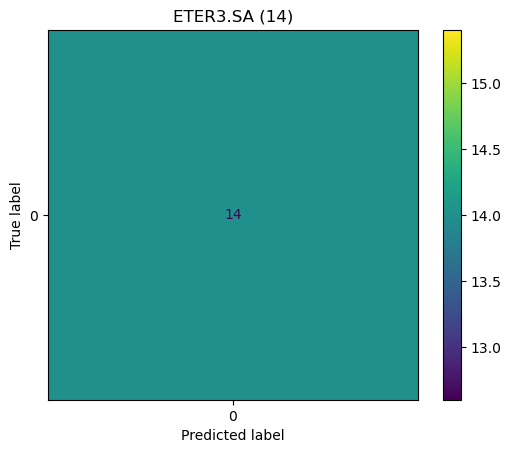

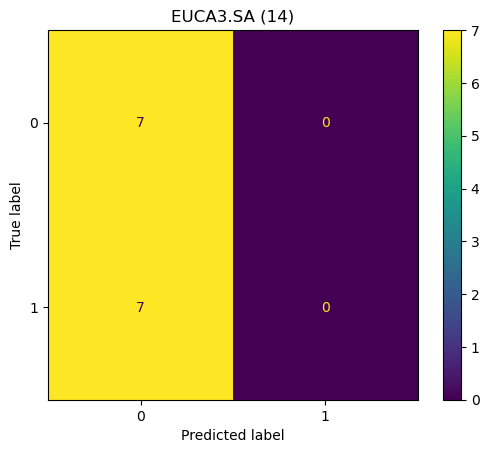

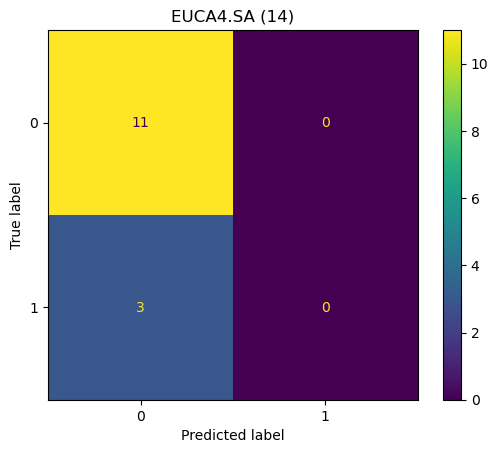

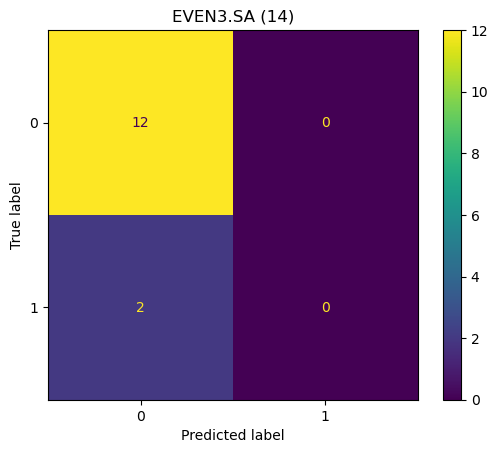

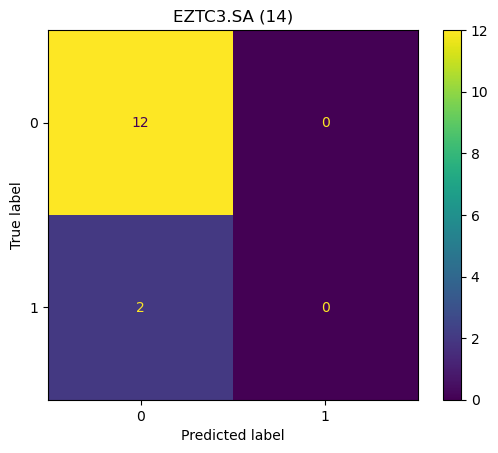

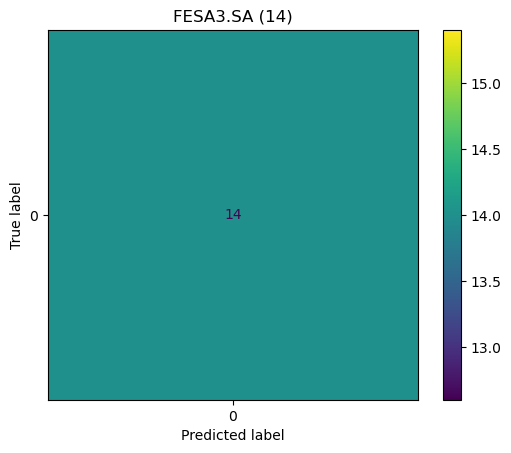

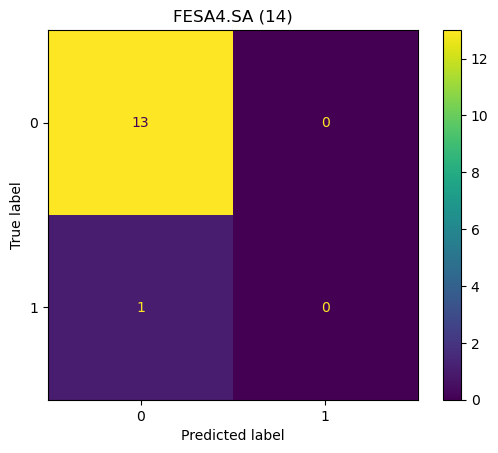

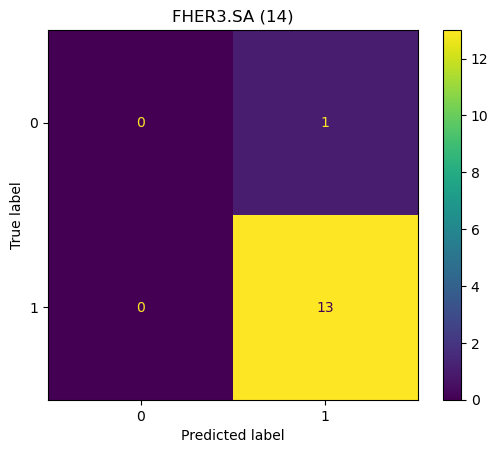

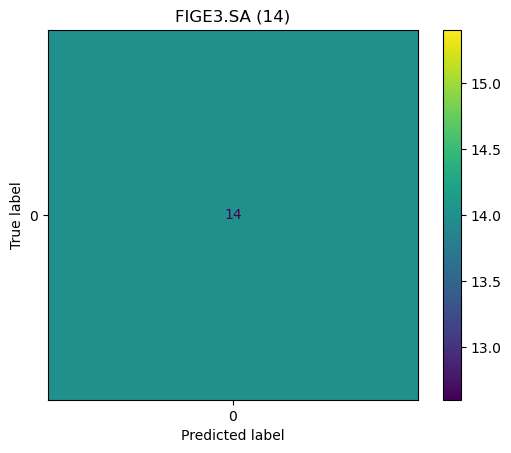

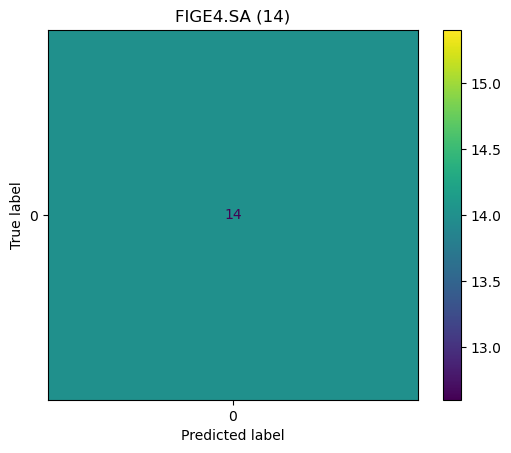

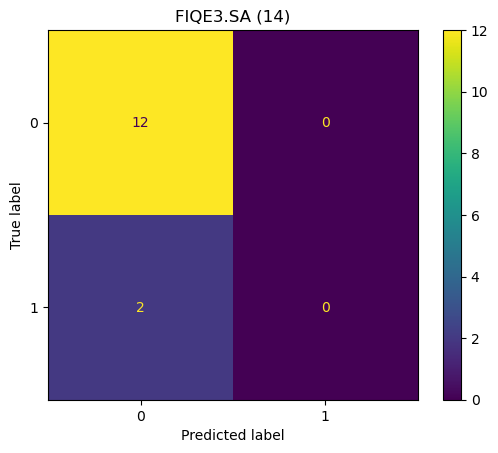

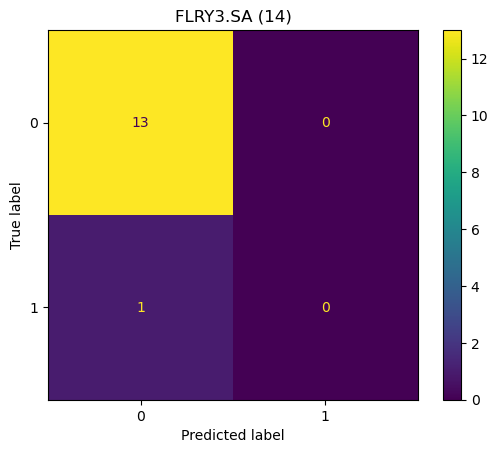

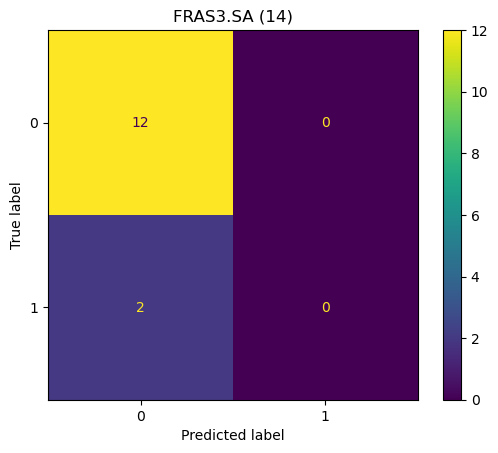

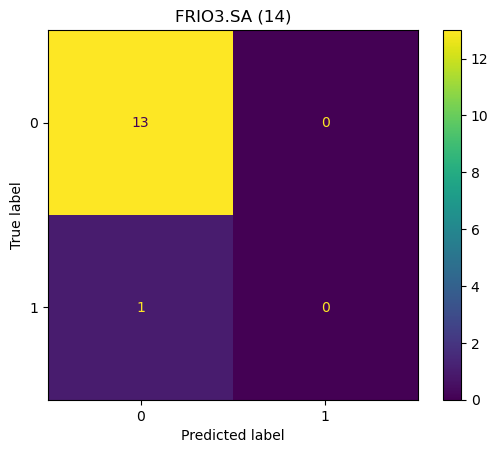

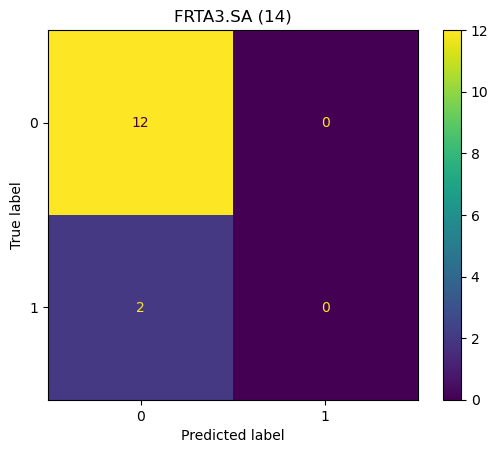

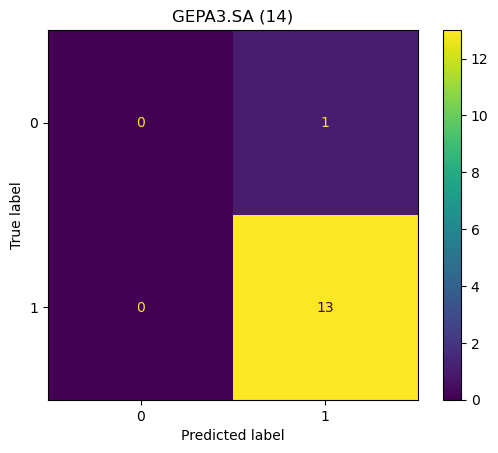

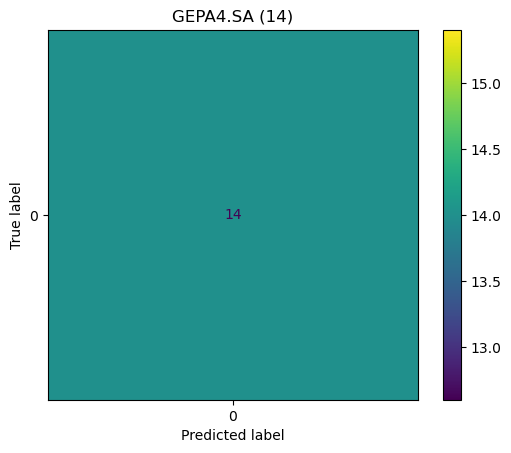

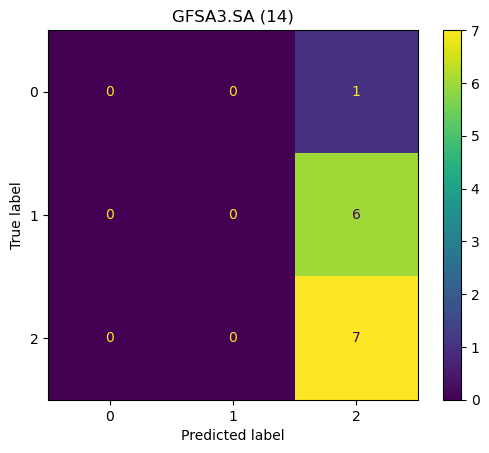

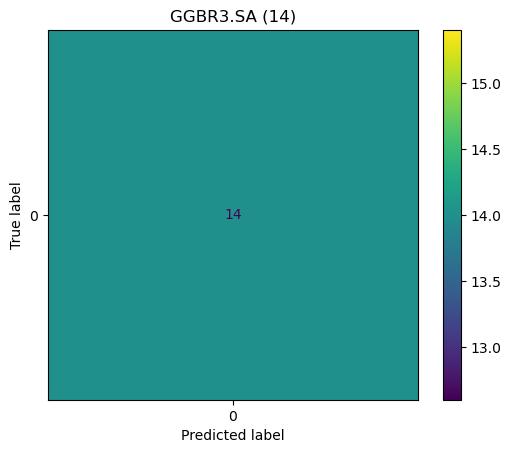

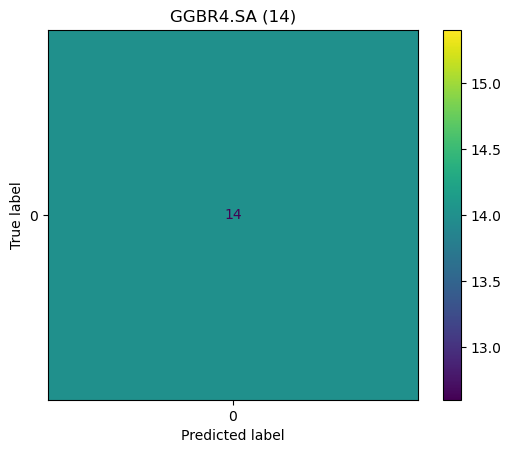

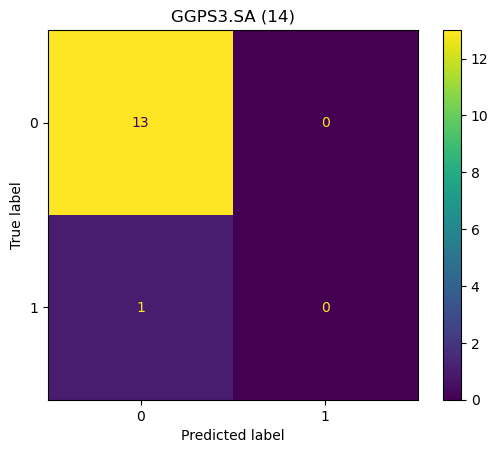

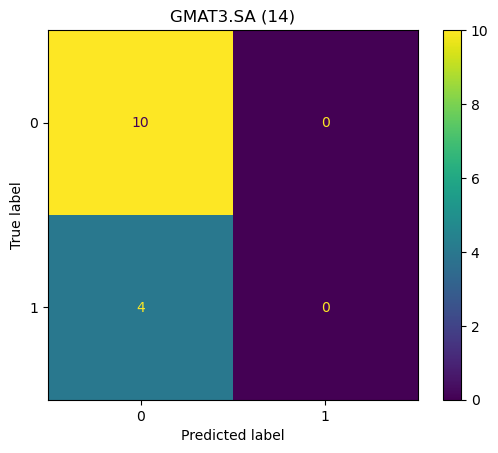

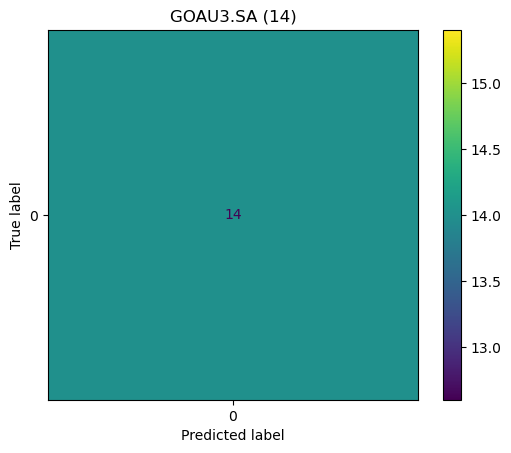

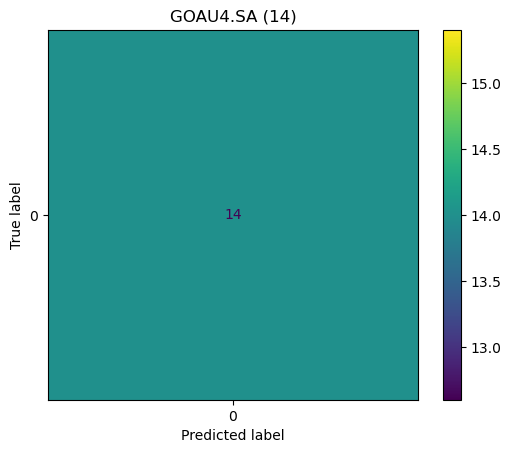

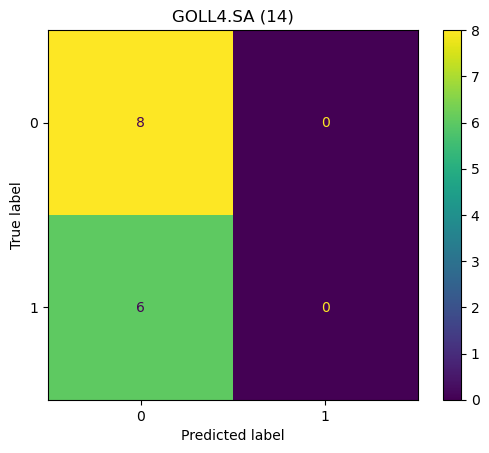

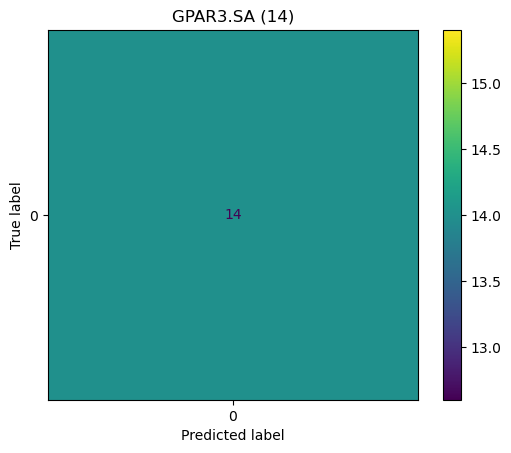

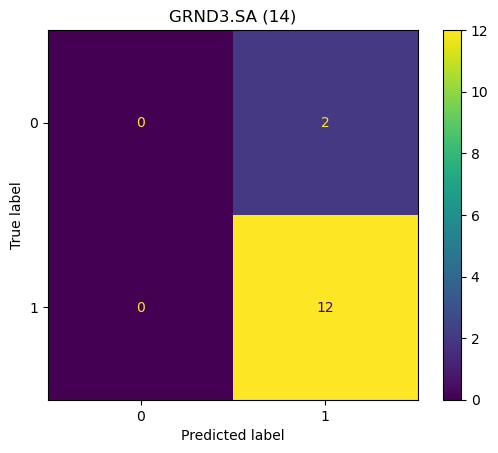

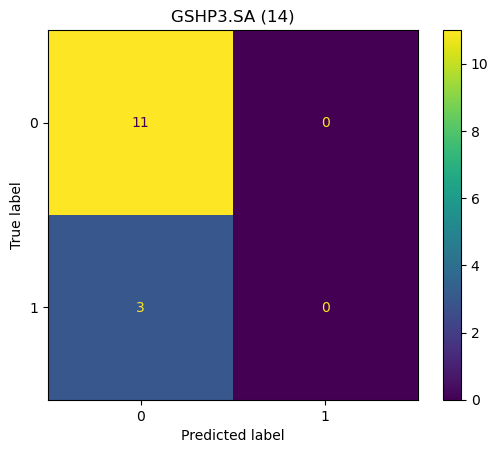

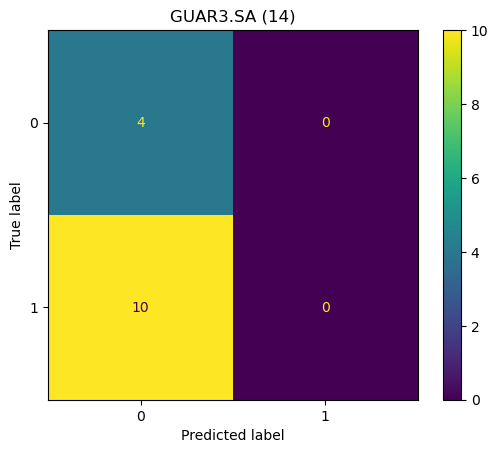

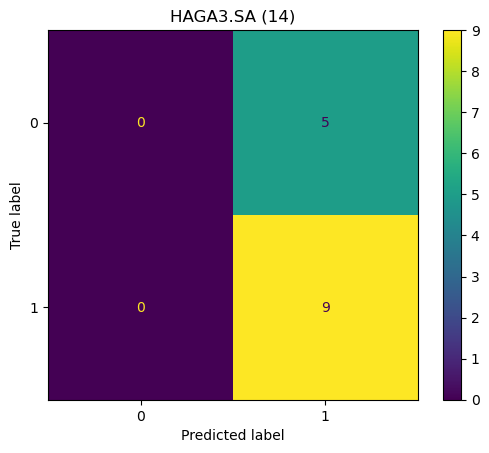

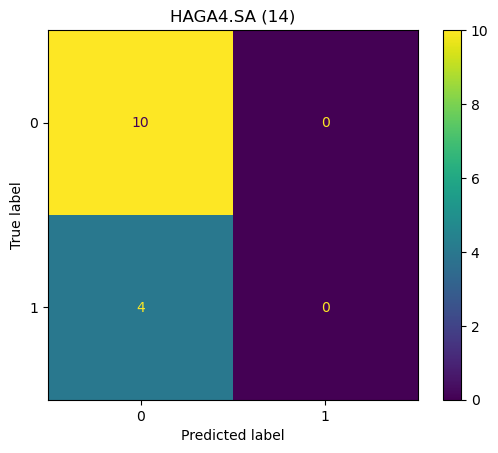

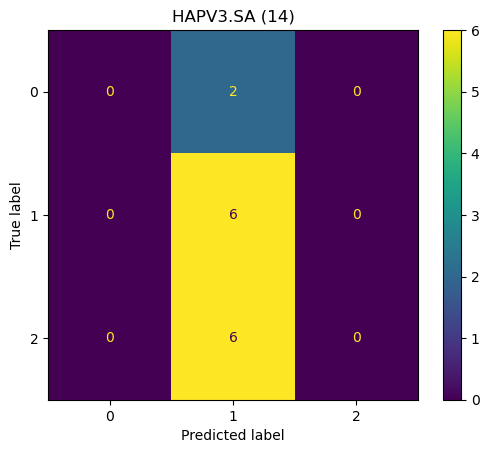

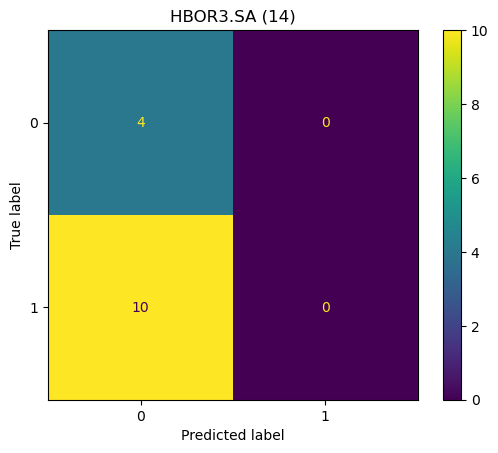

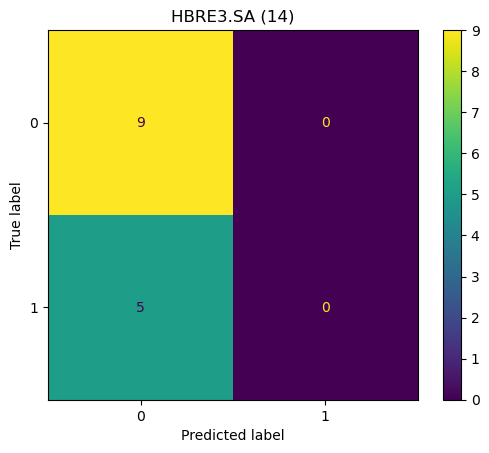

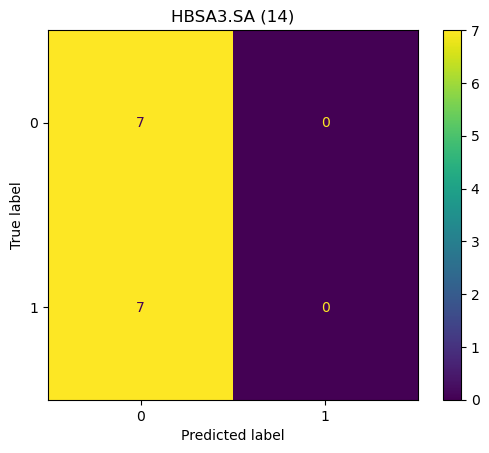

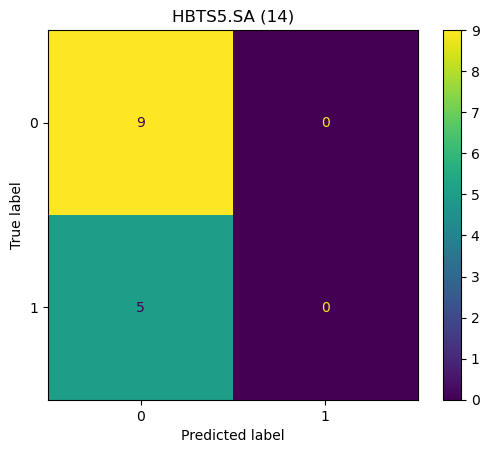

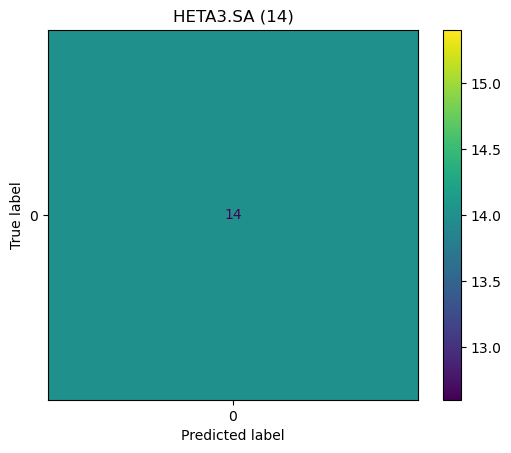

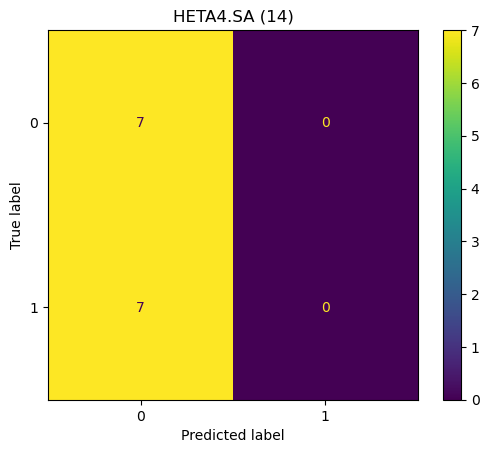

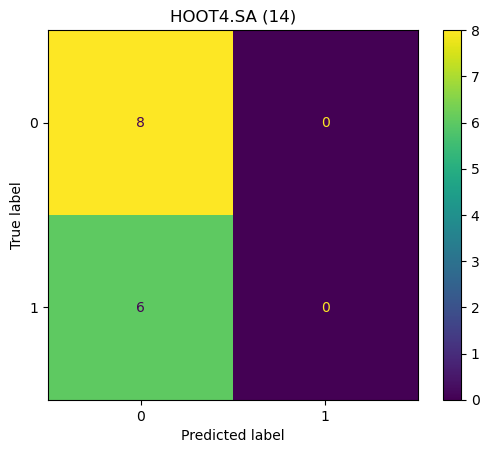

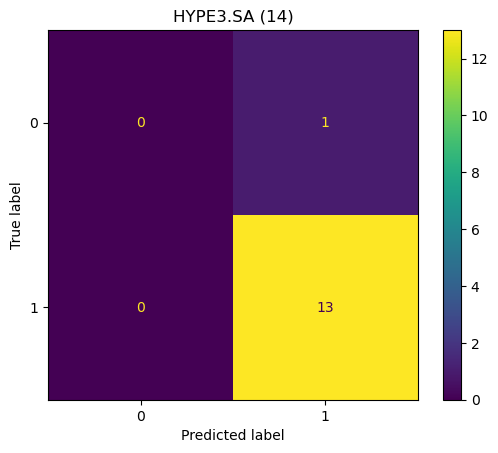

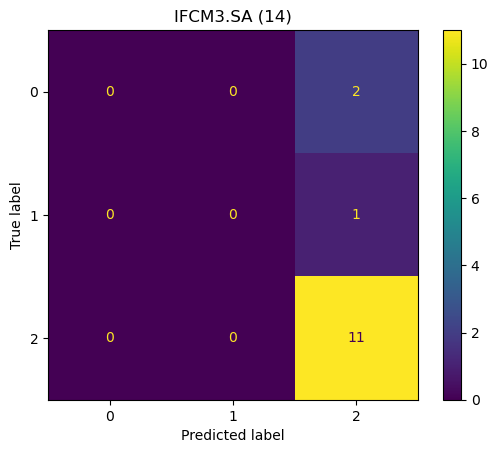

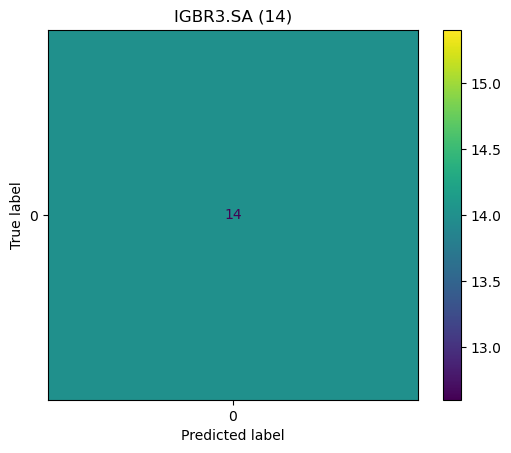

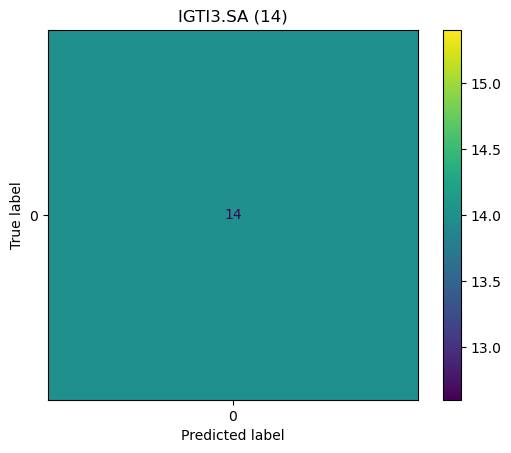

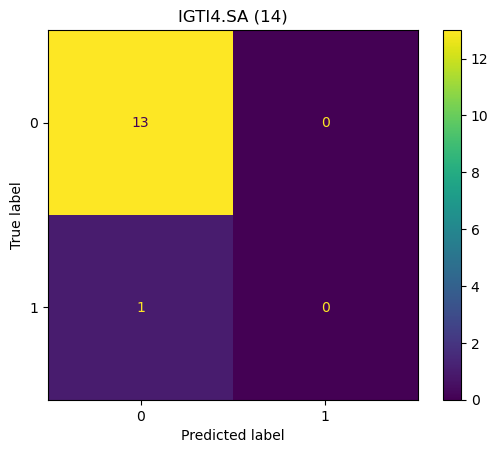

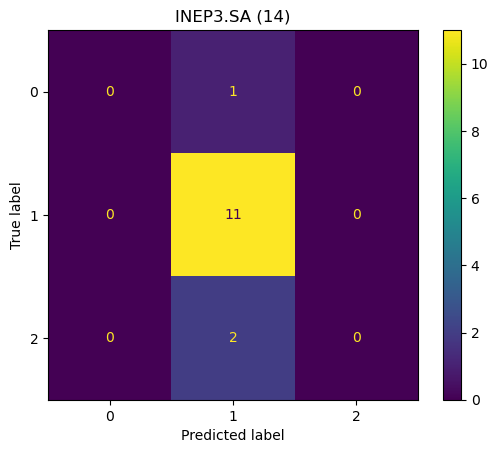

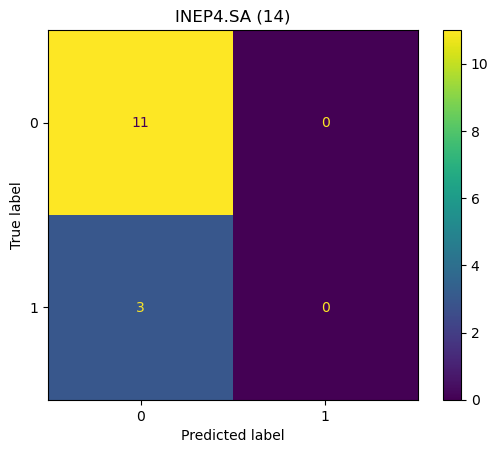

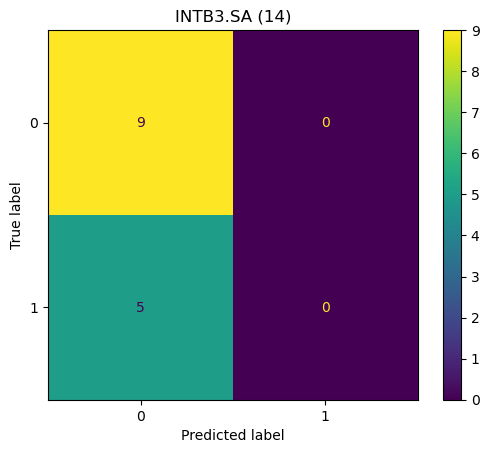

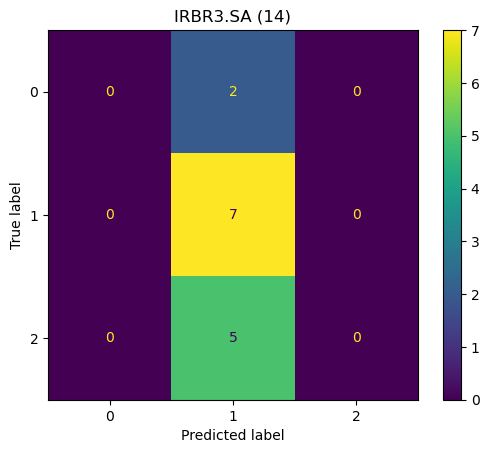

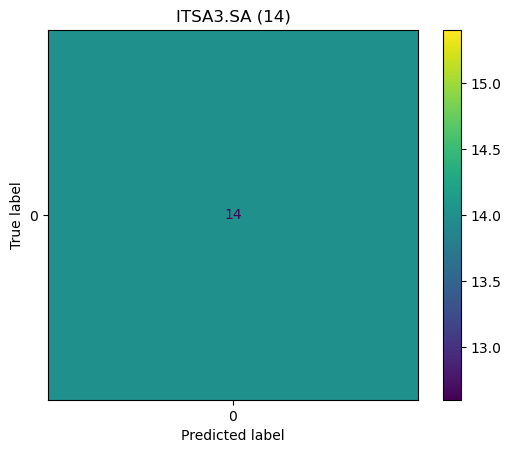

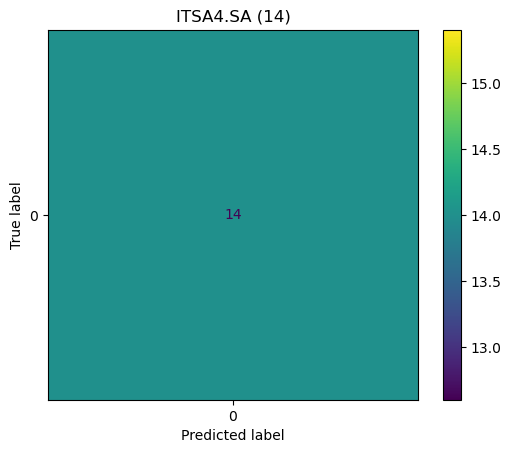

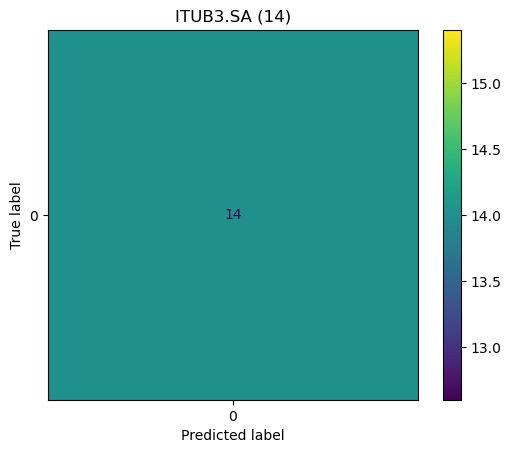

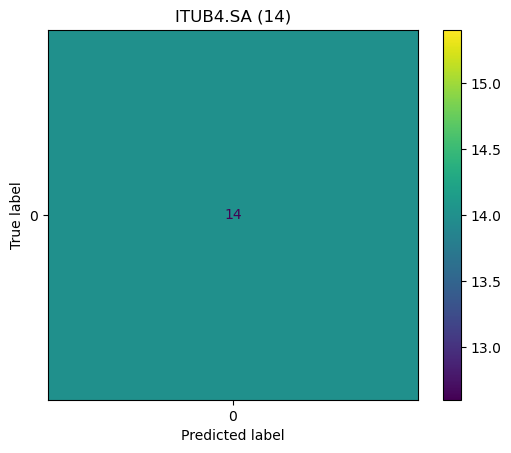

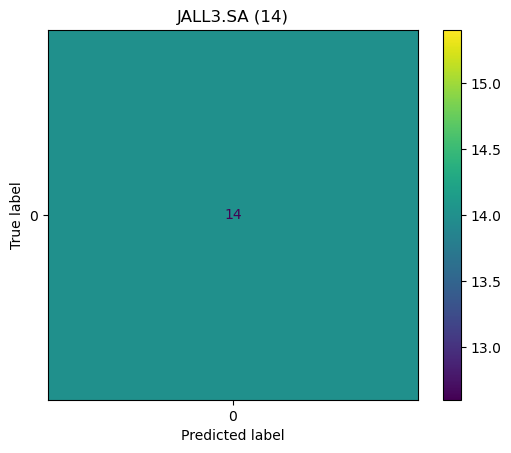

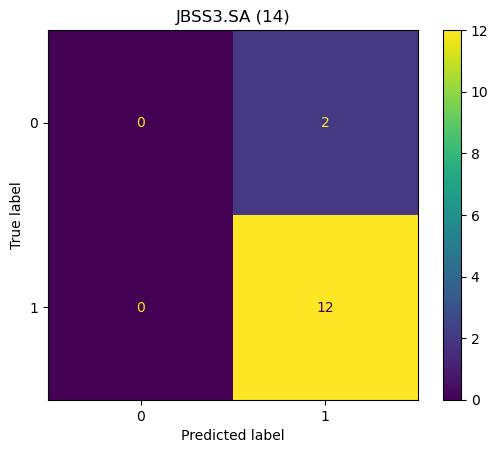

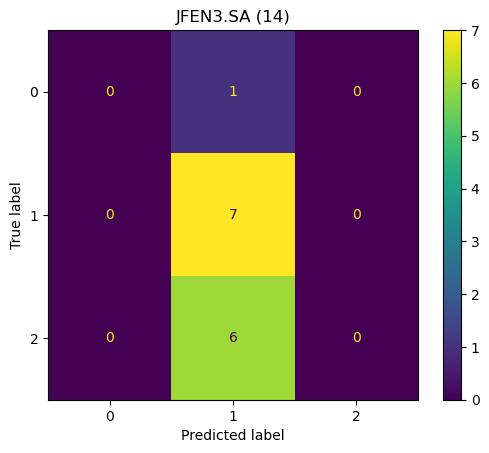

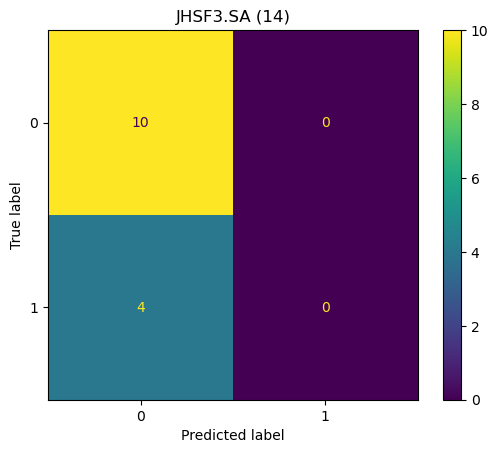

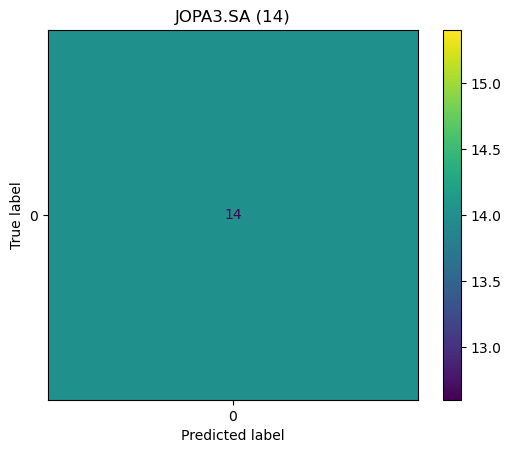

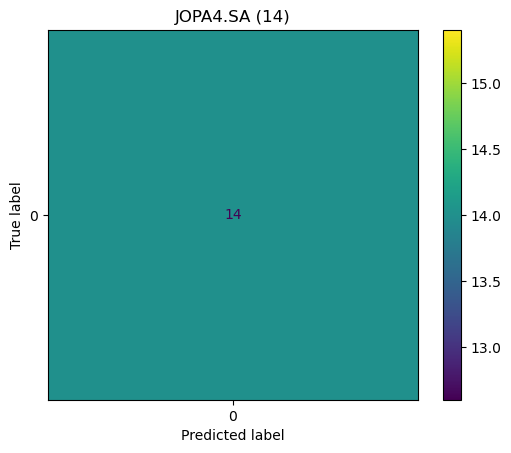

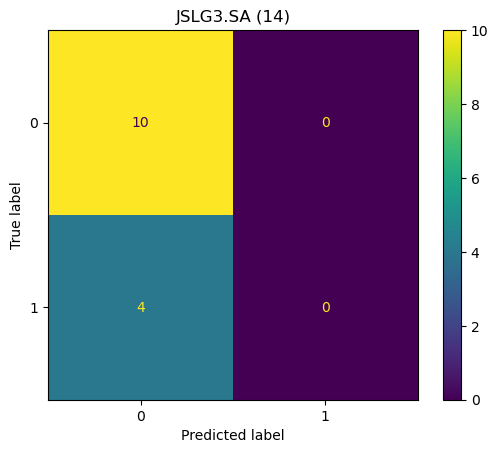

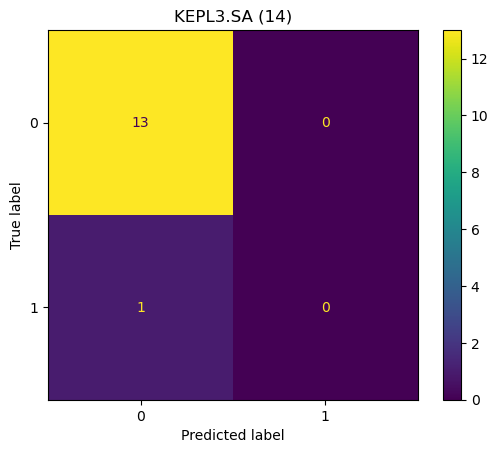

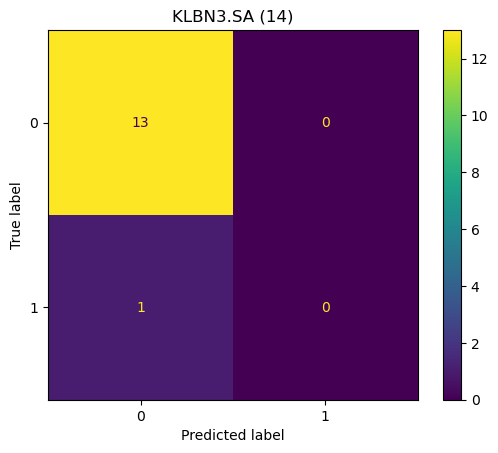

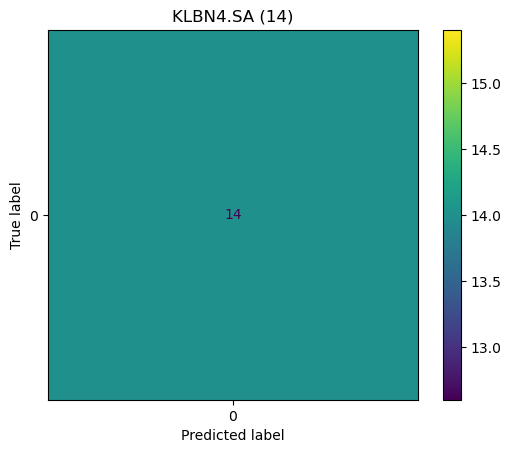

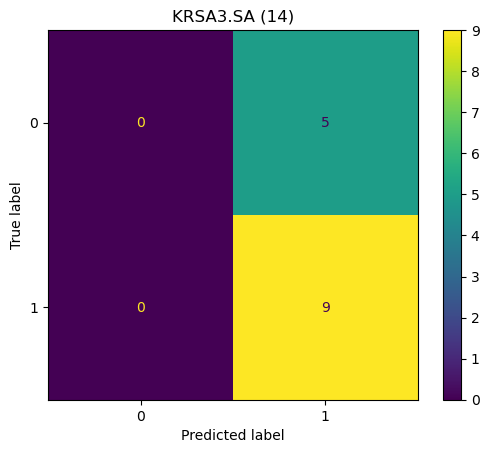

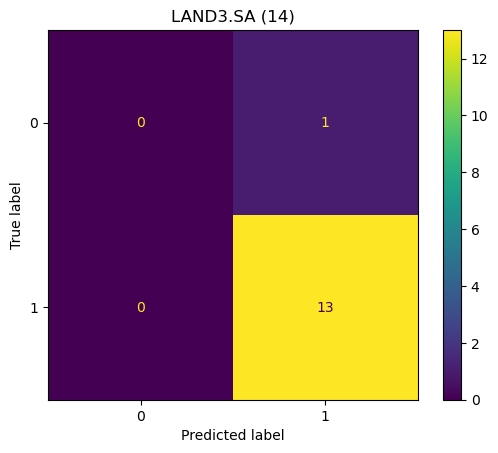

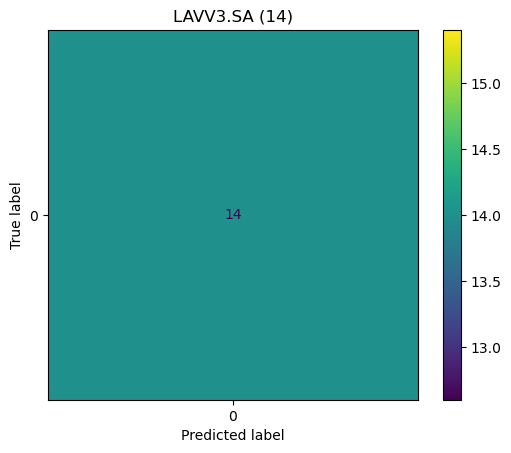

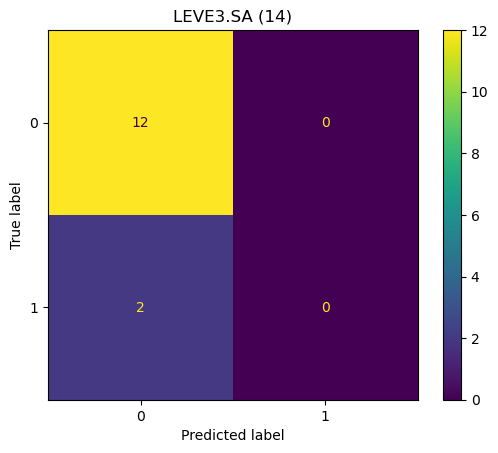

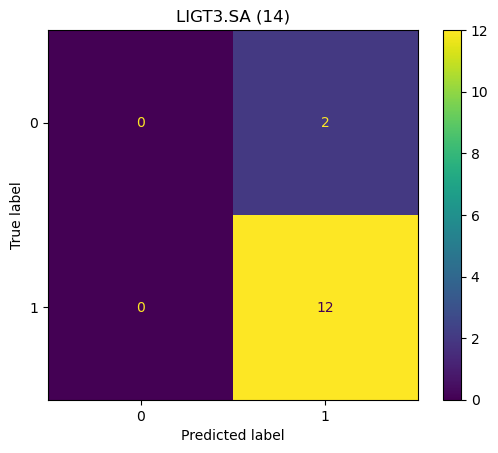

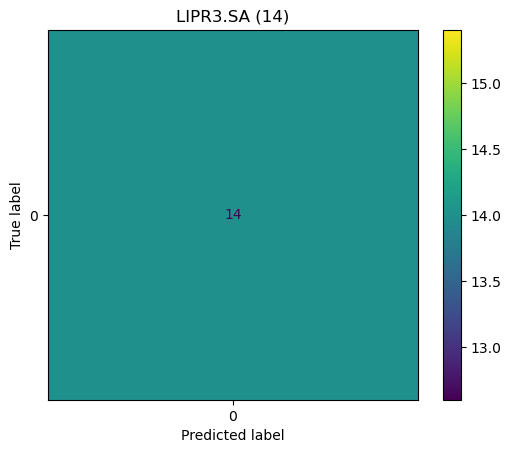

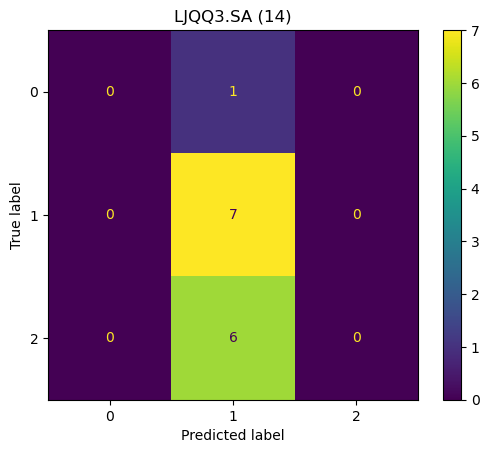

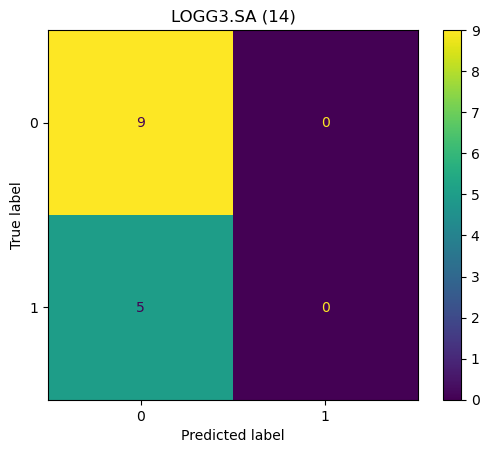

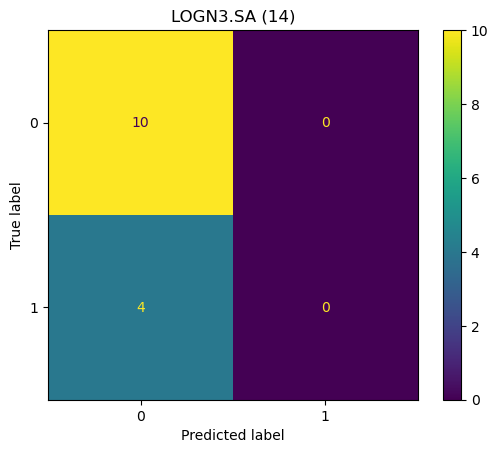

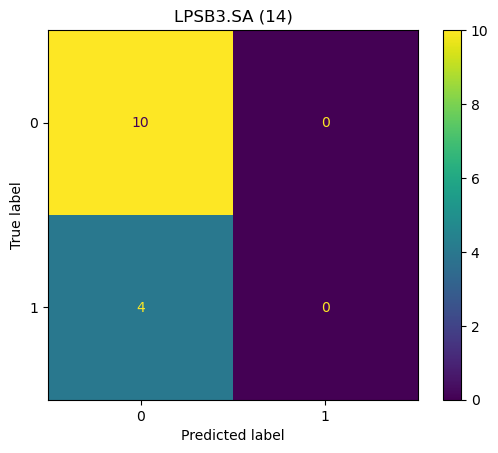

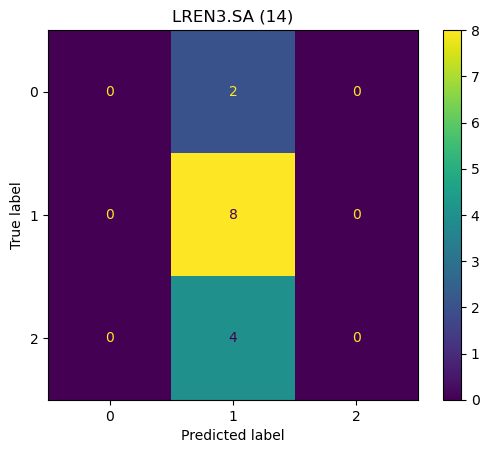

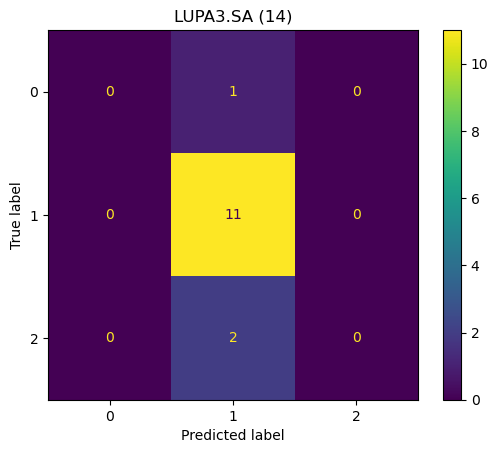

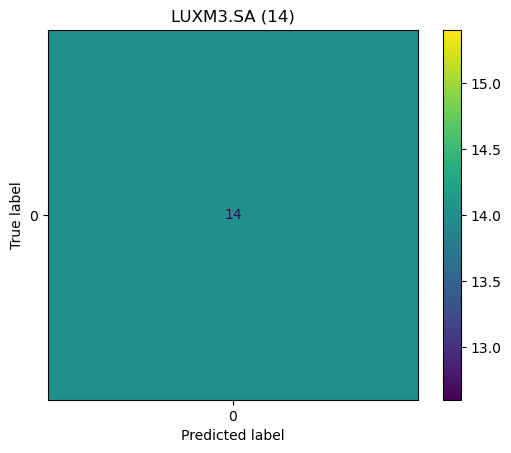

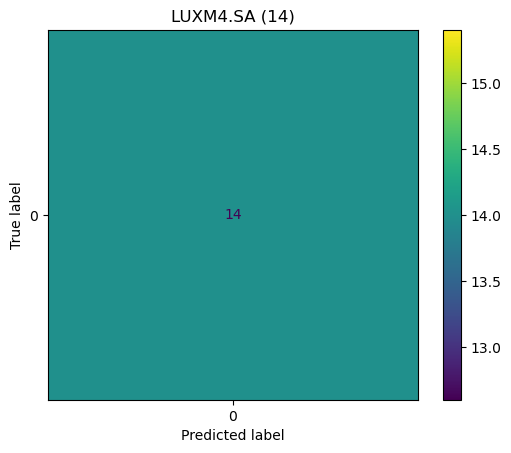

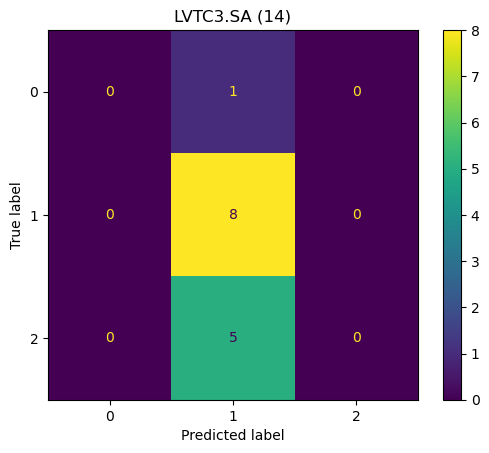

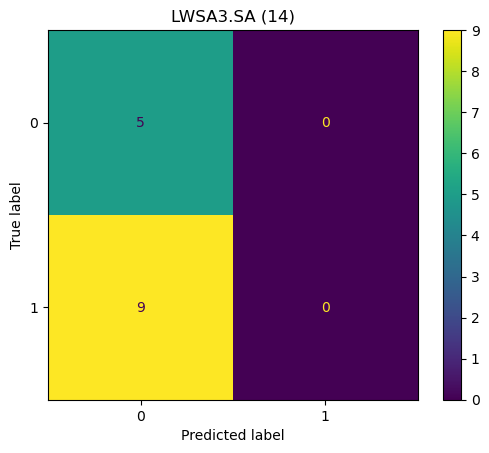

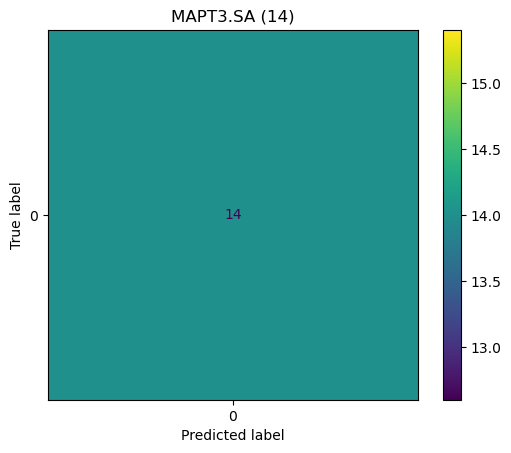

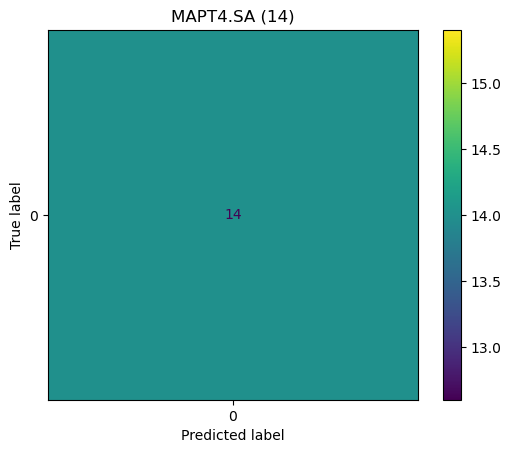

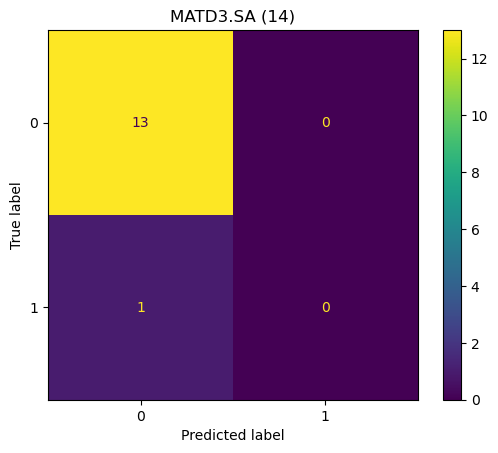

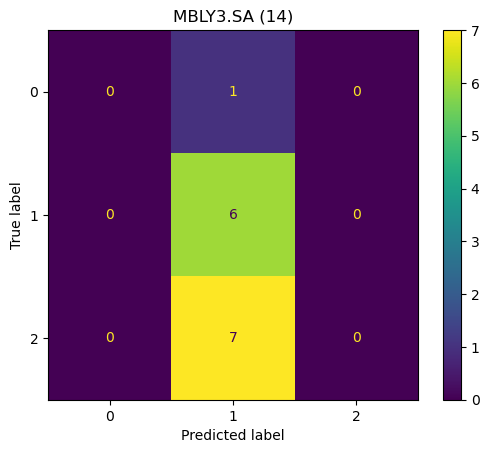

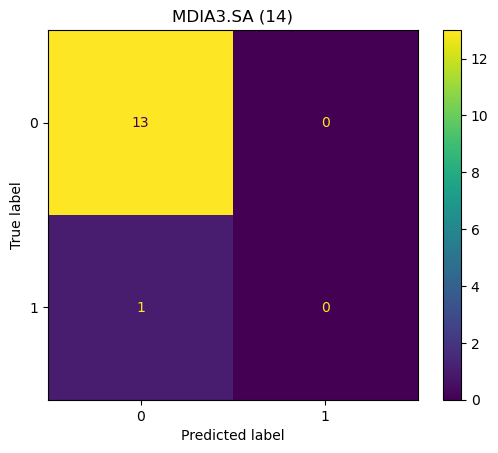

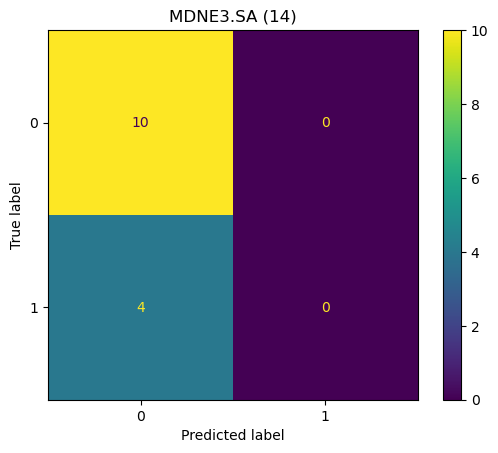

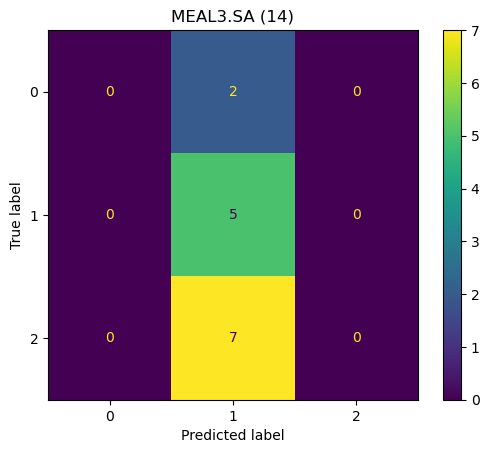

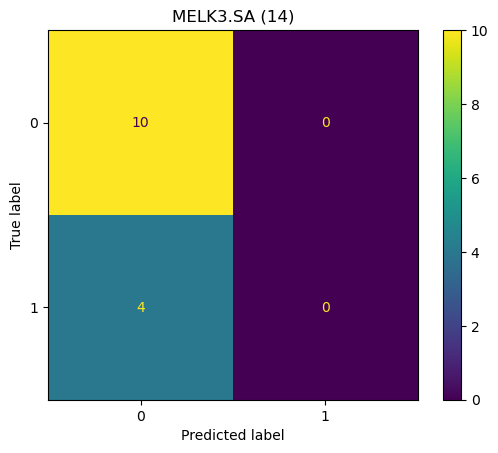

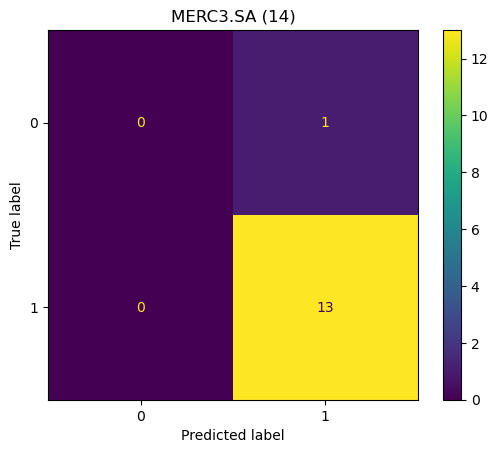

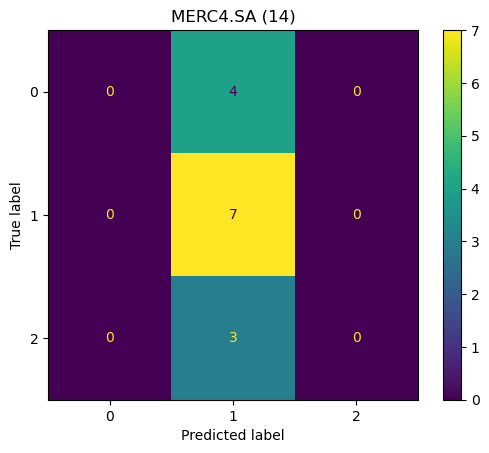

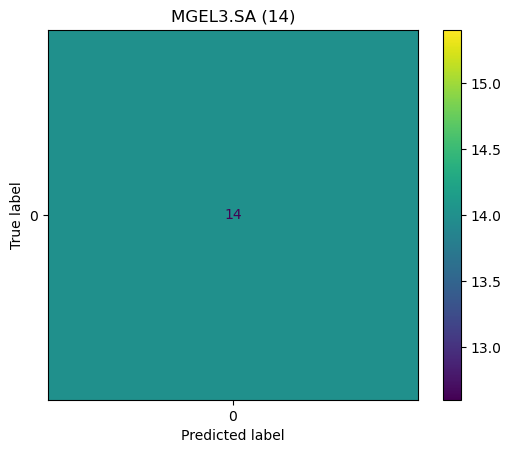

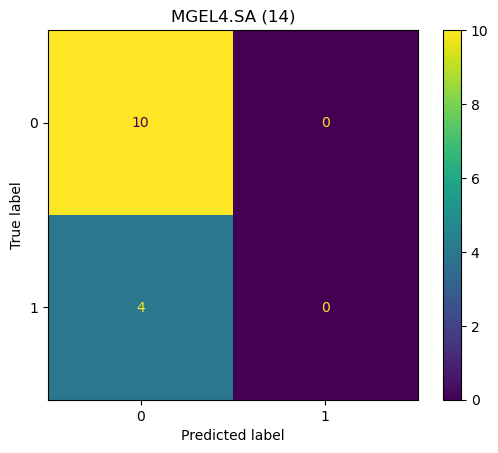

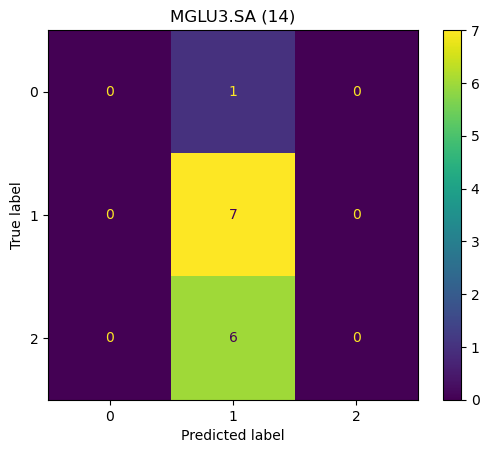

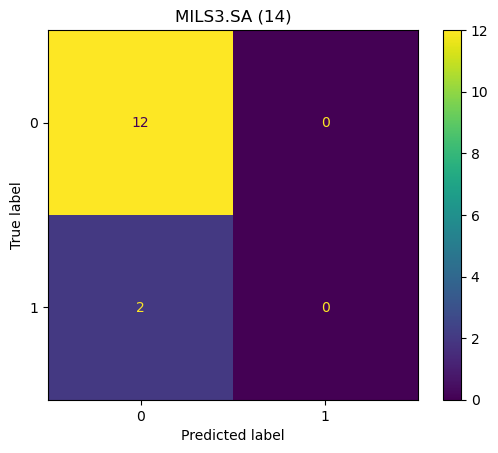

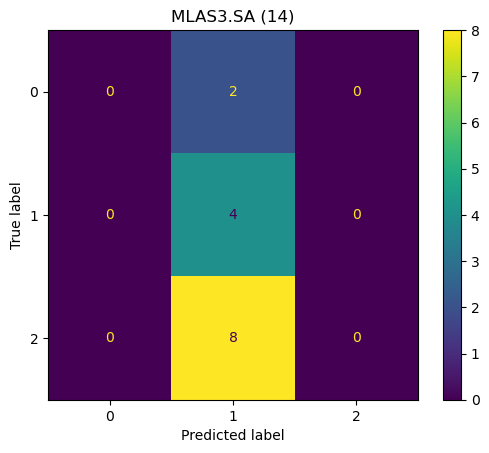

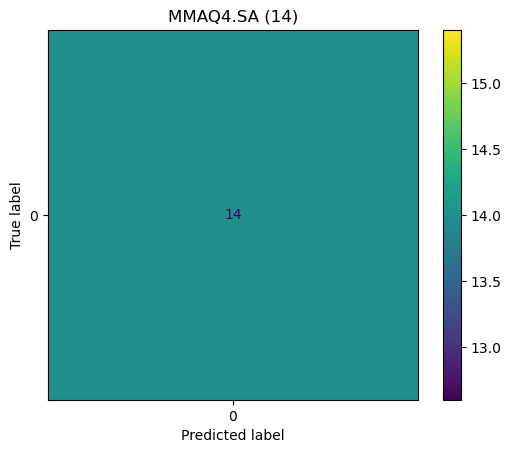

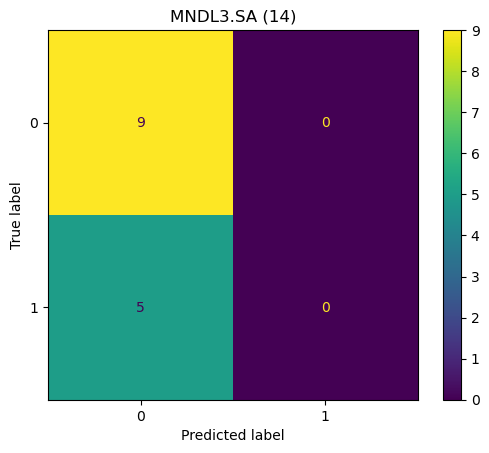

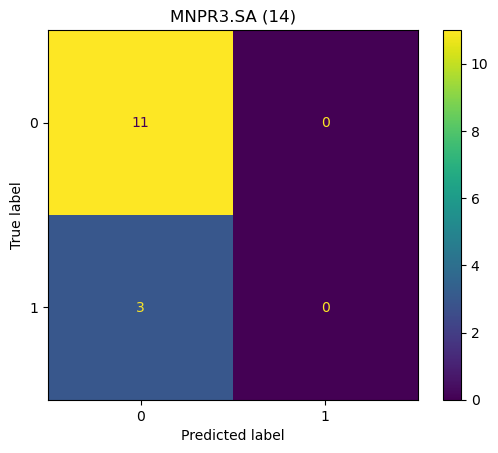

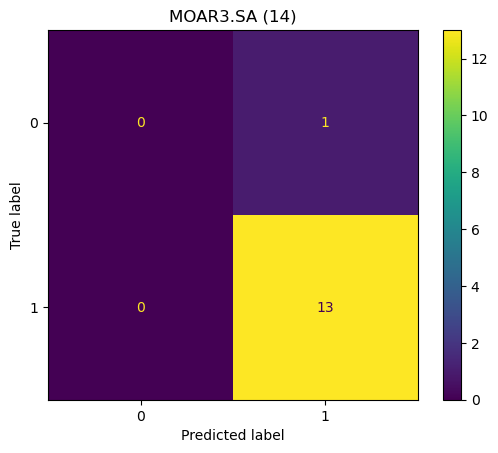

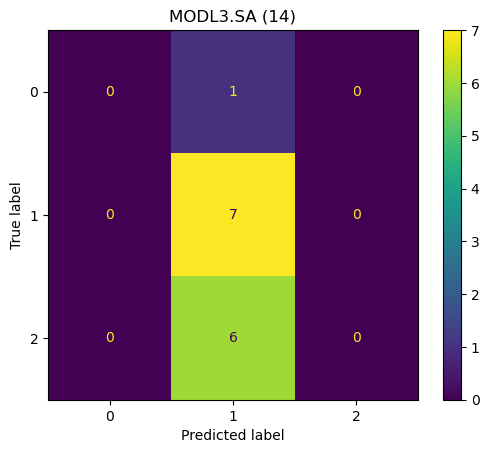

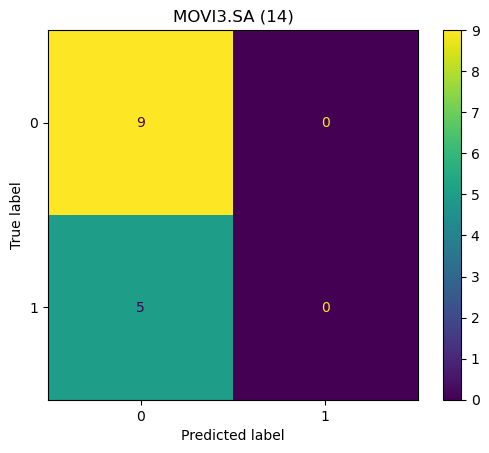

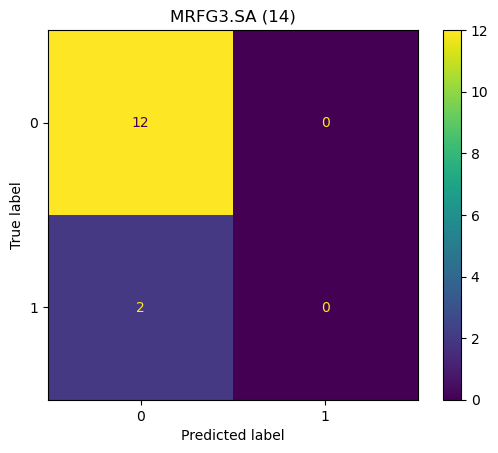

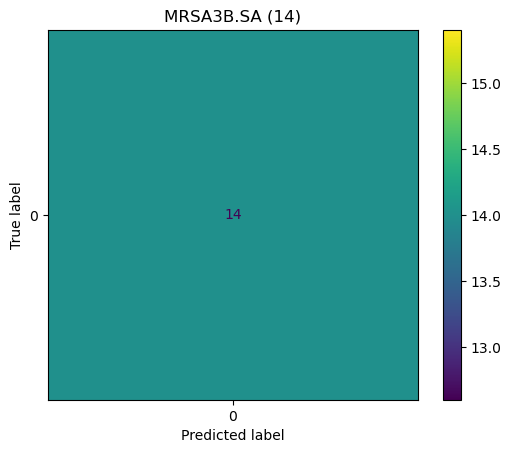

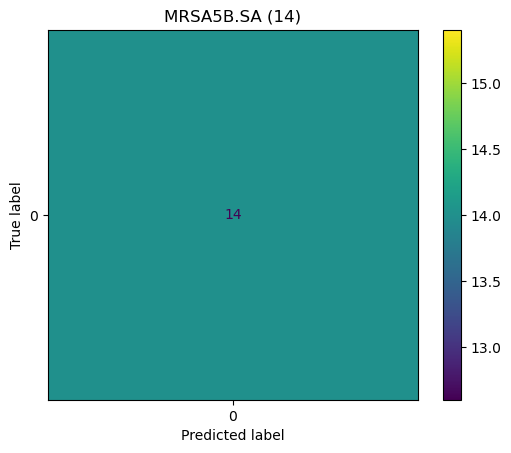

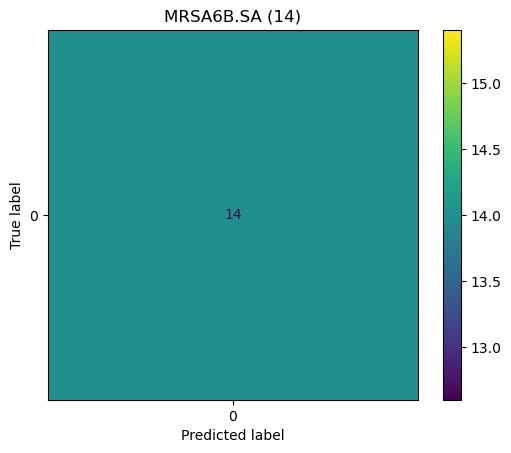

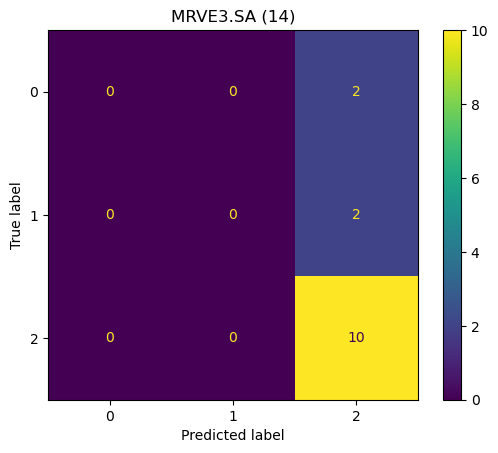

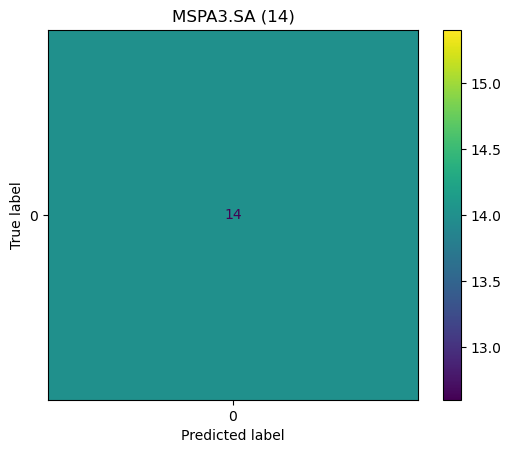

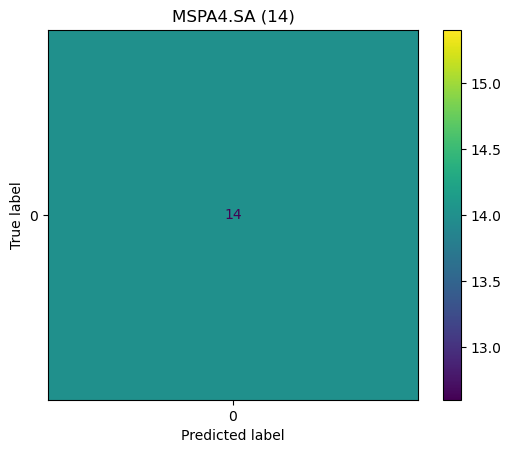

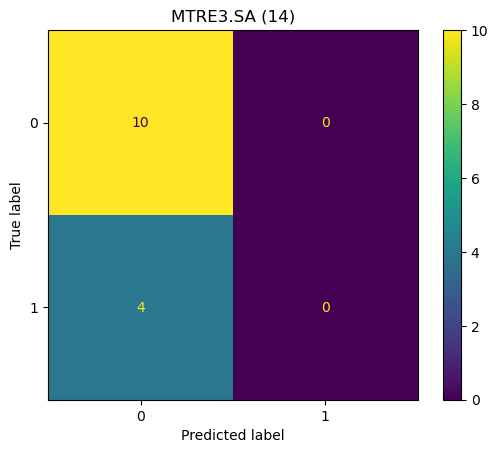

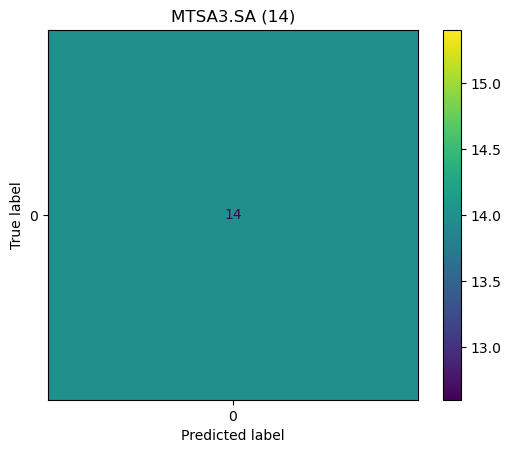

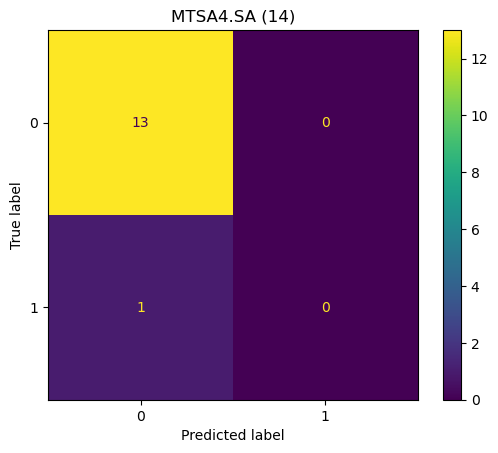

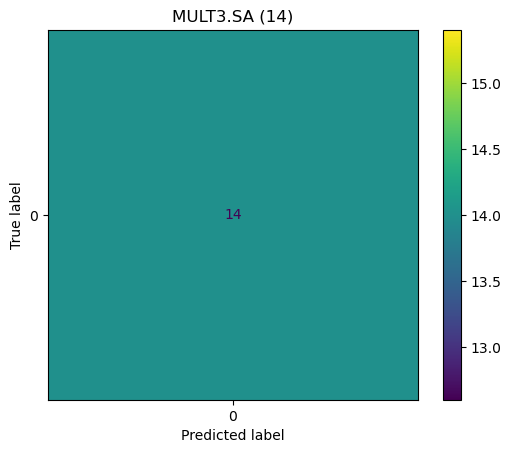

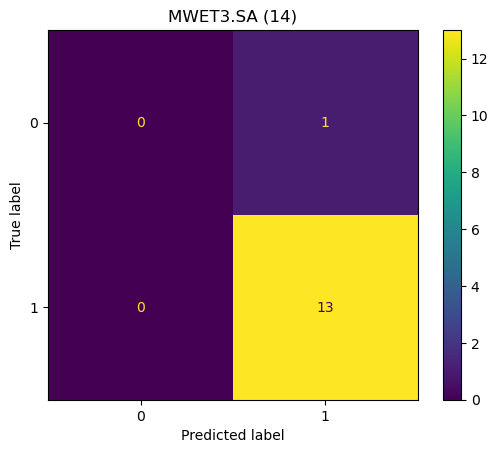

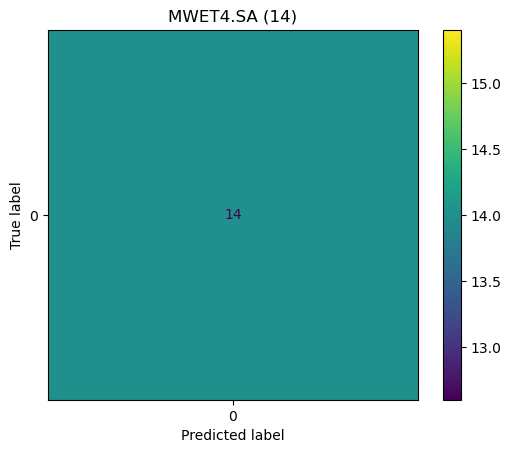

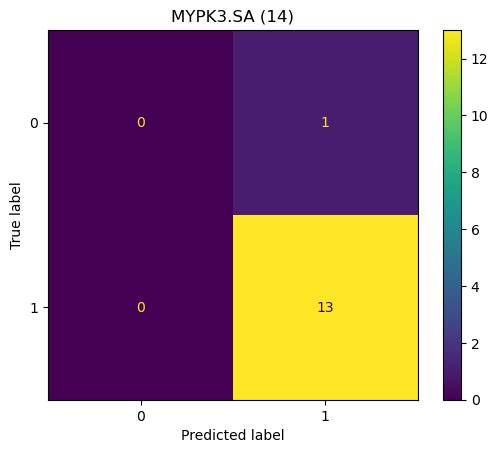

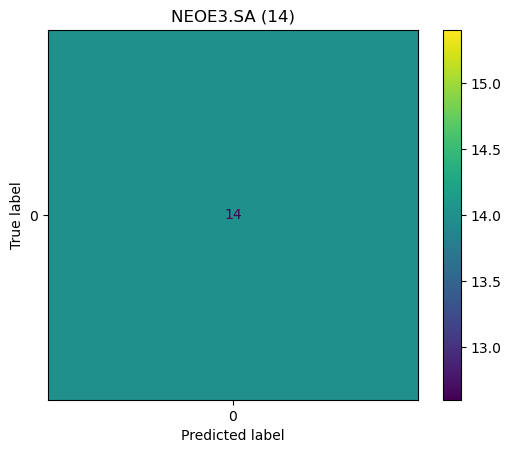

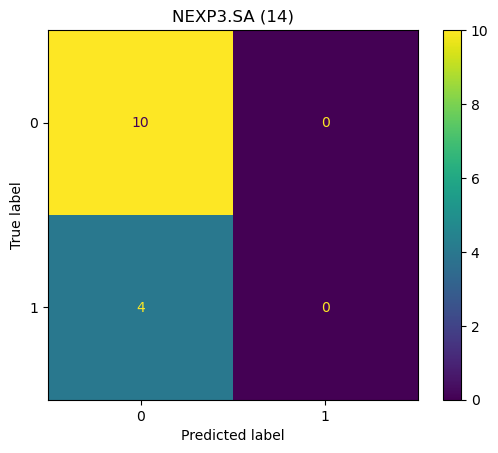

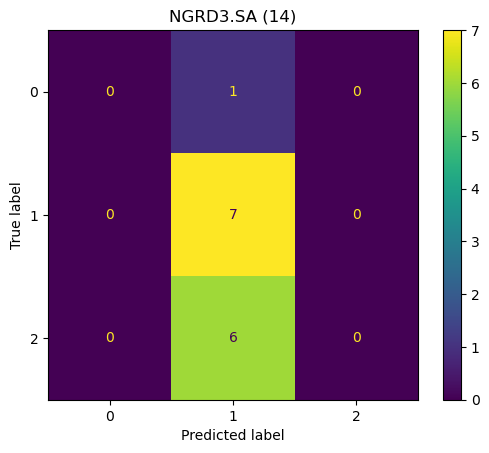

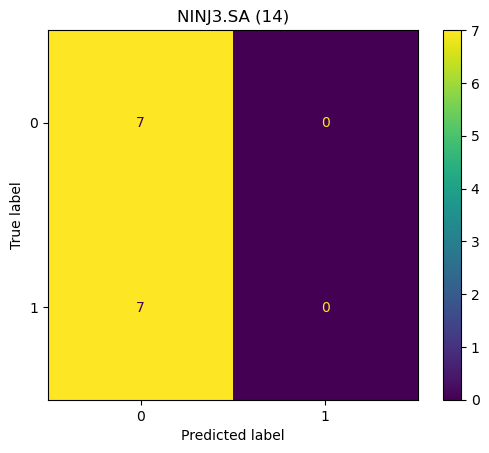

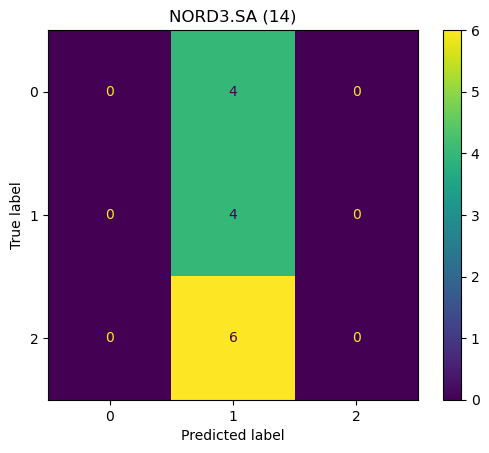

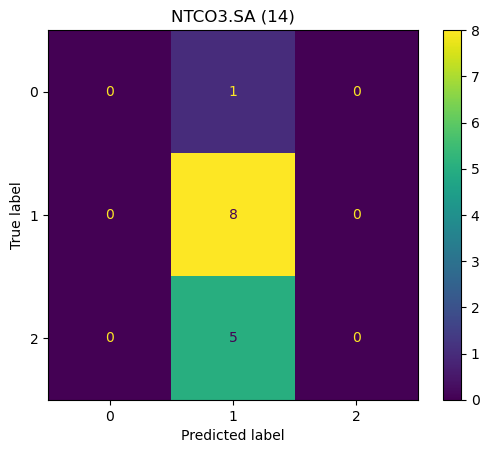

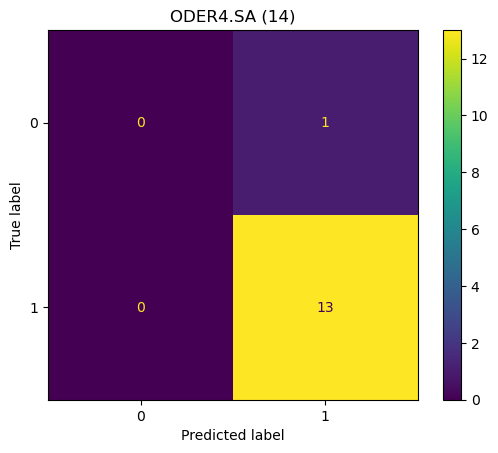

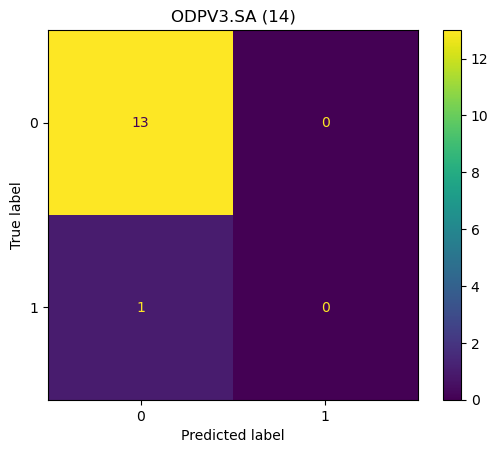

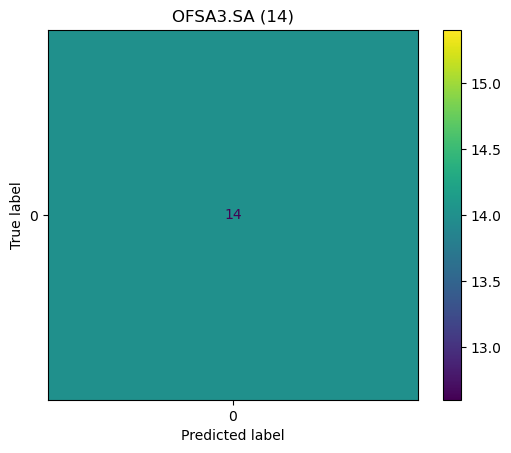

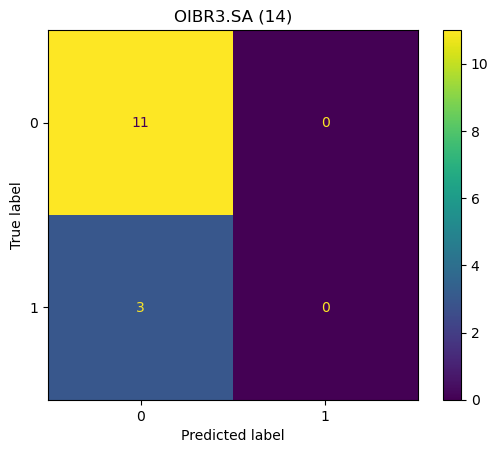

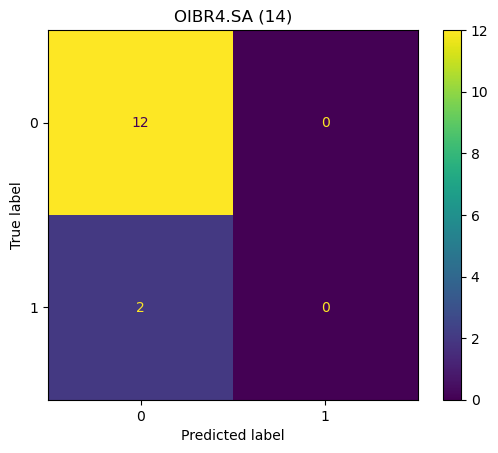

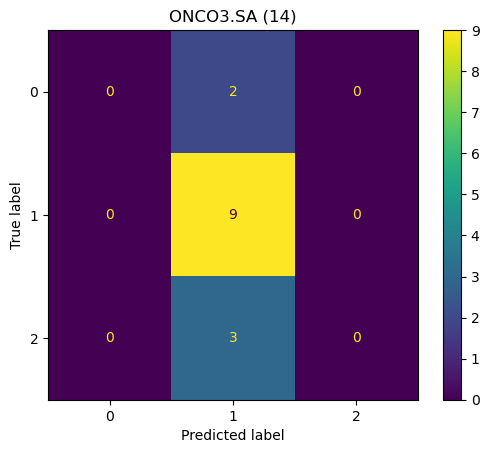

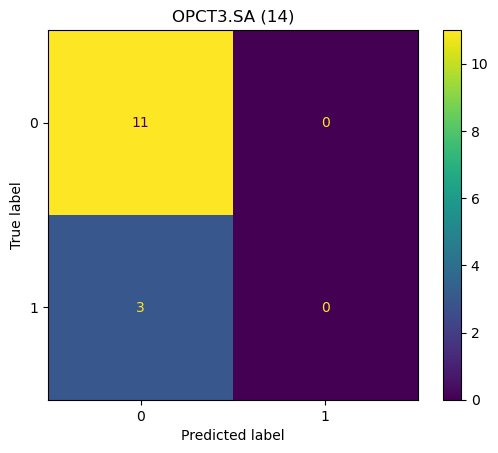

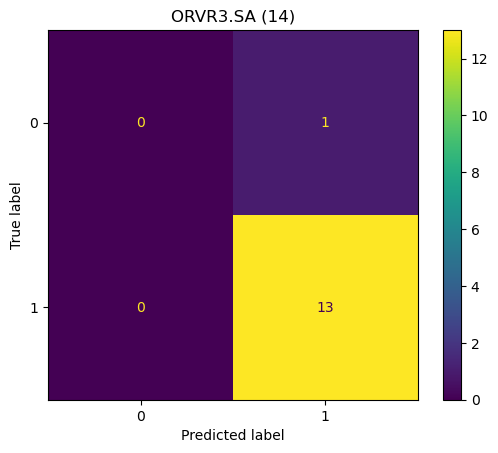

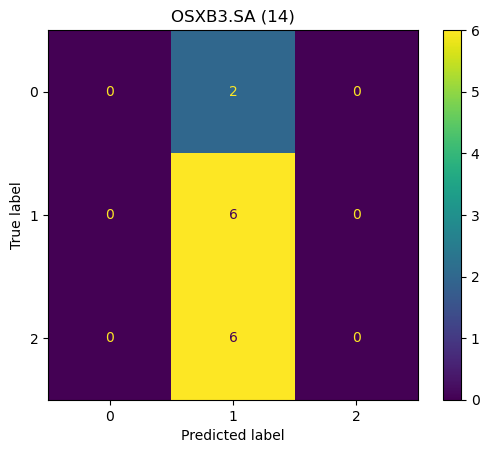

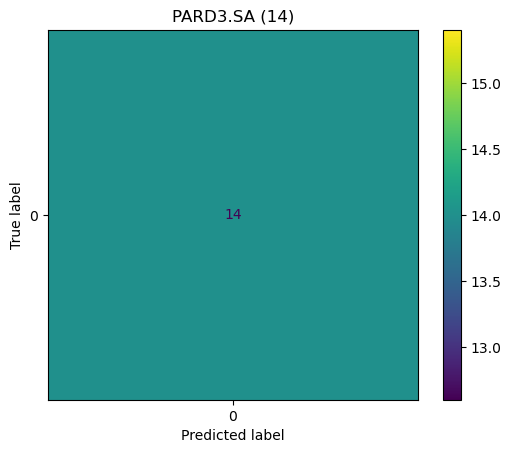

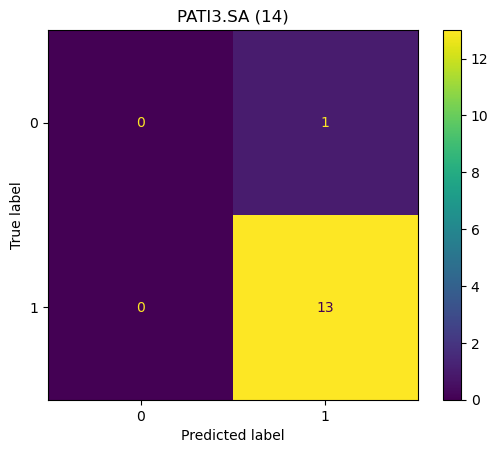

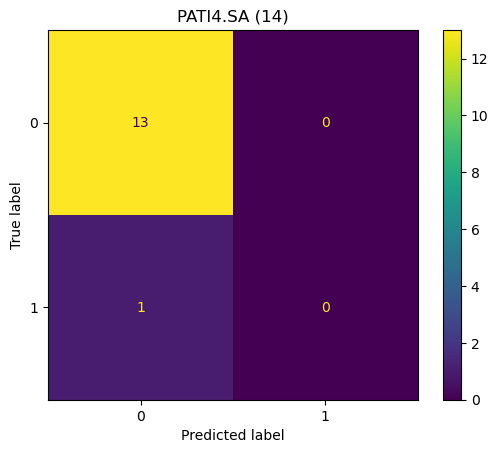

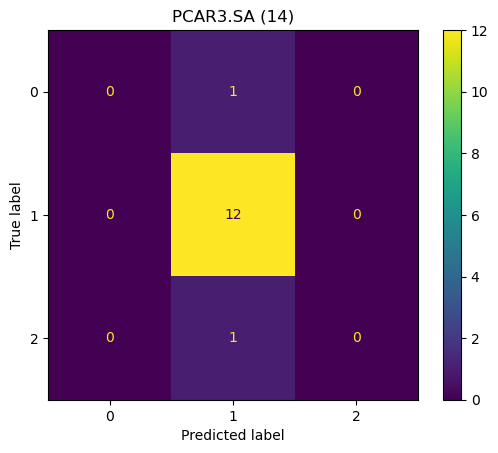

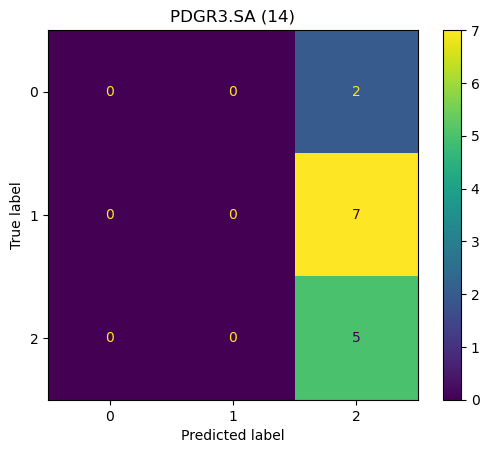

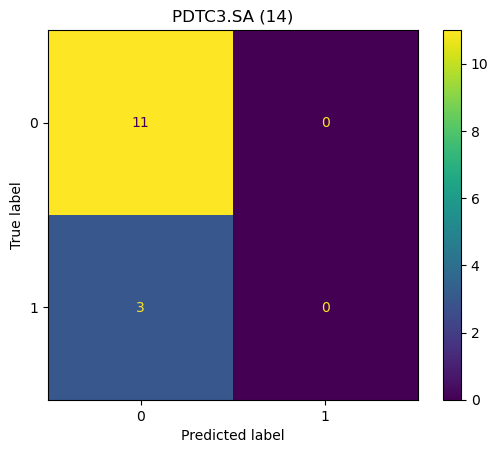

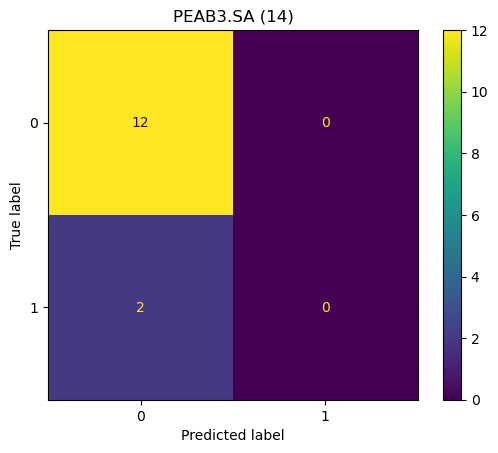

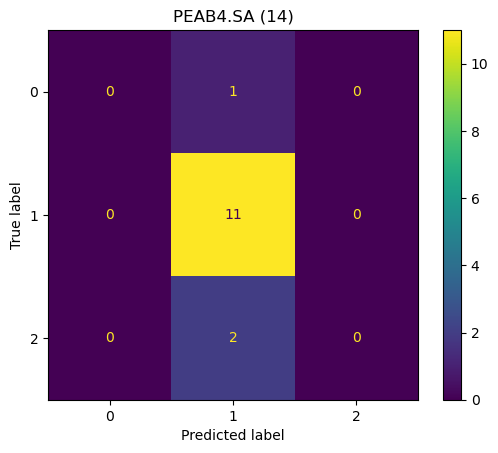

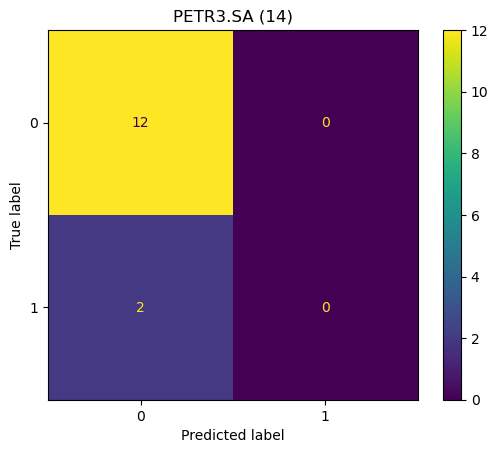

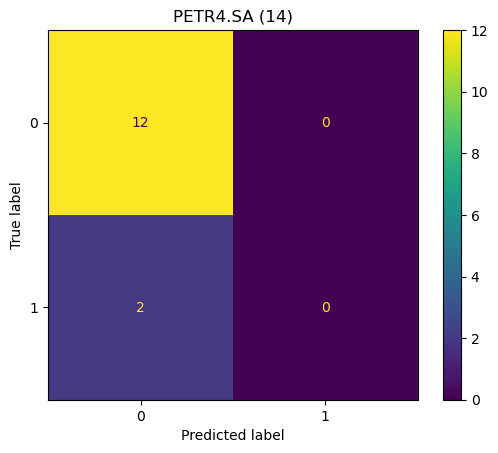

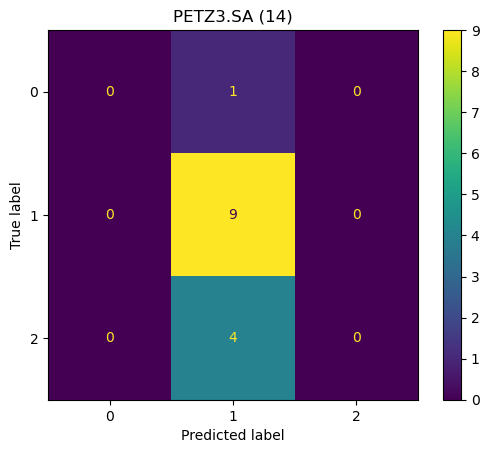

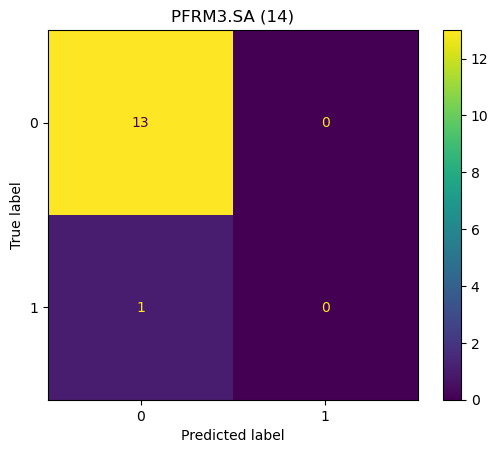

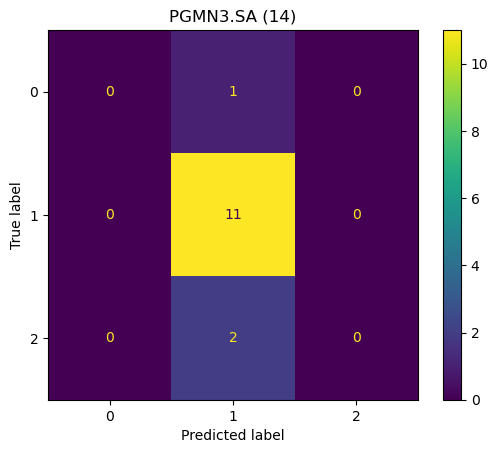

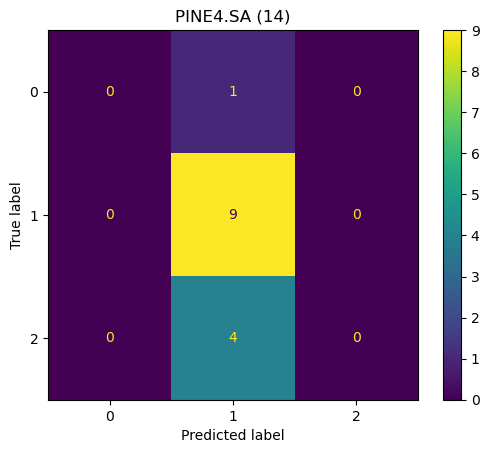

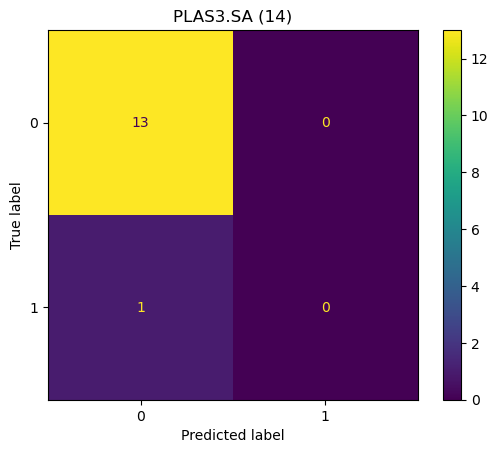

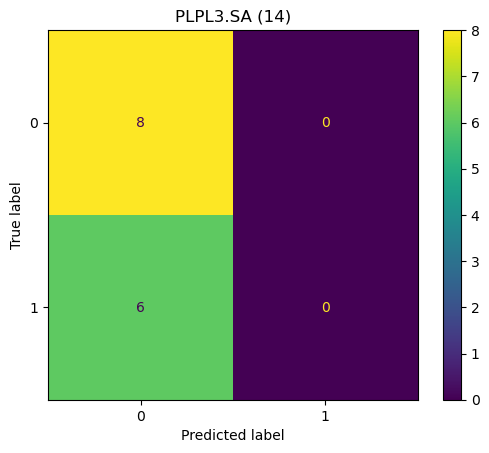

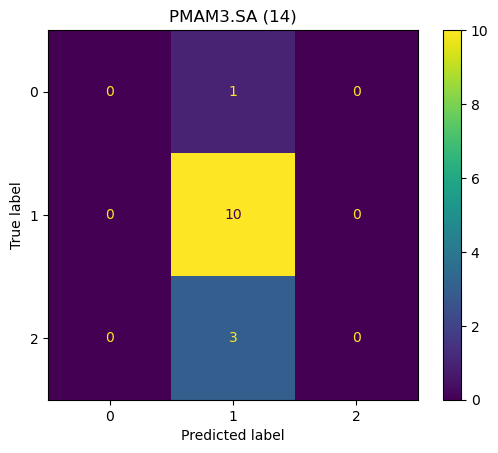

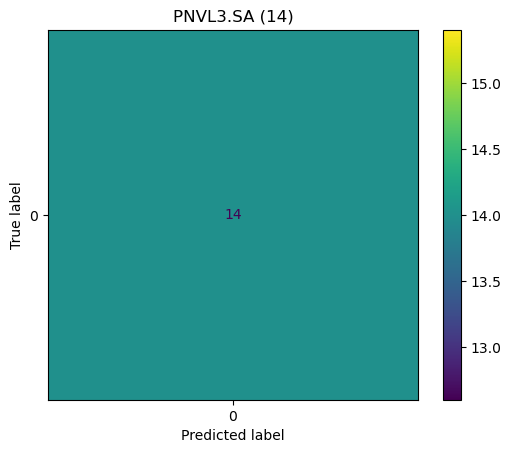

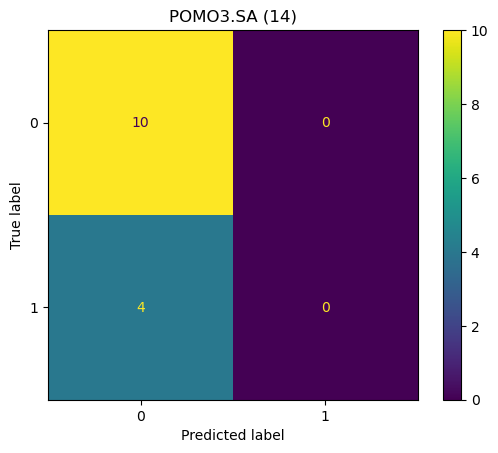

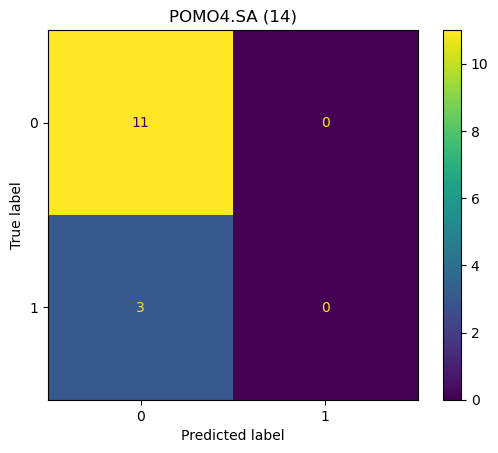

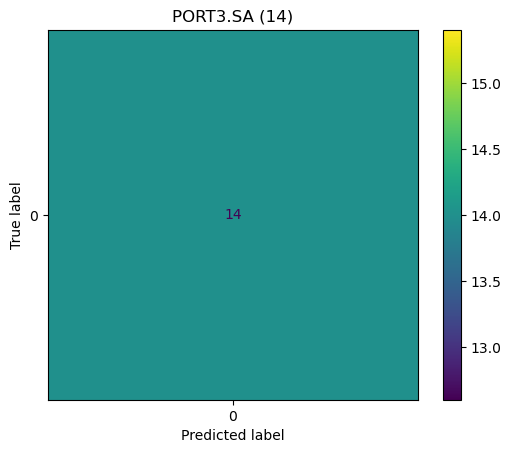

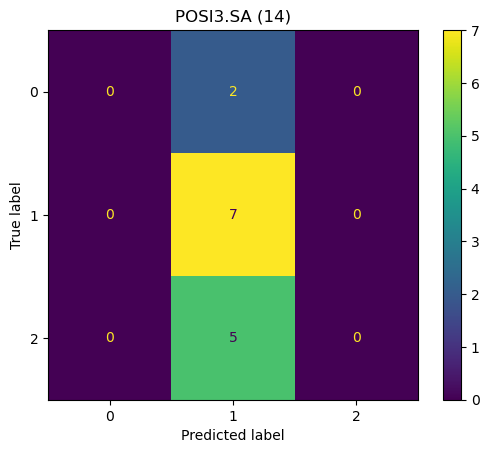

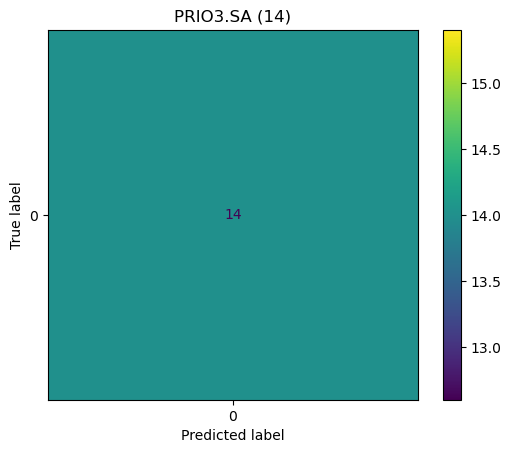

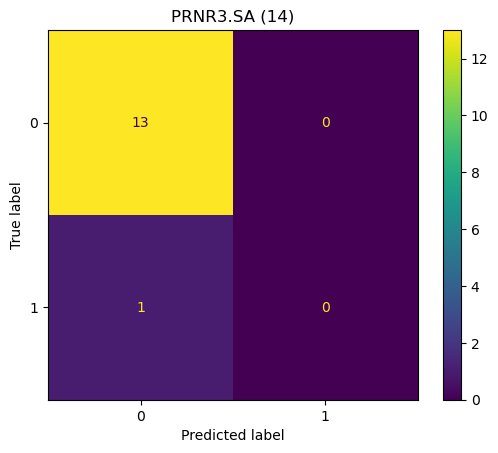

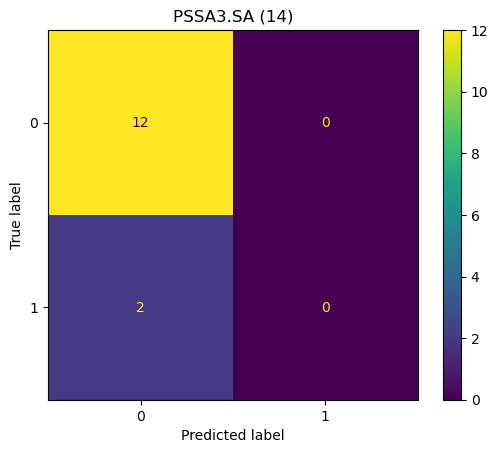

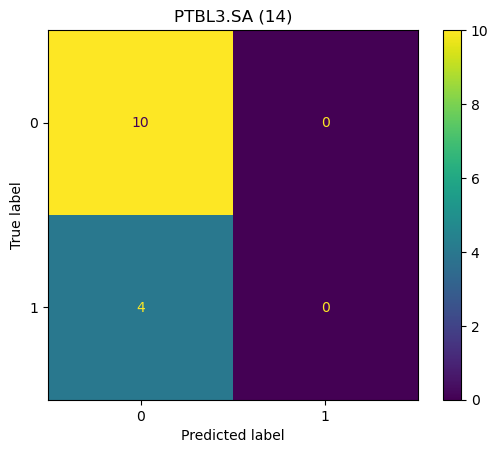

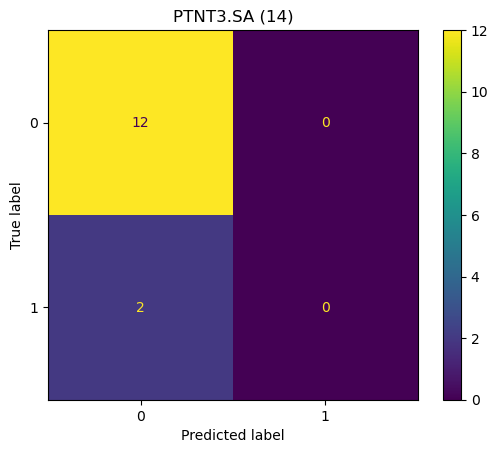

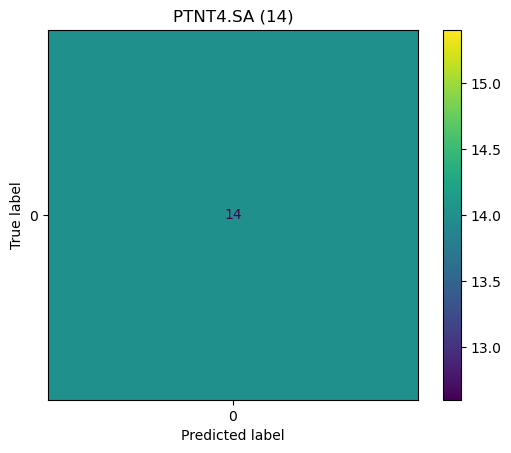

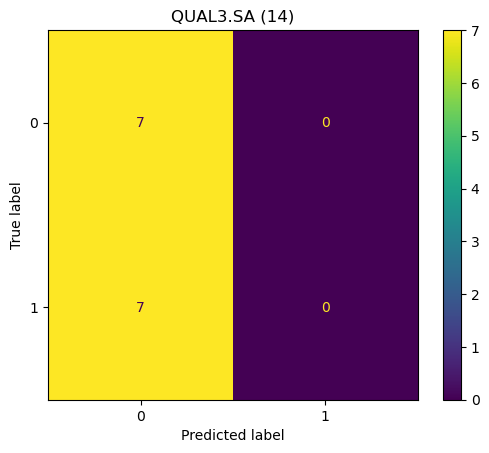

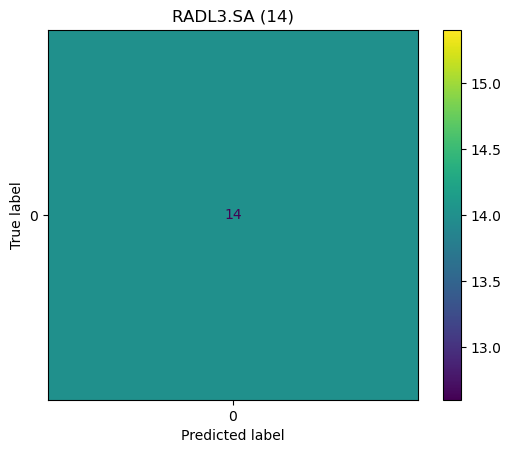

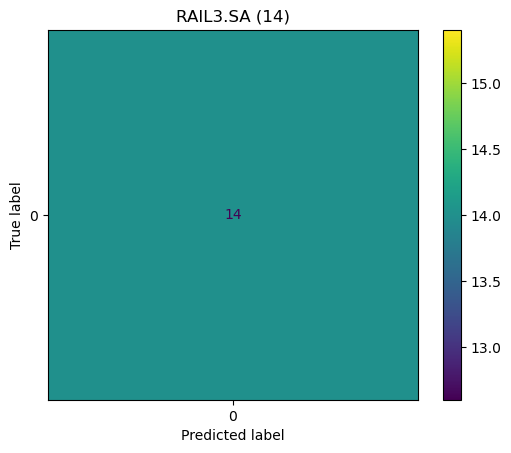

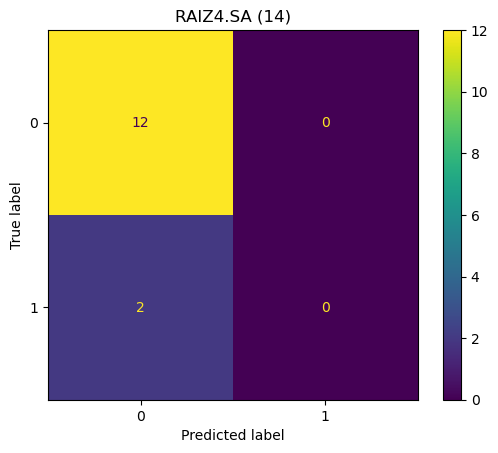

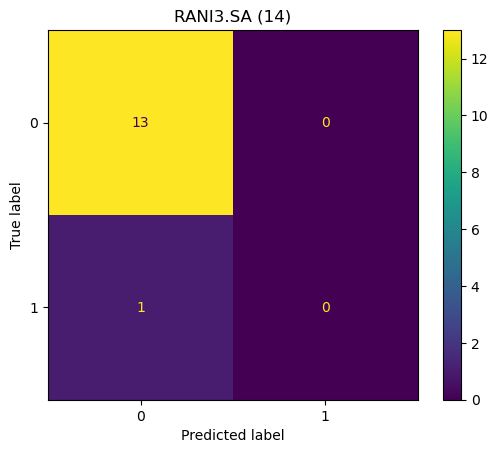

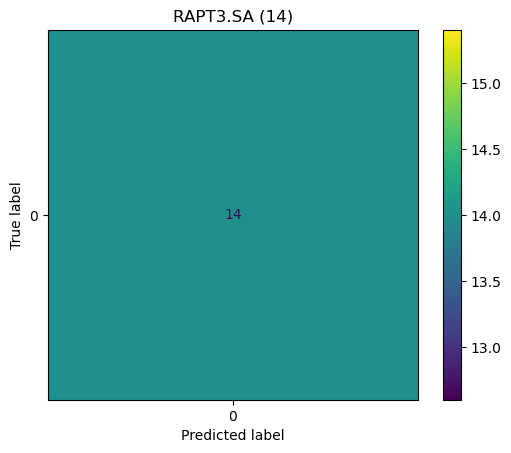

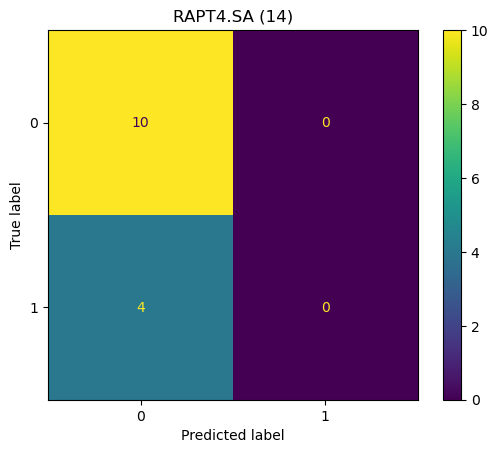

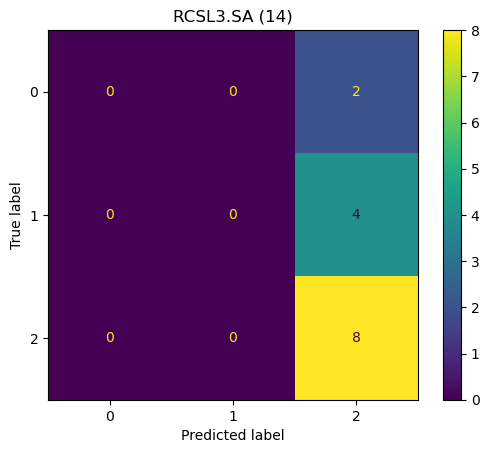

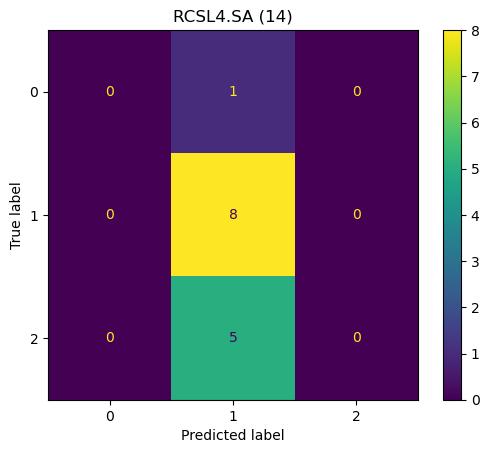

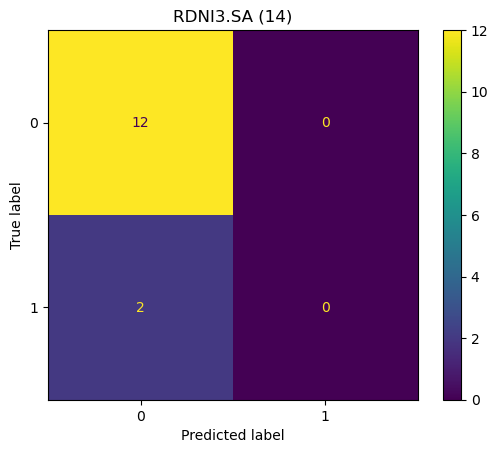

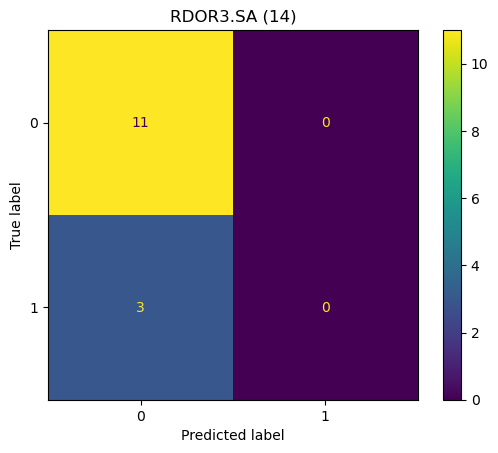

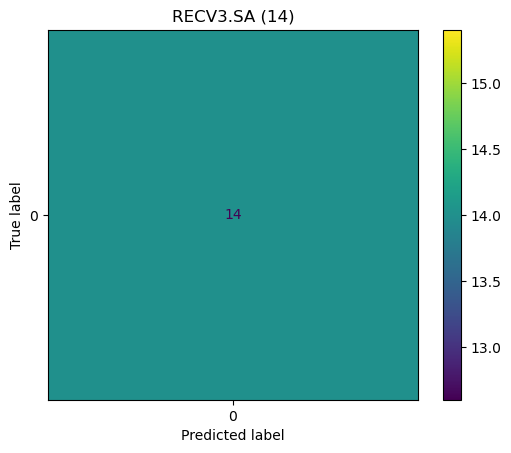

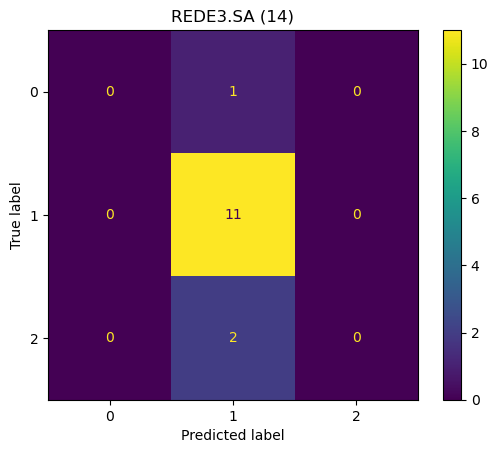

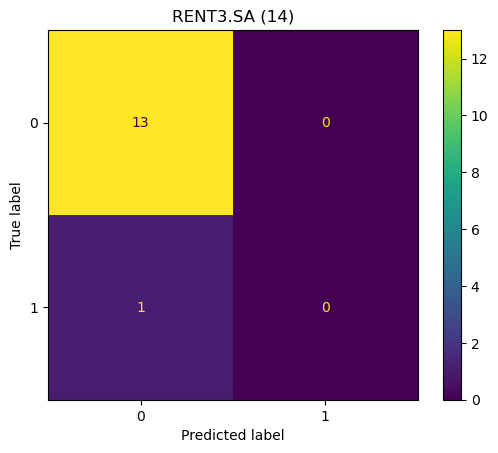

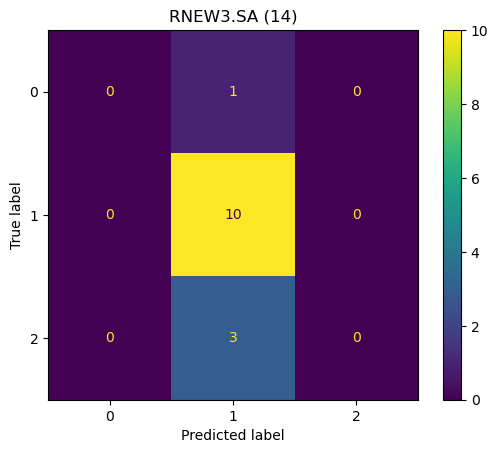

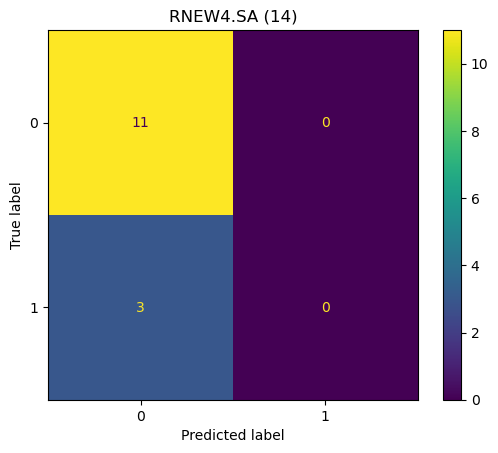

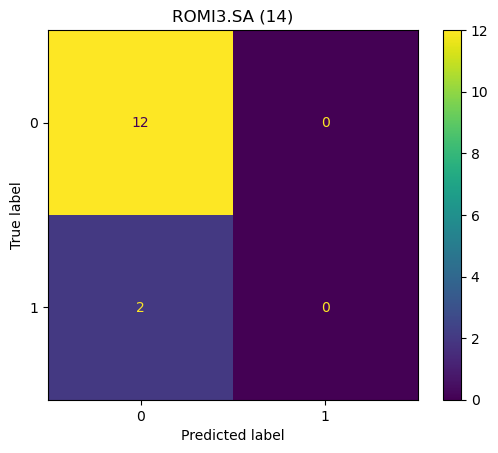

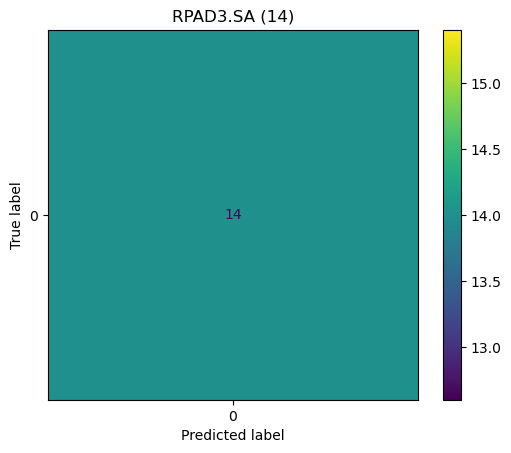

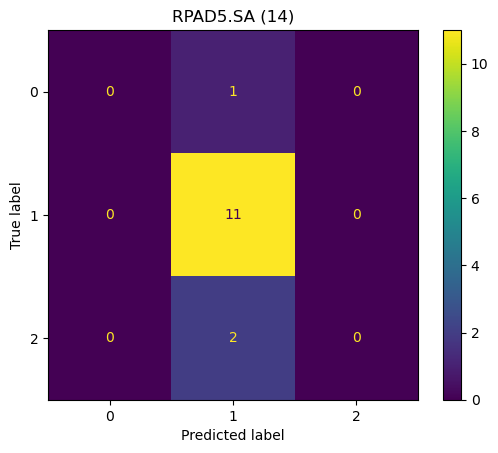

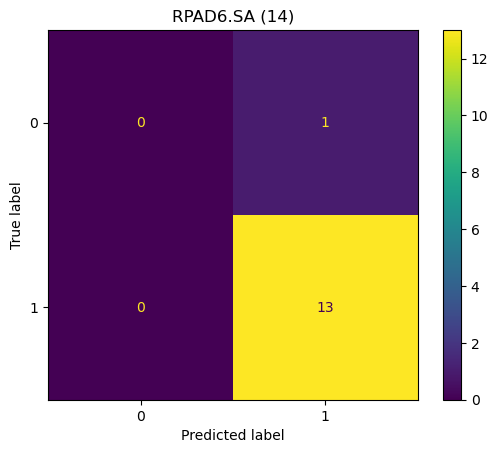

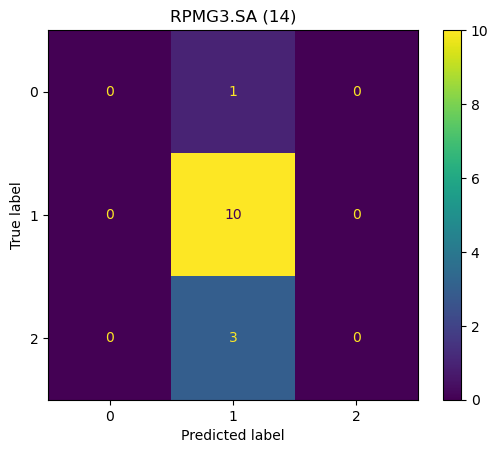

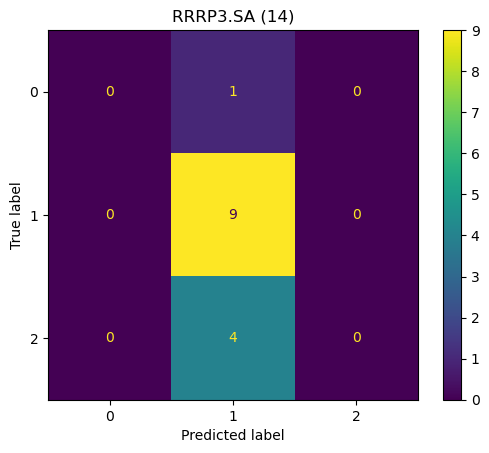

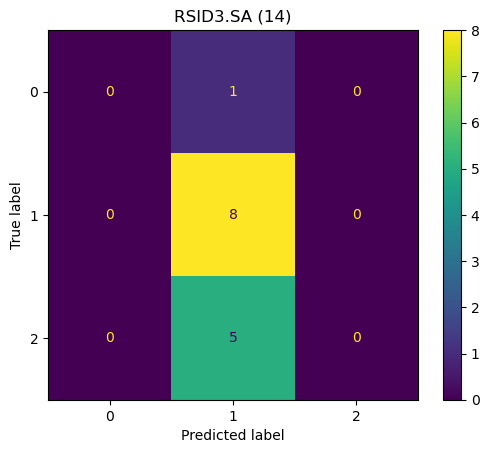

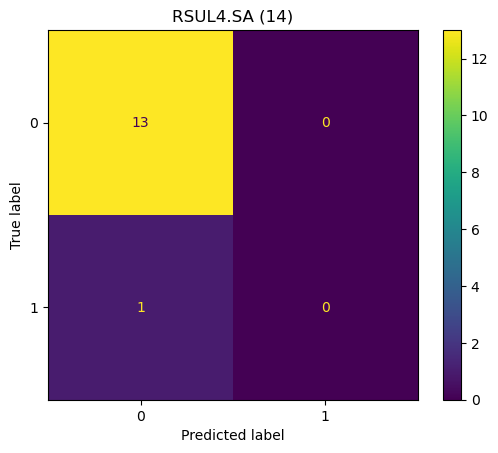

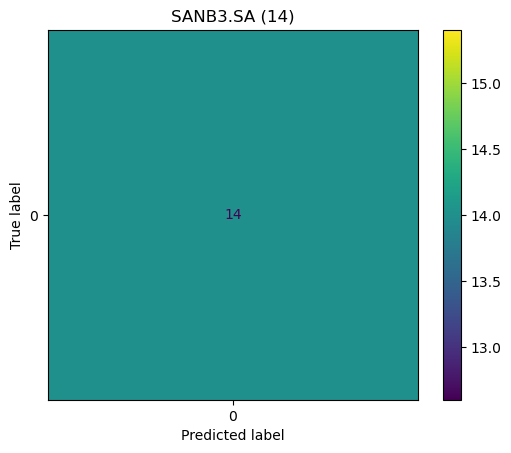

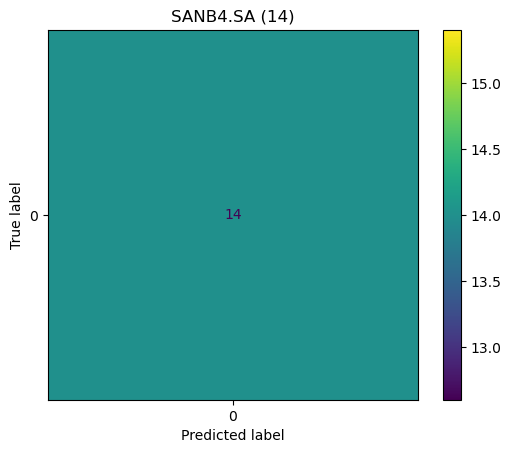

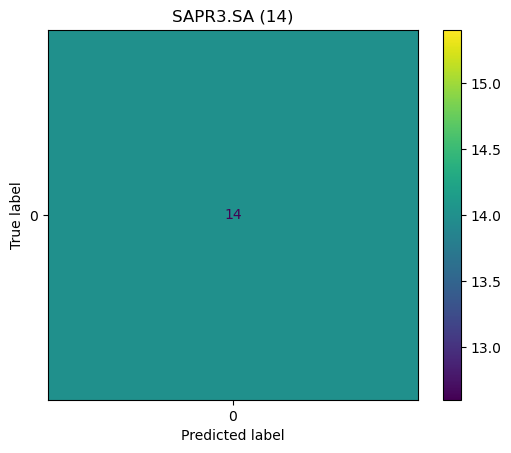

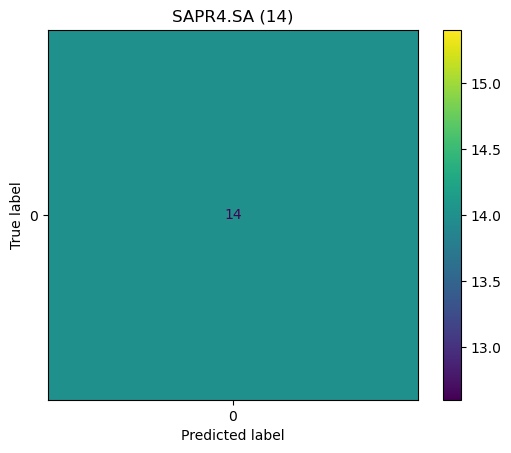

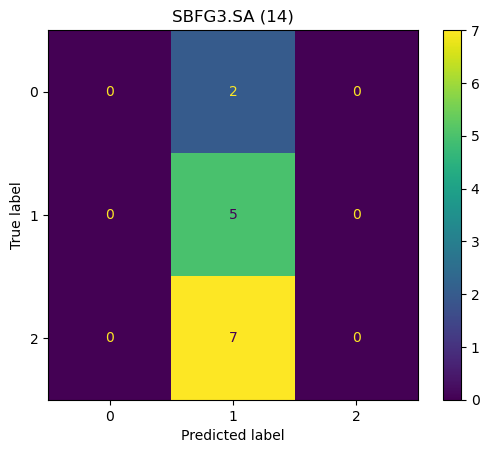

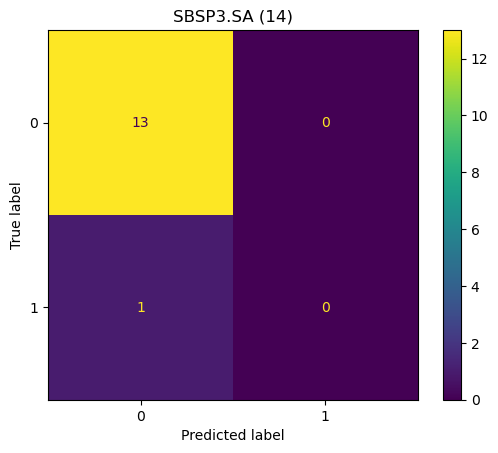

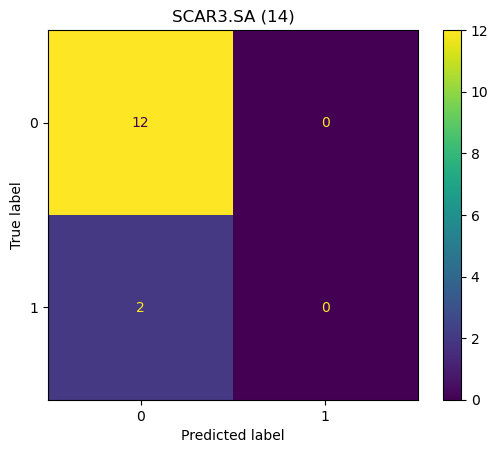

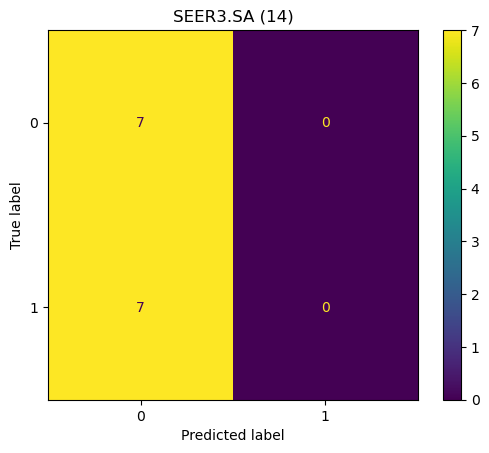

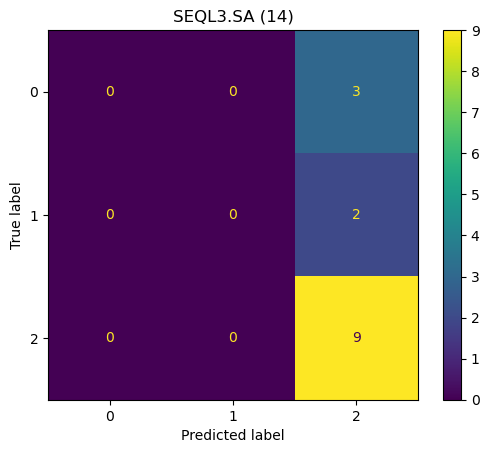

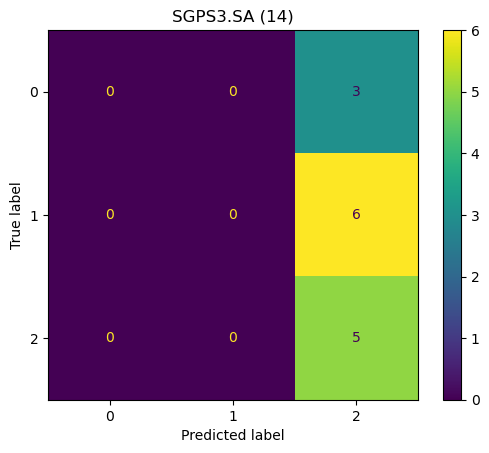

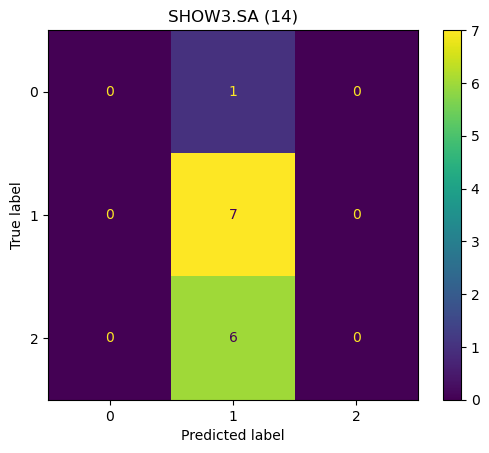

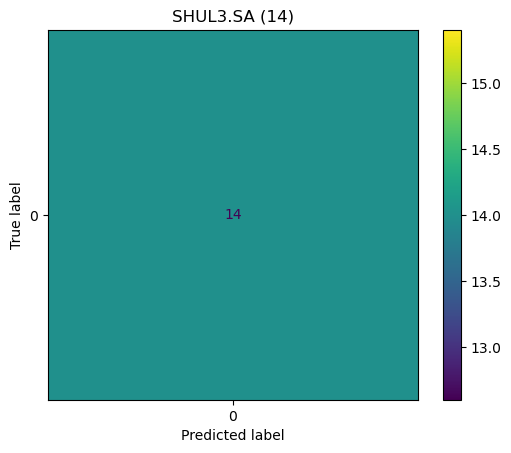

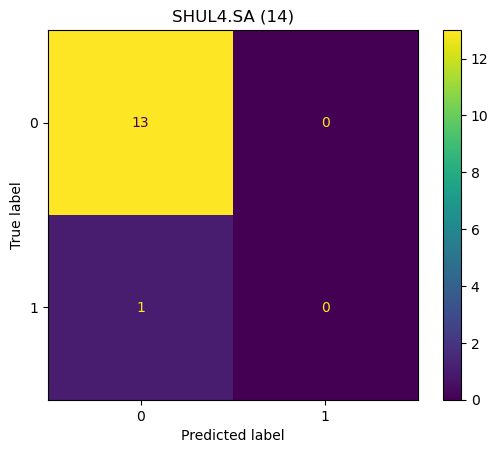

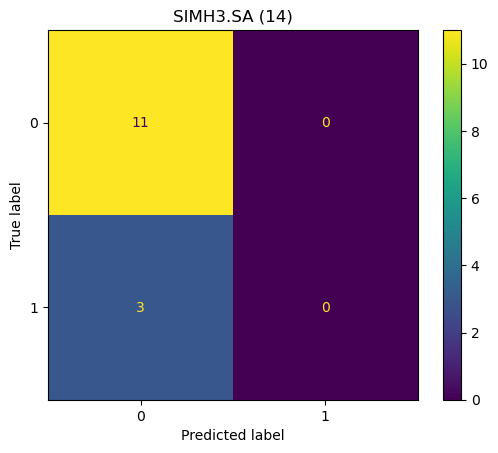

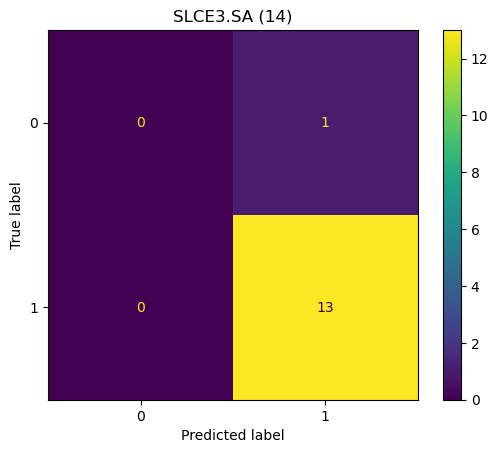

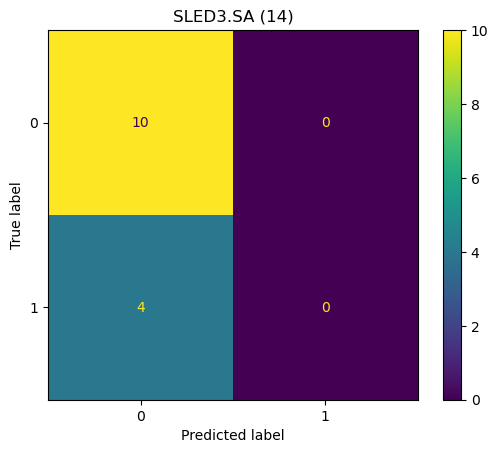

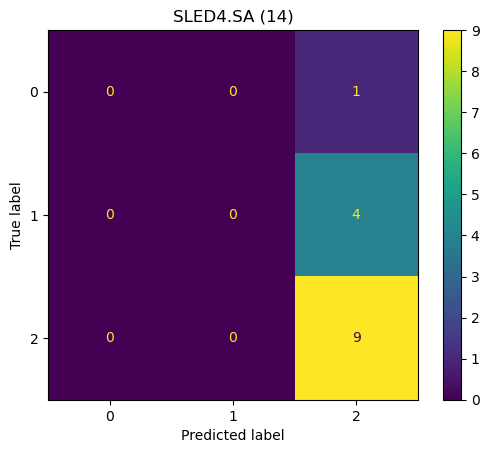

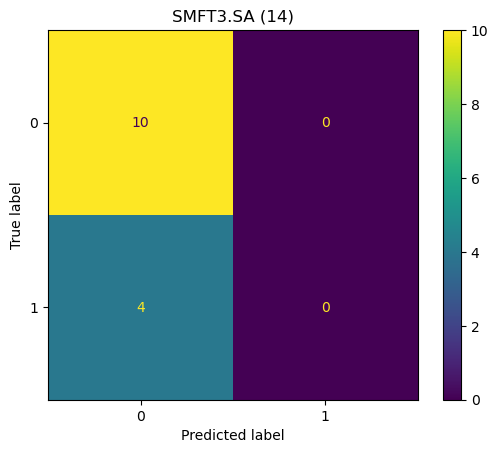

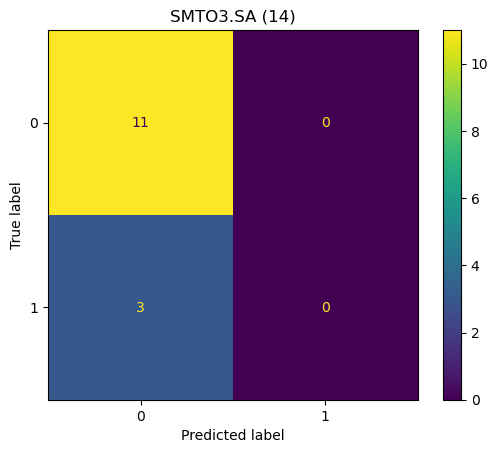

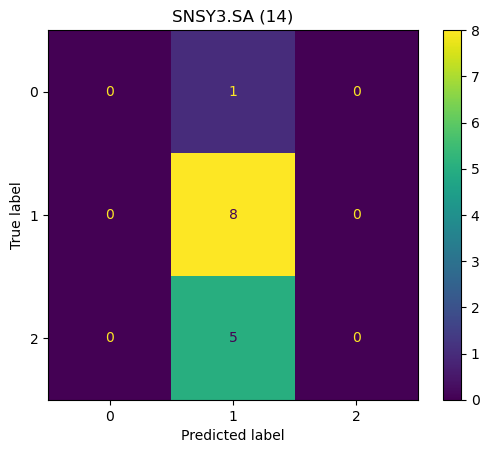

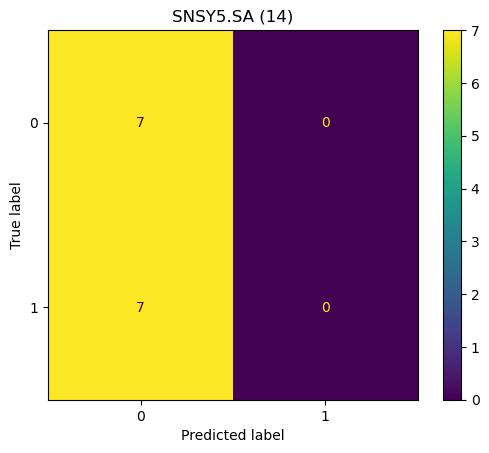

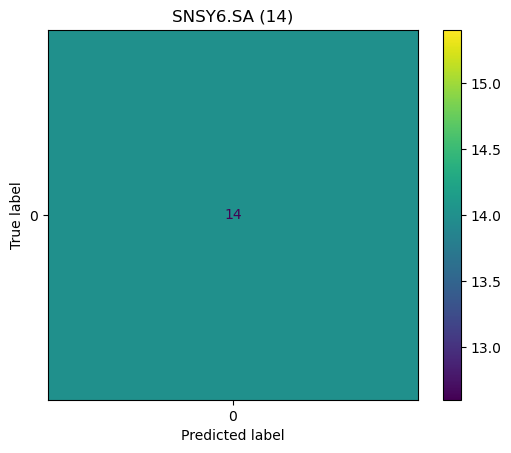

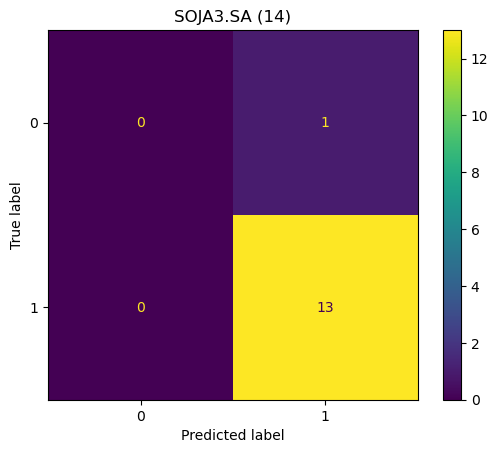

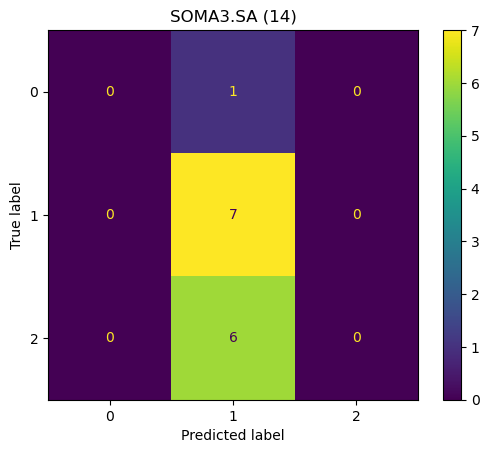

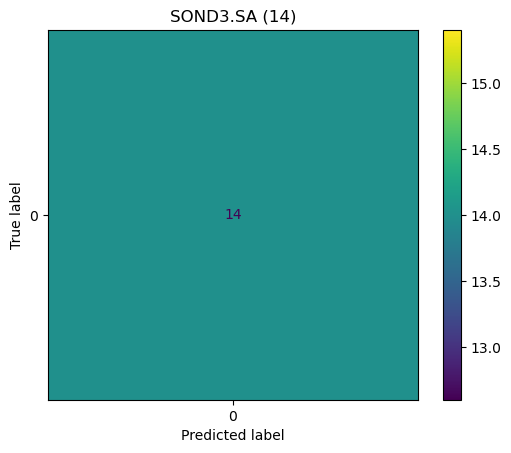

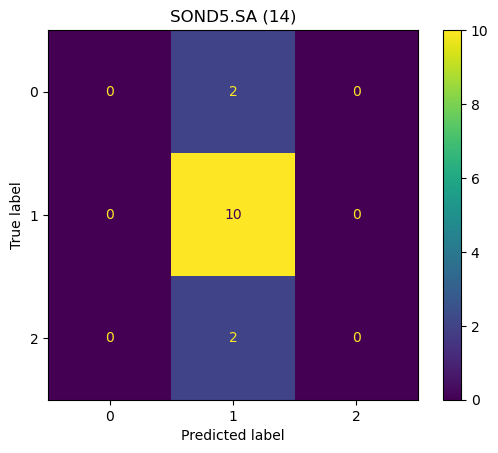

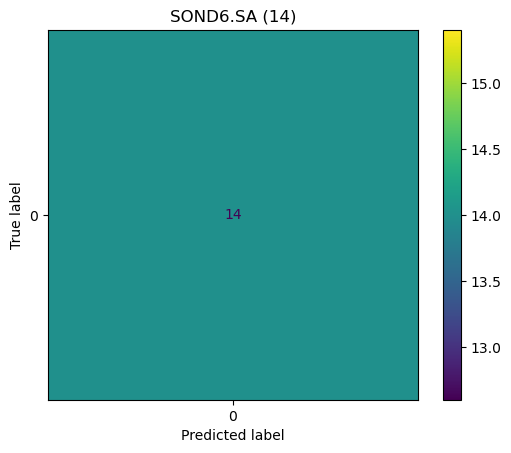

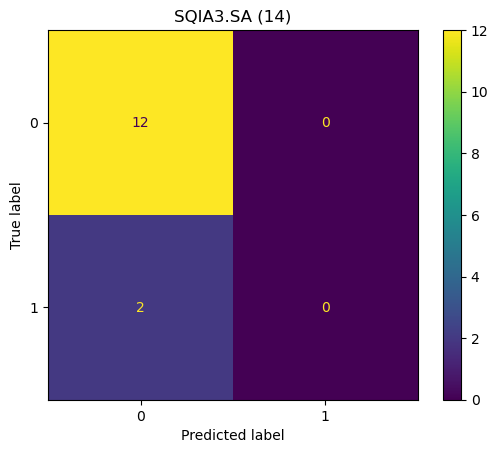

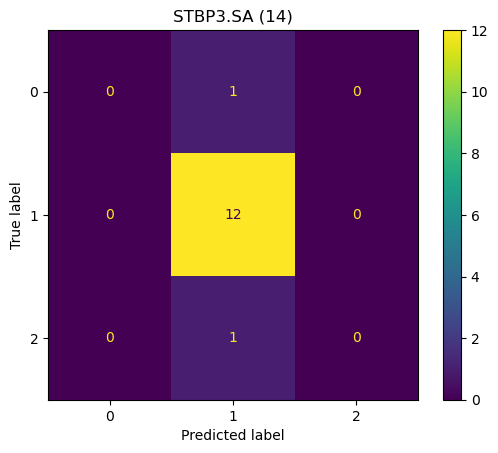

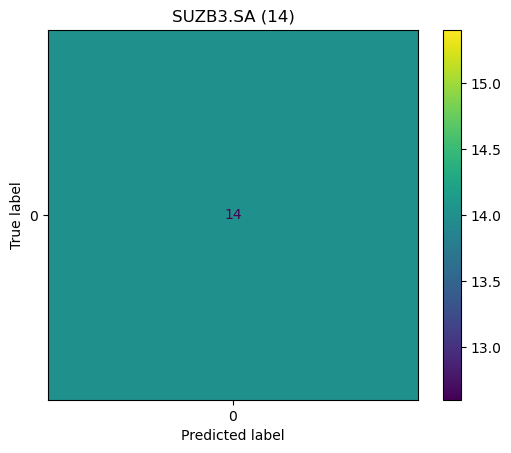

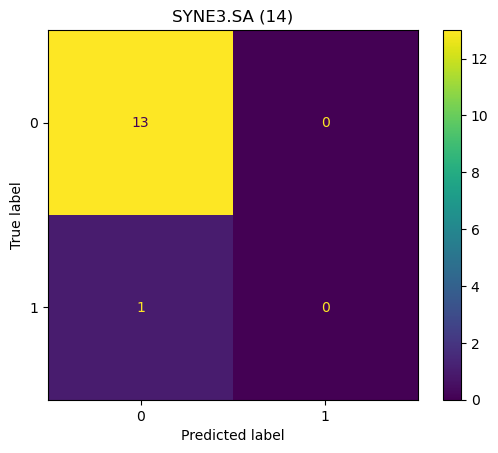

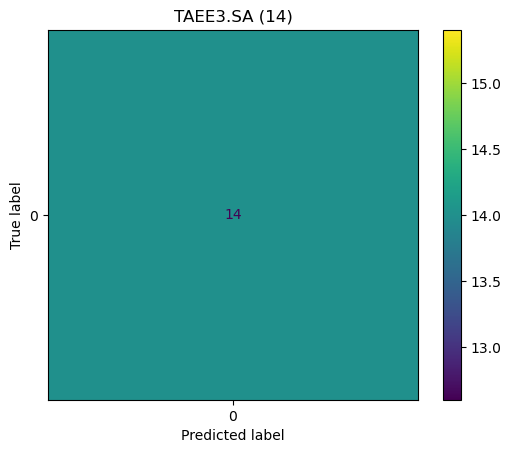

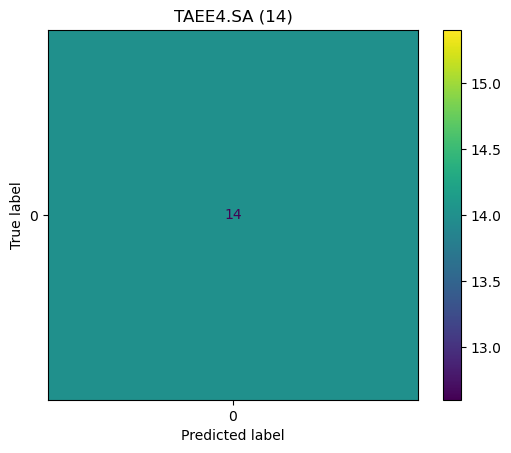

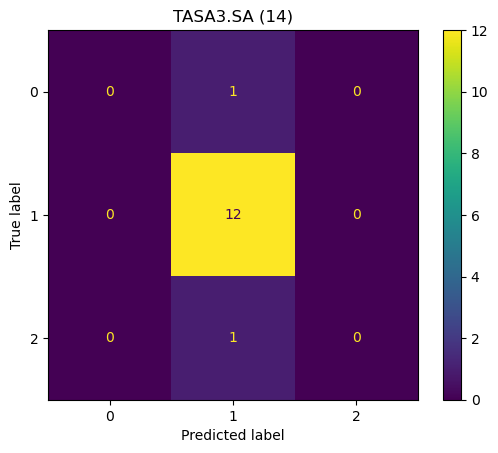

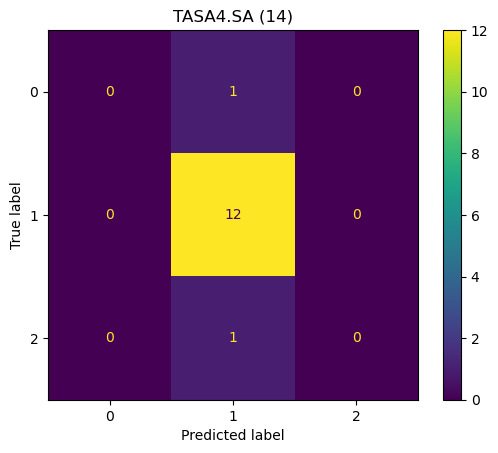

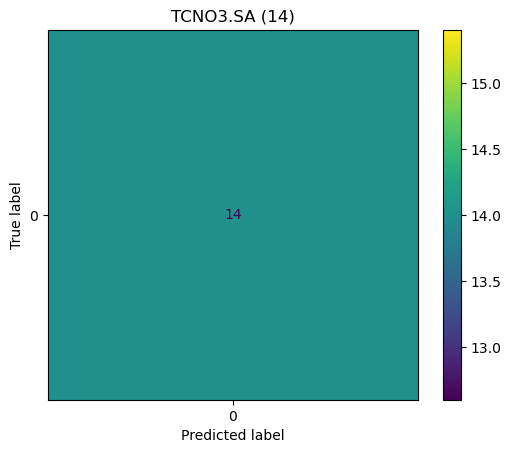

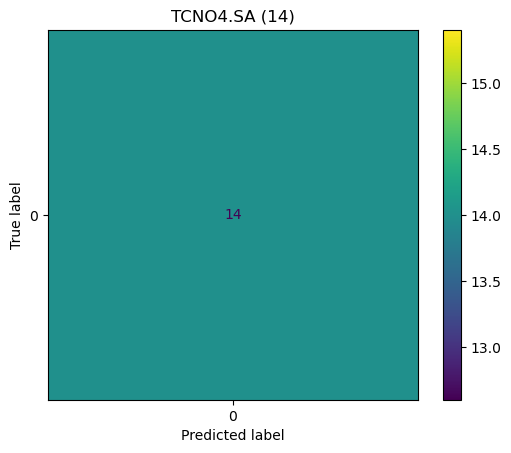

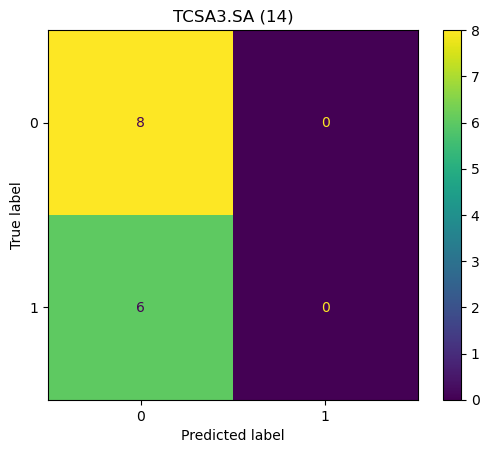

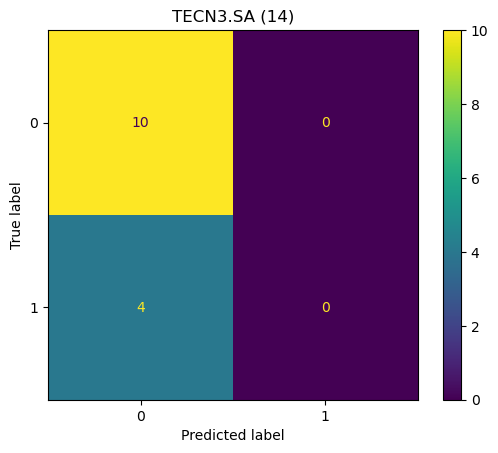

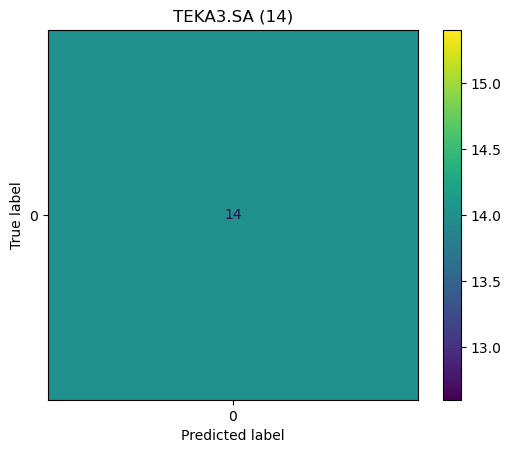

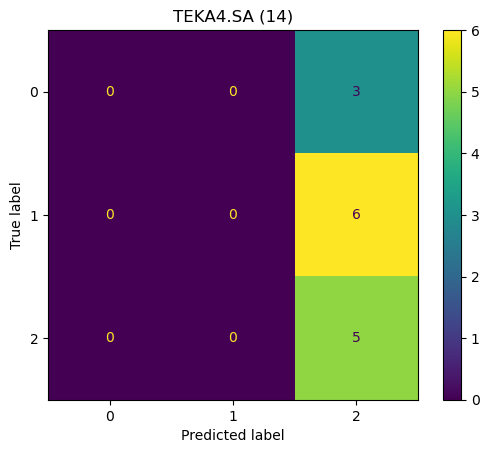

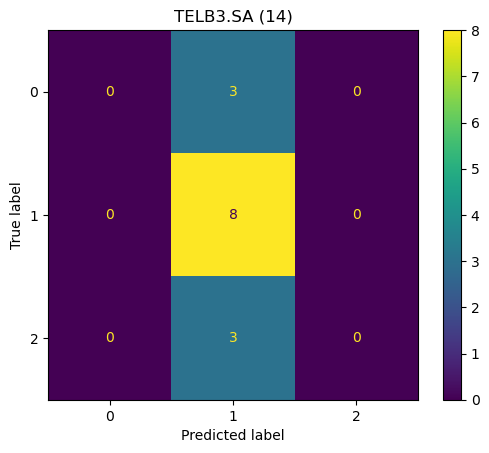

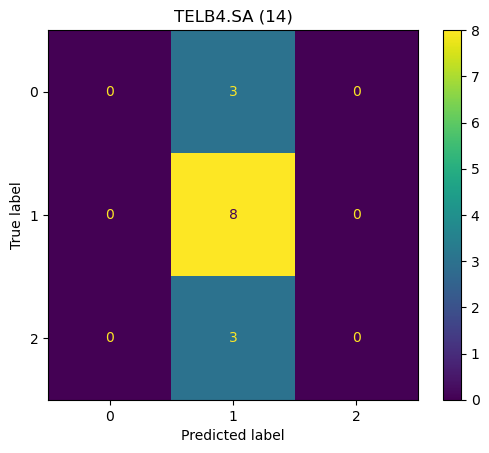

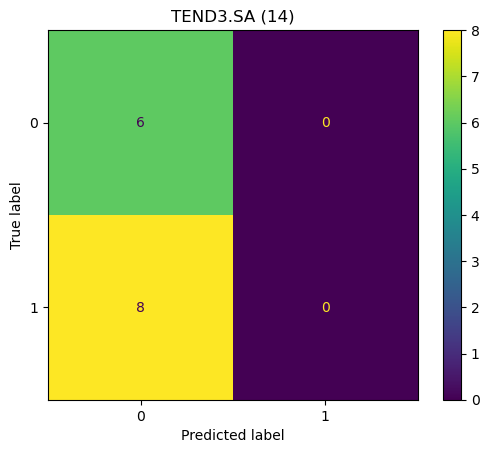

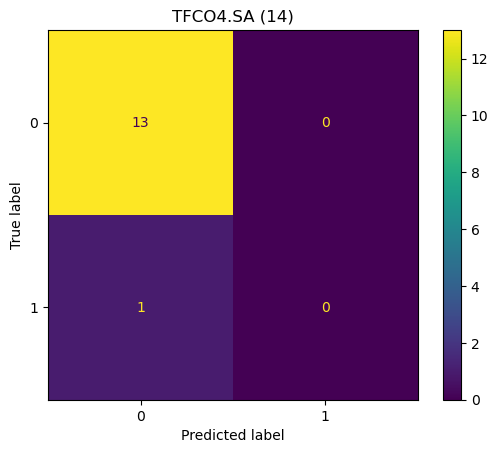

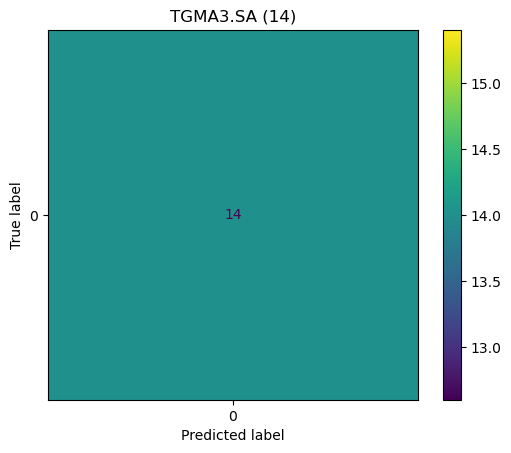

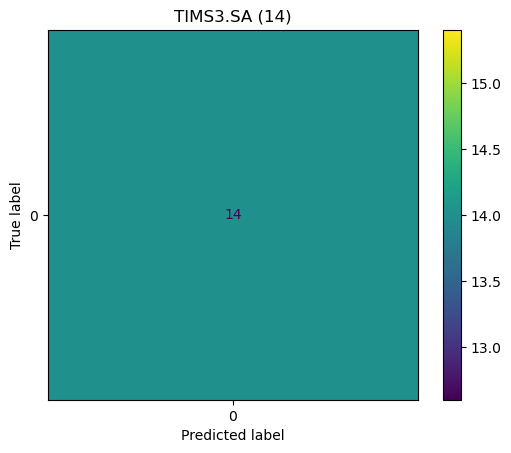

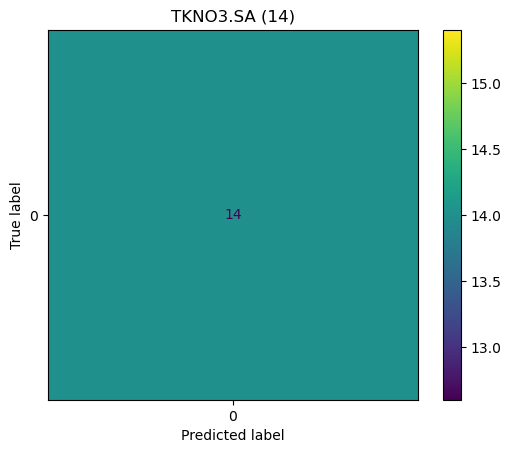

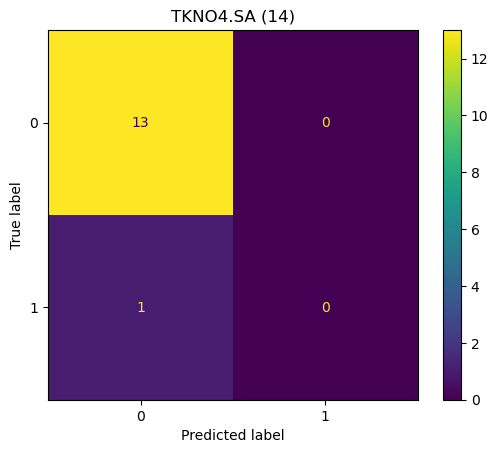

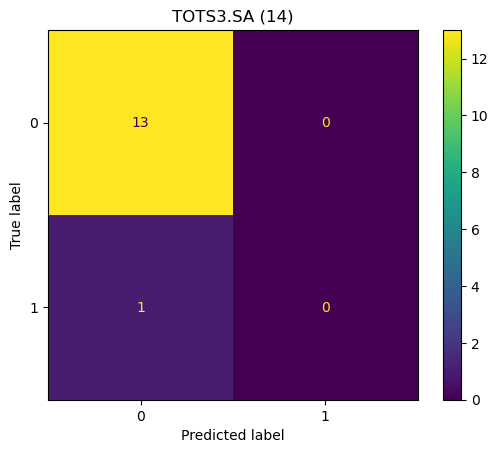

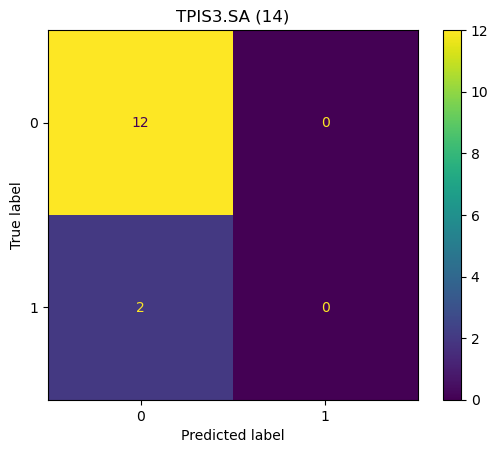

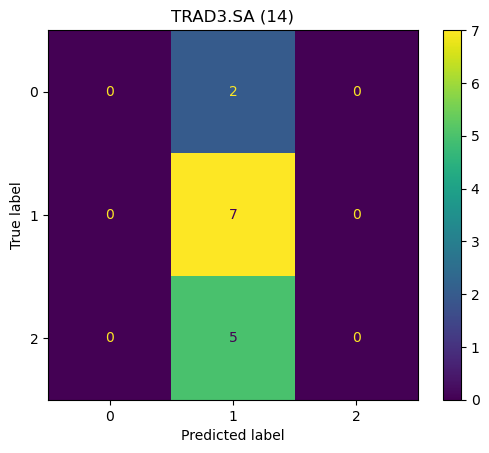

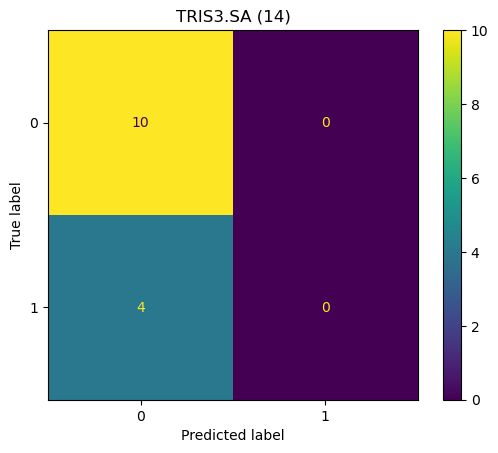

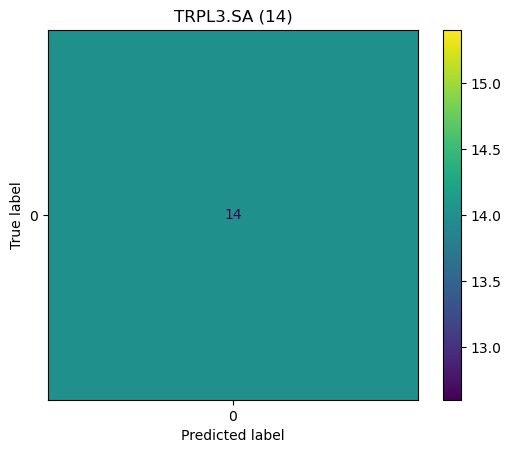

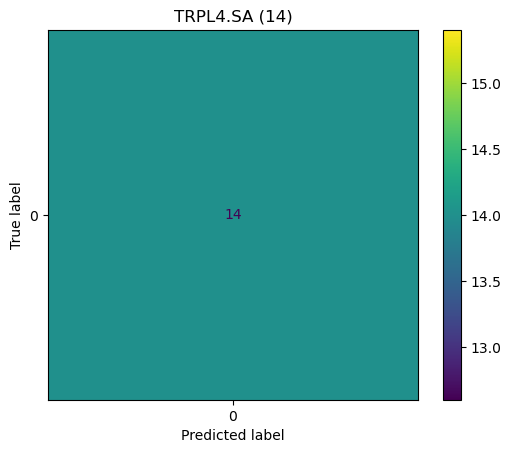

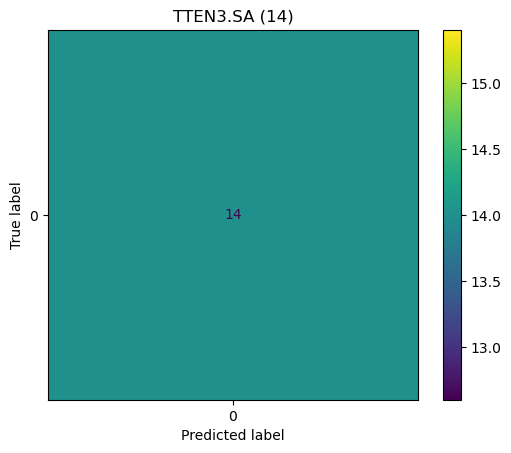

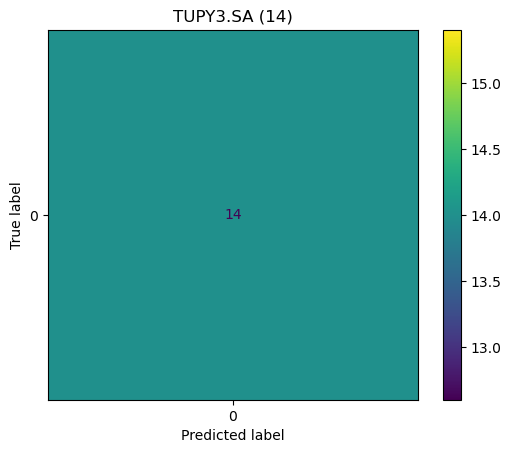

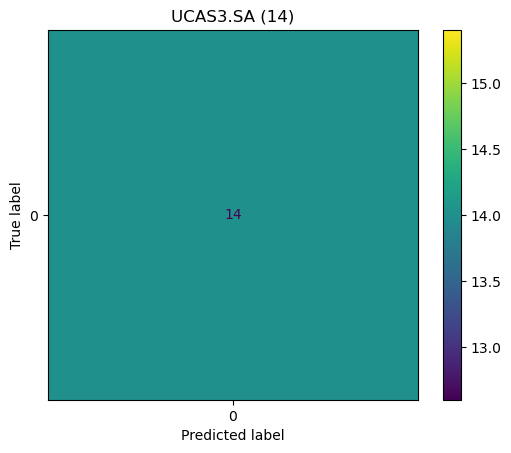

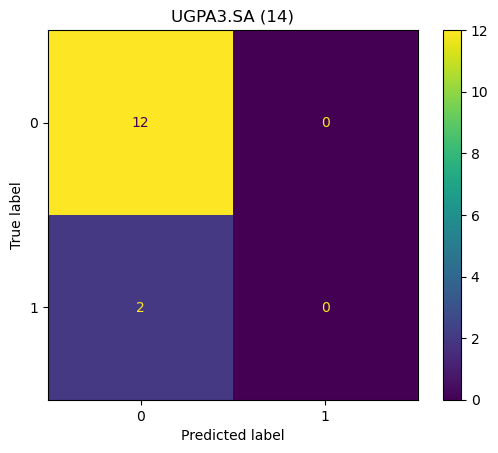

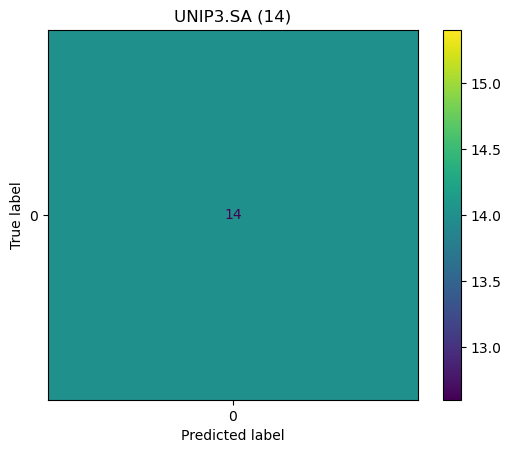

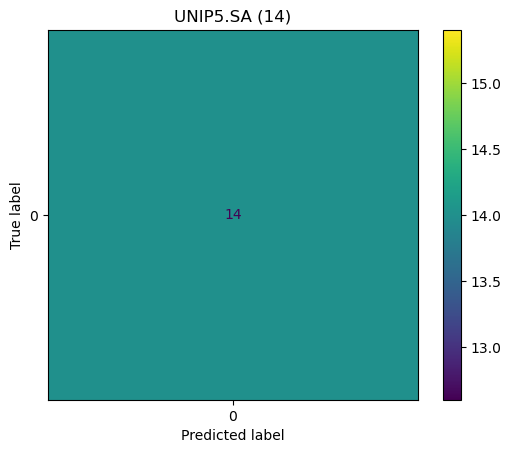

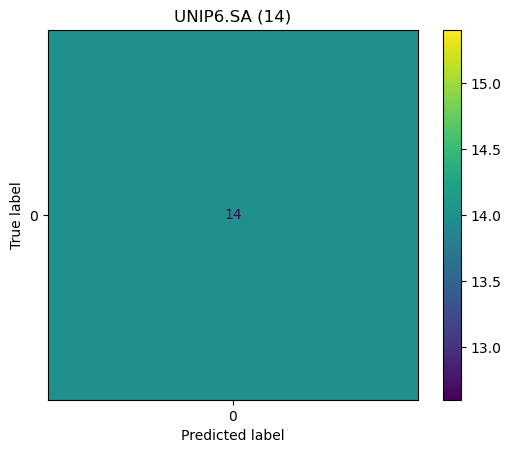

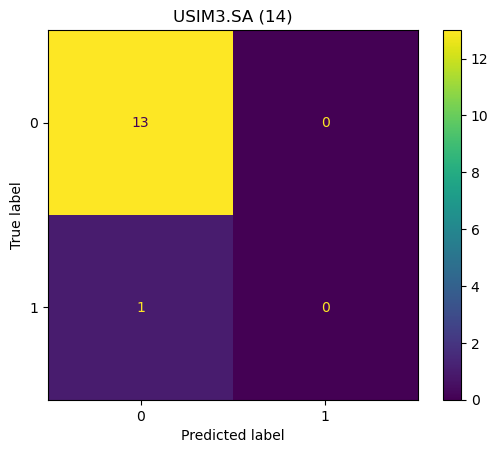

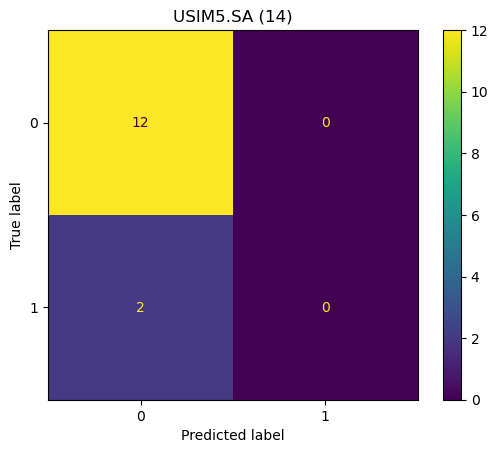

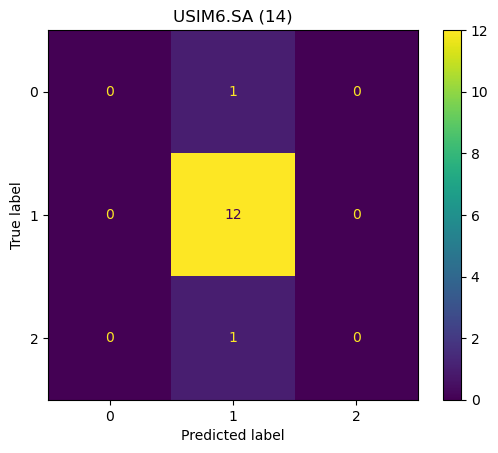

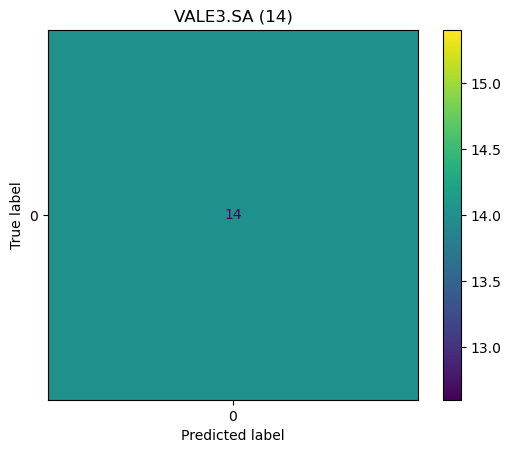

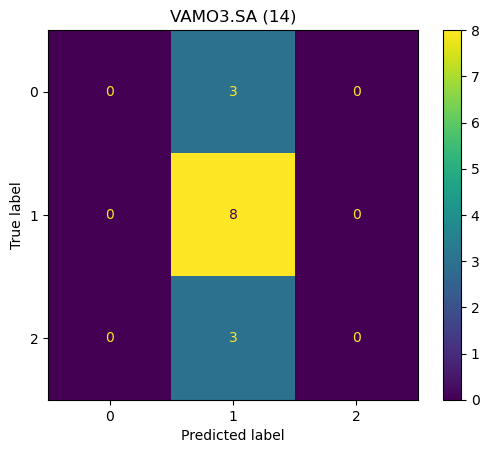

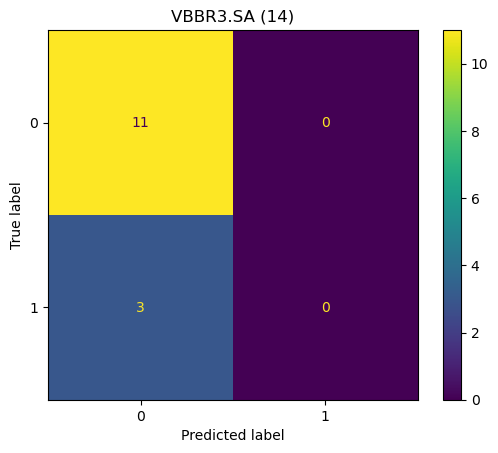

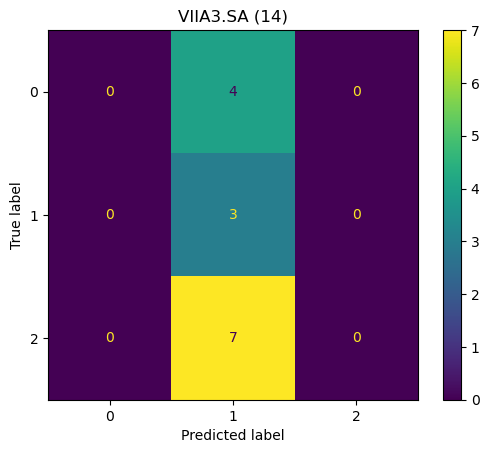

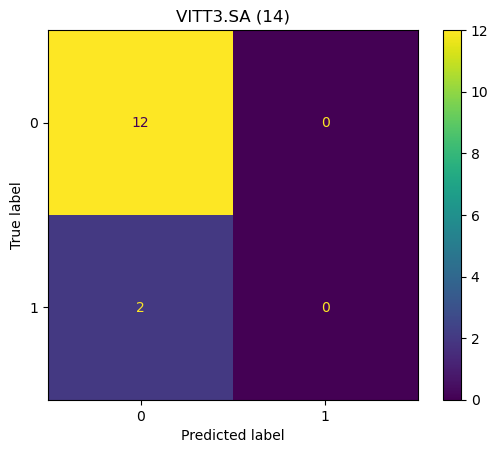

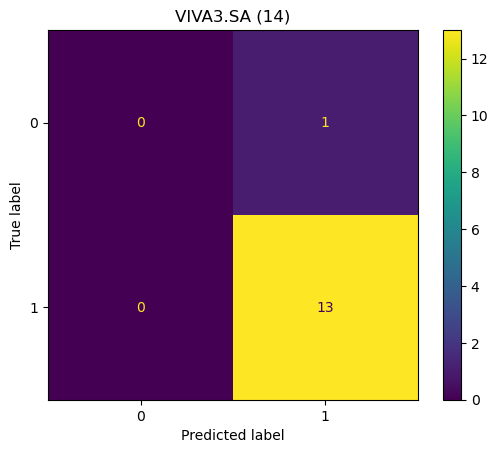

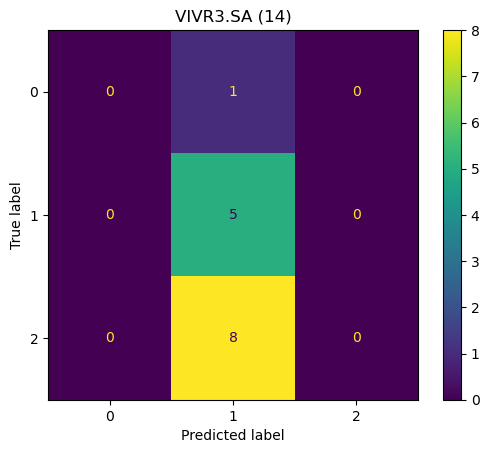

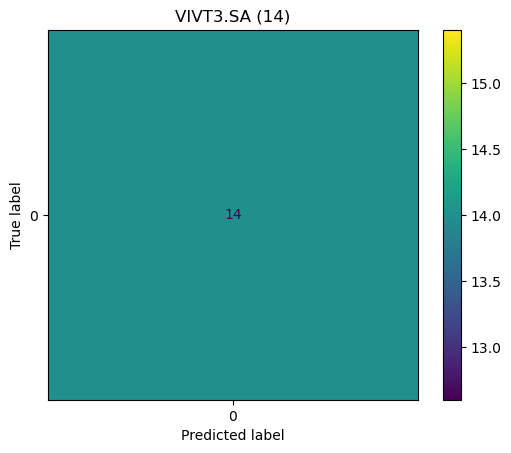

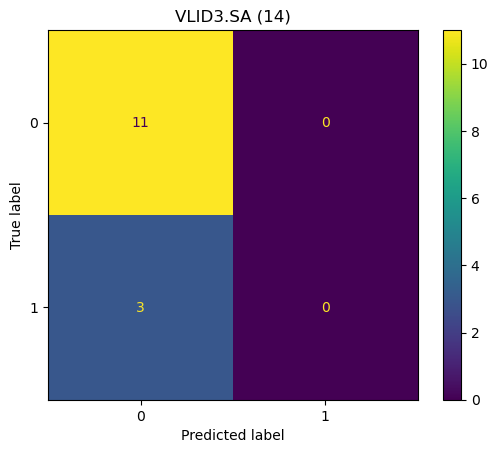

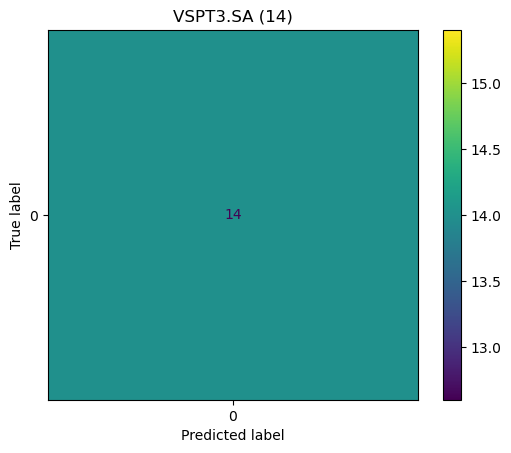

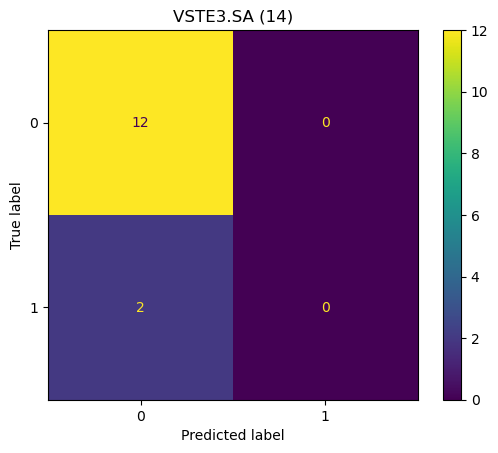

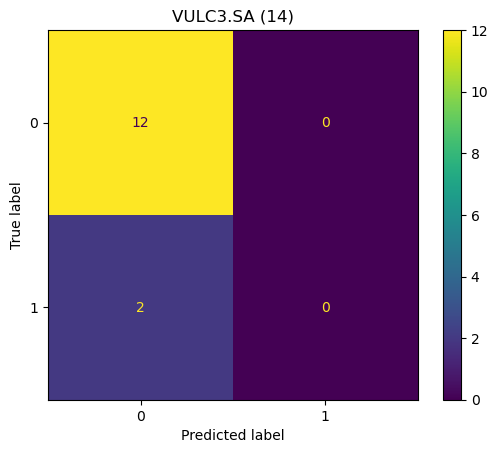

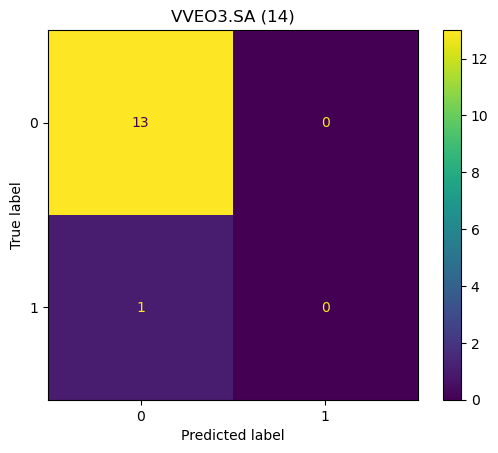

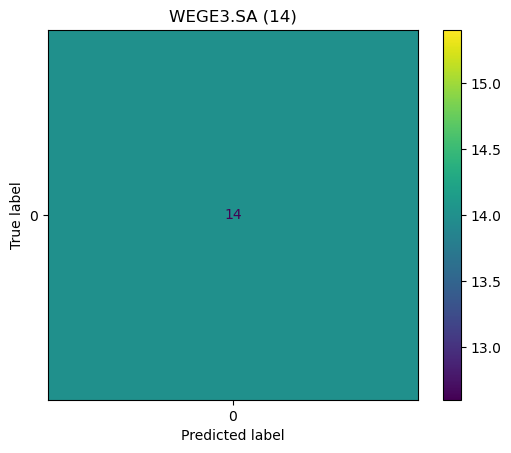

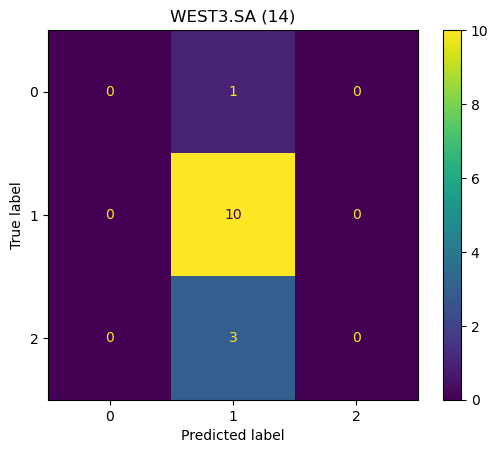

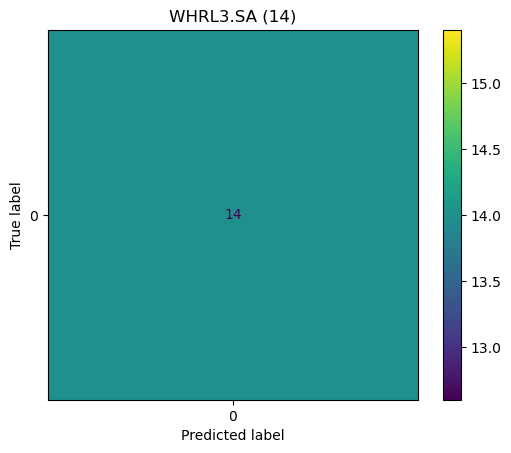

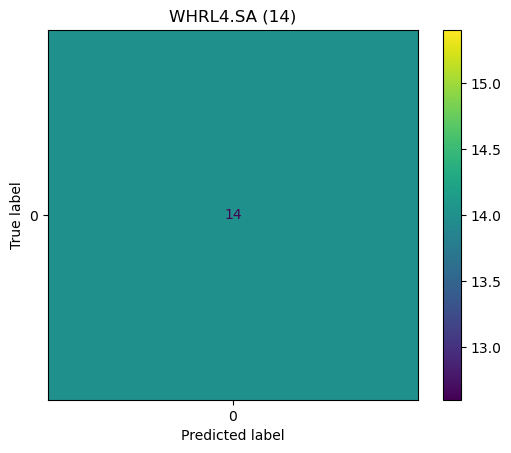

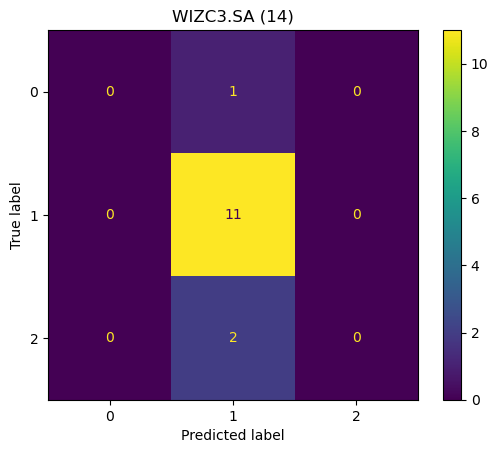

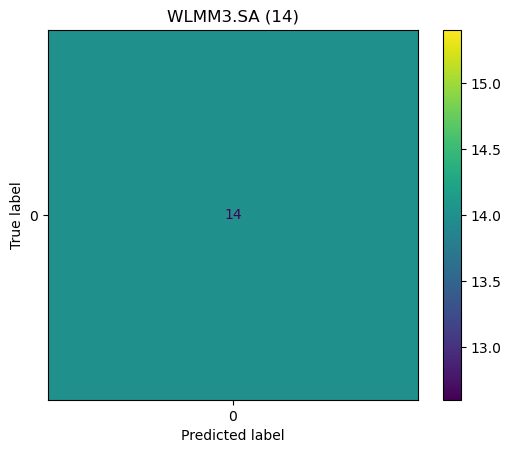

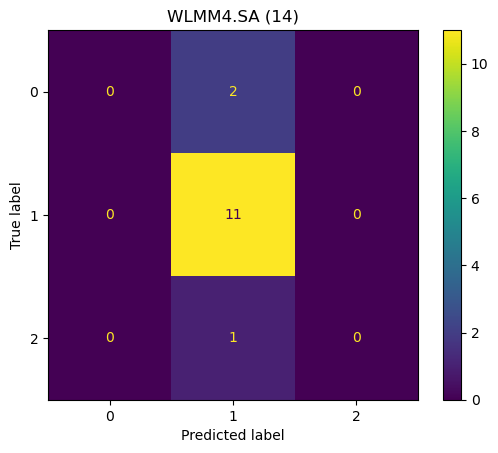

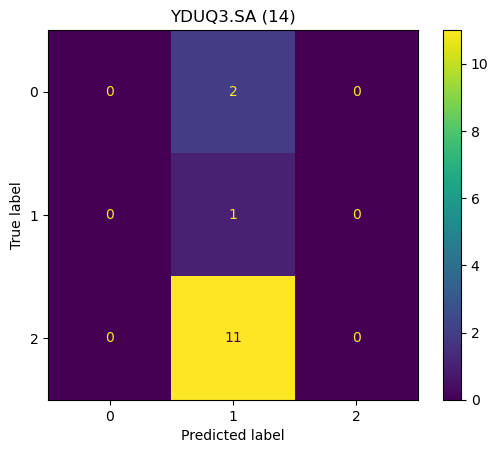

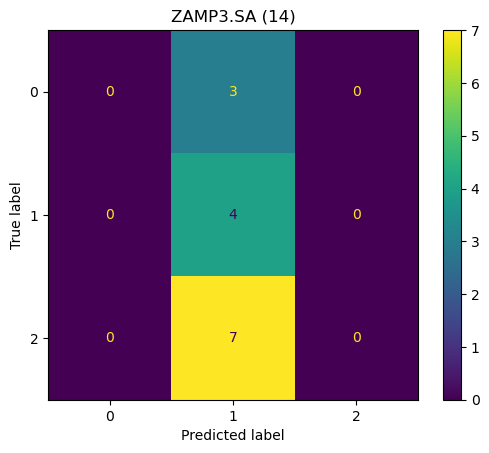

In [132]:
if not os.path.exists('conv_confusion_matrix'):
    os.makedirs('conv_confusion_matrix')

shape_saída = (Prospecção*2)+1 if Categórico and Bidirecional else \
              Prospecção+1 if Categórico else \
              3 if Bidirecional else \
              2


Modelos = {}

for tckr in tqdm(Rótulos.keys()):
    # Cria o objeto de sequência de camadas
    
    Modelos[tckr] = models.Sequential()

    Modelos[tckr].add(layers.Conv2D(64, (2, 2), activation = 'relu', input_shape = Shape))
    Modelos[tckr].add(layers.MaxPooling2D((2, 2)))

    Modelos[tckr].add(layers.Conv2D(64, (2, 2), activation = 'relu'))
    Modelos[tckr].add(layers.MaxPooling2D((2, 2)))

    Modelos[tckr].add(layers.Conv2D(64, (1, 1), activation = 'relu'))
    Modelos[tckr].add(layers.MaxPooling2D((2, 2)))

    Modelos[tckr].add(layers.Flatten())

    Modelos[tckr].add(layers.Dense(64, activation = 'relu'))

    Modelos[tckr].add(layers.Dense(32, activation = 'relu'))

    Modelos[tckr].add(layers.Dense(shape_saída, activation = 'softmax'))

    Modelos[tckr].compile(optimizer = 'adam', 
                    loss = 'sparse_categorical_crossentropy', 
                    metrics = ['accuracy'])

    # Treinamento e teste

    history = Modelos[tckr].fit(Treino_tensor, 
                            Treino_rótulo[tckr], 
                            epochs = épocas, 
                            validation_data = (Teste_tensor, Teste_rótulo[tckr]),
                            callbacks = [early_stopping, checkpoint], # accuracy_callback
                            verbose = 0)
    
    Modelos[tckr].evaluate(Valid_tensor, Valid_rótulo[tckr], verbose = 0)
    
    test_predictions = Modelos[tckr].predict(Valid_tensor)

    test_predicted_labels = np.argmax(test_predictions, axis=1)

    test_true_labels = np.array(Valid_rótulo[tckr])

    cm = confusion_matrix(test_true_labels, test_predicted_labels)

    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

    cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')

    plt.title(tckr+' ('+str(len(test_true_labels))+')')

    plt.savefig('conv_confusion_matrix\\' + tckr+'.png')

* Objeto de tracking para averiguar se os dados não foram desalinhados
* Salvar a acertividade dos modelos por ticker
* Verificar porque alguns gráficos de calor têm menos observações.